# HW06 : Text Classification with Neural Networks

ในหัวข้อนี้จะได้เรียนรู้การสร้างโมเดลสำหรับจำแนกข้อความ โดยใช้วิธีต่างๆ ดังนี้

2) TF-IDF (used as input features) + Neural network

3) Using Word embeding from ULMFit

4) Fine-tuning BERT

รวมไปถึงการประเมินประสิทธิภาพของแบบจำลอง


# Data Preparation

ในบทนี้เราจะใช้ข้อมูลของ Wongnai Sentiment Corpus มาใช้ในการสร้างแบบจำลอง



In [7]:
#download data
!wget https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/pos.txt
!wget https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/neg.txt

#create train/validate/test datasets
from math import floor

def split_train_test_sets(file_list,train_num=0.8,val_num=0.1,test_num=0.1):

    split_train_index = floor(len(file_list) * train_num)
    split_val_index = floor(len(file_list) * (train_num+val_num))
    train = file_list[:split_train_index]
    val = file_list[split_train_index:split_val_index]
    test = file_list[split_val_index:]
    return train, val, test

def file2list(fname):
  with open(fname) as fp:
    lines = fp.readlines()
    return [line.strip() for line in lines]
def list2file(items,fname):
  file = open(fname,'w')
  for item in items:
    file.write(item.strip()+"\n")
  file.close()



--2024-01-15 14:12:43--  https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/pos.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 761195 (743K) [text/plain]
Saving to: ‘pos.txt’

pos.txt             100%[===================>] 743.35K  --.-KB/s    in 0.02s   

2024-01-15 14:12:43 (45.2 MB/s) - ‘pos.txt’ saved [761195/761195]

--2024-01-15 14:12:44--  https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/neg.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1676577 (1.6M) [text/plain]
Saving 

In [8]:
import pandas as pd
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict

In [9]:
pos_text = file2list("pos.txt")
neg_text = file2list("neg.txt")

In [10]:
pos_df = pd.DataFrame(pos_text,columns=['review'])
pos_df['label'] = "positive"

neg_df = pd.DataFrame(neg_text,columns=['review'])
neg_df['label'] = "negative"
neg_df

data = pd.concat([pos_df, neg_df])

data.sample(10)

,review,label
4741,เมื่อไหร่จะเก็บภาษีสำนักงานทรัพย์สิน ภาษีที่ดิ...,negative
910,นี่เลยเหมาะ,positive
494,จะปรี๊ดแตกพนงเอมเค,negative
3761,ครับ ทานมาจนได้บัตร แพลตตินัท รุ่นแรกเลยครับ ไ...,positive
6234,ในหมู่บ้านผม 3bb เป็นไฟเบอร์ ais ก็กำลังจะวางไ...,negative
762,ป่ะๆ หิวละ,positive
400,จัดไป!!!,positive
1339,ปะกินฮอทพอท555,positive
2854,ถ้าเป็นมาสด้าสวยทุกแบบทุกรุ่นค่ะ,positive
295,ไม่ชอบไม่ใช่รึ,negative


In [11]:
category_counts = data['label'].value_counts()

category_counts

negative    6823
positive    4778
Name: label, dtype: int64

# Data Preprocessing


In [12]:
!pip install pythainlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 59.0 MB/s eta 0:00:00


### Tokenization

In [13]:
from pythainlp.tokenize import word_tokenize
import re

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def thai_clean_text(text):
    st = ""

    #สามารถเพิ่มโค้ด สำหรับคลีน ข้อความ เช่น ลบ emoji ออก เป็นต้น
    #text = deEmojify(text)
    text = text.replace("\n"," ")
    for w in word_tokenize(text):
        st = st + w + " "

    return  re.sub(' +', ' ', st)

data['review'] = data.review.apply(thai_clean_text)
data.sample(5)

,review,label
6223,เคย กิน ข้าวเหนียว มะม่วง จาน ละ 350 มา แล้ว ซ...,negative
3604,ผม ใช้ ดาก อน พาวเวอร์ 4 X 4 มา 20 ปี วี ครอส ...,negative
4984,แล้ว ผ้าอนามัย แบบ เย็น ที่ นี้ เสือก เย็น เว่...,negative
586,กลัว ใช้ โอ เลย์ แล้ว แพ้,negative
1418,ขอบคุณ นะ เสี่ย 🙏,positive


### Removing stop words

In [14]:
import pythainlp
thai_stopwords = pythainlp.corpus.common.thai_stopwords()

print(thai_stopwords)

frozenset({'กลุ่มๆ', 'ใหม่ๆ', 'ตลอดมา', 'แต่', 'ตรง', 'ข้างบน', 'กำลังจะ', 'ให้มา', 'จัง', 'จากนั้น', 'เรา', 'วันนี้', 'เหล่า', 'คราวโน้น', 'พวกนี้', 'เพิ่ม', 'ล่าสุด', 'วันนั้น', 'น่ะ', 'ตลอดจน', 'กว่า', 'แค่นั้น', 'มิได้', 'ถึงบัดนี้', 'คือ', 'อื่น', 'ค่อย', 'เหตุ', 'ได้แต่', 'ค่อยไปทาง', 'ที่ได้', 'ไฉน', 'ขณะใดๆ', 'ภาย', 'นี้แหล่', 'นำ', 'อย่างมาก', 'ครบ', 'ข้างเคียง', 'กันเอง', 'พอเพียง', 'ที่สุด', 'ยังงี้', 'หน่อย', 'อย่างโน้น', 'กำหนด', 'เป็นเพื่อ', 'กระผม', 'อย่างใด', 'อันๆ', 'กว้างๆ', 'จรดกับ', 'เช่นไร', 'ส่วนด้อย', 'เชื่อถือ', 'นานๆ', 'ประการหนึ่ง', 'อย่าง', 'ซึ่งกันและกัน', 'ครบครัน', 'เช่นเมื่อ', 'เช่นดัง', 'วัน', 'ช่วงท้าย', 'เผื่อ', 'เสร็จแล้ว', 'ได้', 'อย่างเช่น', 'นั่นแหละ', 'ดัง', 'สู่', 'จัดการ', 'เป็นแต่เพียง', 'ดังเคย', 'เพิ่มเติม', 'ดั่งกับว่า', 'เป็นแต่', 'ช่วย', 'ตามที่', 'ด้วยกัน', 'เพิ่งจะ', 'เปิดเผย', 'ทั่ว', 'ค่อน', 'พอตัว', 'มอง', 'จาก', 'บัดเดี๋ยวนี้', 'ช่วง', 'ทีไร', 'ทุกๆ', 'ครั้งใด', 'พร้อมที่', 'เรียบ', 'เหตุนี้', 'ยิ่งใหญ่', 'เมื่อเย็น', 'คุณๆ', 'คราใด'

In [15]:
def remove_stop_word(seg_text):
    st = ""
    words = seg_text.split(' ')
    clean_words = []
    for w in words:
      if w not in thai_stopwords:
        clean_words.append(w)
    st = ' '.join(clean_words)
    return  re.sub(' +', ' ', st)

data['review'] = data.review.apply(remove_stop_word)
data.sample(5)

,review,label
4731,ดู รูป อ่าน เมนู กิน Mk โฆษณา รูป แบบนี้ ของจร...,negative
1013,,negative
2151,พน . น้อง หลาว,positive
5703,คิดดู คุ้ม กิน 2 คน ค่าเช่า ชุด ปา รู้ อี กิน ...,negative
1824,ม่ เห น น้ำจิ้ม แจ่ว เรย แอด,negative


# TF-IDF + Feed Forward Neural Network

ในส่วนนี้เราจะใช้ข้อมูลชุดเดิมและใช้ TF-IDF ในการแทนแต่ละประโยคหลังจากนั้นก็เทรน ด้วย Feed Forward Neural Network

โค้ดดัดแปลงมาจาก https://colab.research.google.com/drive/1SR_j7FUYcJ21CCsIT8fkRjGOteevQEPa#scrollTo=4Wf_YSr78IMO

In [16]:
reviews = data['review'].values
labels = data['label'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels,test_size=0.2, random_state=1234)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
val_size = int(len(test_sentences)/2)
train = list(train_sentences)[:(len(train_sentences)-val_size)]
val = list(train_sentences)[(len(train_sentences)-val_size):]
test = list(test_sentences)

tfidf_vectorizer = TfidfVectorizer(max_features=1000, dtype=np.float32)

#ใช้ชุดเทรน ทำ vectorizer
tfidfX_train = tfidf_vectorizer.fit_transform(train)
tfidfX_train = torch.tensor(tfidfX_train.toarray())

tfidfX_val = tfidf_vectorizer.transform(val)
tfidfX_val = torch.tensor(tfidfX_val.toarray())

tfidfX_test = tfidf_vectorizer.transform(test)
tfidfX_test = torch.tensor(tfidfX_test.toarray())

print("TF-IDF train shape:", tfidfX_train.shape)
print("TF-IDF test shape:", tfidfX_test.shape)
print("TF-IDF val shape:", tfidfX_val.shape)

TF-IDF train shape: torch.Size([8120, 1000])
TF-IDF test shape: torch.Size([2321, 1000])
TF-IDF val shape: torch.Size([1160, 1000])


In [18]:
print(train[0:2])

['ว้าว วว ', 'ดี น้า ']


In [ ]:
print(tfidfX_train[100])

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [19]:
import torch
Y_train = torch.squeeze(torch.tensor(list(train_labels[:(len(train_sentences)-val_size)])).float())
Y_val = torch.squeeze(torch.tensor(train_labels[(len(train_sentences)-val_size):]).float())
Y_test = torch.squeeze(torch.tensor(test_labels).float())

print("Y train shape:", Y_train.shape)
print("Y test shape:", Y_val.shape)
print("Y shape:", Y_test.shape)

Y train shape: torch.Size([8120])
Y test shape: torch.Size([1160])
Y shape: torch.Size([2321])


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [21]:
#สร้าง FFNN ขึ้นมา
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(FFNN, self).__init__()

        # Linear function 1
        self.layer_1 = nn.Linear(input_dim, hidden_dim_1)

        # Non-linearity 1
        self.relu_1 = nn.ReLU()

        # Linear function 2
        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        # Non-linearity 2
        self.relu_2 = nn.ReLU()

        # Linear function 3
        self.layer_3 = nn.Linear(hidden_dim_2, output_dim)

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu_1(out)

        out = self.layer_2(out)
        out = self.relu_2(out)

        out = self.layer_3(out)

        return torch.sigmoid(out)

In [22]:
# กำหนดจำนวนรอบที่จะเทรน
input_dim = tfidfX_train.shape[1]
hidden_dim_1 = 512 #จำนวนโหนด
hidden_dim_2 = 512
output_dim = 1 #จำนวน output dim ใช้ 1 ได้ คือเราอยากจะทำนายค่าออกมาค่าเดียว 0 = negative และ 1 คือ เป็น positive
num_epochs = 200
import random
random.seed(12345)

# สร้าง model จากคลาส
first_model = FFNN(input_dim,hidden_dim_1,hidden_dim_2,output_dim)

# Define loss function.
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

# Define as optimizer Adam.
optimizer = optim.Adam(first_model.parameters(),lr=0.1e-4,weight_decay=1e-3)

# Transfer all the computation to GPU (cuda device).
first_model.to(device)
criterion = criterion.to(device)

In [23]:
from tqdm import tqdm

# This is a function that calculate the accuracy manually
def calculate_accuracy(y_true, y_pred):
  y_pred = torch.round(y_pred)
  correct = (y_true == y_pred).float()
  acc = correct.sum() / len(correct)
  return acc

batch_size = 16

# Split train dataset to mini batches
X_train_mini_batches = torch.split(tfidfX_train,batch_size)
Y_train_mini_batches = torch.split(Y_train,batch_size)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
min_loss = float('inf')

# Start training
for epoch in range(num_epochs):
  print('epoch',epoch)
  epoch_loss = 0
  epoch_accuracy = 0
  validation_loss=0
  val_accuracy=0

  for X_train_mini_batch,Y_train_mini_batch in tqdm(zip(X_train_mini_batches,Y_train_mini_batches)):

    X_train_mini_batch = X_train_mini_batch.to(device)
    Y_train_mini_batch = Y_train_mini_batch.to(device)

    # Forward pass to get output
    train_prediction = first_model.forward(X_train_mini_batch.float())
    train_prediction = torch.squeeze(train_prediction)

    # Calculate Loss
    train_loss = criterion(train_prediction,Y_train_mini_batch)

    # Clearing up accumulated gradients
    optimizer.zero_grad()

    # Getting gradients
    train_loss.backward()

    # Updating parameters
    optimizer.step()

    # Add each mini batch's loss
    epoch_loss += train_loss.item()

    # Add each mini batch's accuracy
    epoch_accuracy += calculate_accuracy(Y_train_mini_batch,train_prediction)

  # For some epochs print loss and accucary of train and validation set.
  if epoch % 1 == 0:

    tfidfX_val = tfidfX_val.to(device)
    Y_val = Y_val.to(device)

    # Forward pass to get output
    val_prediction = first_model.forward(tfidfX_val.float())
    val_prediction = torch.squeeze(val_prediction)

    # Calculate Loss
    val_loss = criterion(val_prediction,Y_val)

    # Add each mini batch's loss
    validation_loss = val_loss.item()

    # Add each mini batch's accuracy
    val_accuracy = calculate_accuracy(Y_val,val_prediction)

    epoch_loss /= len(X_train_mini_batches)
    epoch_accuracy /= len(X_train_mini_batches)
    val_losses.append(validation_loss)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    val_accuracies.append(val_accuracy)
    if validation_loss < min_loss:
      min_loss = validation_loss
      torch.save(first_model.state_dict(), 'best_model.pt')
      print('save best_model...')
    print("Epoch:",epoch, "\n"
           "Train_loss:",round(epoch_loss,4), "Train Accuracy:",round(epoch_accuracy.item(),4), "\n"
           "Validation_loss:  ",round(validation_loss,4), "Validation Accuracy:  ",round(val_accuracy.item(),4), "\n")

epoch 0


508it [00:02, 217.89it/s]


save best_model...
Epoch: 0 
Train_loss: 0.6874 Train Accuracy: 0.587 
Validation_loss:   0.6826 Validation Accuracy:   0.5966 

epoch 1


508it [00:00, 509.13it/s]


save best_model...
Epoch: 1 
Train_loss: 0.6802 Train Accuracy: 0.587 
Validation_loss:   0.6748 Validation Accuracy:   0.5966 

epoch 2


508it [00:01, 452.62it/s]


save best_model...
Epoch: 2 
Train_loss: 0.673 Train Accuracy: 0.587 
Validation_loss:   0.6672 Validation Accuracy:   0.5966 

epoch 3


508it [00:01, 446.68it/s]


save best_model...
Epoch: 3 
Train_loss: 0.6656 Train Accuracy: 0.587 
Validation_loss:   0.6594 Validation Accuracy:   0.5966 

epoch 4


508it [00:00, 537.93it/s]


save best_model...
Epoch: 4 
Train_loss: 0.657 Train Accuracy: 0.587 
Validation_loss:   0.6504 Validation Accuracy:   0.5966 

epoch 5


508it [00:01, 451.62it/s]


save best_model...
Epoch: 5 
Train_loss: 0.6462 Train Accuracy: 0.587 
Validation_loss:   0.6391 Validation Accuracy:   0.5966 

epoch 6


508it [00:01, 427.60it/s]


save best_model...
Epoch: 6 
Train_loss: 0.6321 Train Accuracy: 0.5871 
Validation_loss:   0.6245 Validation Accuracy:   0.5966 

epoch 7


508it [00:00, 539.32it/s]


save best_model...
Epoch: 7 
Train_loss: 0.6136 Train Accuracy: 0.5941 
Validation_loss:   0.6061 Validation Accuracy:   0.6181 

epoch 8


508it [00:00, 538.06it/s]


save best_model...
Epoch: 8 
Train_loss: 0.5911 Train Accuracy: 0.6384 
Validation_loss:   0.5848 Validation Accuracy:   0.6759 

epoch 9


508it [00:00, 520.69it/s]


save best_model...
Epoch: 9 
Train_loss: 0.566 Train Accuracy: 0.7035 
Validation_loss:   0.5625 Validation Accuracy:   0.7483 

epoch 10


508it [00:00, 518.68it/s]


save best_model...
Epoch: 10 
Train_loss: 0.5408 Train Accuracy: 0.7736 
Validation_loss:   0.5417 Validation Accuracy:   0.7612 

epoch 11


508it [00:00, 508.22it/s]


save best_model...
Epoch: 11 
Train_loss: 0.5177 Train Accuracy: 0.7891 
Validation_loss:   0.5237 Validation Accuracy:   0.775 

epoch 12


508it [00:00, 515.49it/s]


save best_model...
Epoch: 12 
Train_loss: 0.4977 Train Accuracy: 0.7963 
Validation_loss:   0.5091 Validation Accuracy:   0.7793 

epoch 13


508it [00:01, 477.69it/s]


save best_model...
Epoch: 13 
Train_loss: 0.4811 Train Accuracy: 0.8034 
Validation_loss:   0.4975 Validation Accuracy:   0.7698 

epoch 14


508it [00:01, 444.96it/s]


save best_model...
Epoch: 14 
Train_loss: 0.4675 Train Accuracy: 0.8044 
Validation_loss:   0.4887 Validation Accuracy:   0.7733 

epoch 15


508it [00:01, 443.42it/s]


save best_model...
Epoch: 15 
Train_loss: 0.4564 Train Accuracy: 0.8061 
Validation_loss:   0.4818 Validation Accuracy:   0.7767 

epoch 16


508it [00:00, 524.87it/s]


save best_model...
Epoch: 16 
Train_loss: 0.4473 Train Accuracy: 0.8082 
Validation_loss:   0.4766 Validation Accuracy:   0.775 

epoch 17


508it [00:00, 529.57it/s]


save best_model...
Epoch: 17 
Train_loss: 0.4397 Train Accuracy: 0.8109 
Validation_loss:   0.4725 Validation Accuracy:   0.7767 

epoch 18


508it [00:00, 527.15it/s]


save best_model...
Epoch: 18 
Train_loss: 0.4334 Train Accuracy: 0.8124 
Validation_loss:   0.4693 Validation Accuracy:   0.775 

epoch 19


508it [00:00, 523.37it/s]


save best_model...
Epoch: 19 
Train_loss: 0.4279 Train Accuracy: 0.8145 
Validation_loss:   0.4668 Validation Accuracy:   0.7759 

epoch 20


508it [00:00, 532.00it/s]


save best_model...
Epoch: 20 
Train_loss: 0.4232 Train Accuracy: 0.8159 
Validation_loss:   0.4648 Validation Accuracy:   0.7733 

epoch 21


508it [00:00, 536.99it/s]


save best_model...
Epoch: 21 
Train_loss: 0.419 Train Accuracy: 0.8175 
Validation_loss:   0.4631 Validation Accuracy:   0.7724 

epoch 22


508it [00:00, 534.06it/s]


save best_model...
Epoch: 22 
Train_loss: 0.4153 Train Accuracy: 0.8193 
Validation_loss:   0.4618 Validation Accuracy:   0.7707 

epoch 23


508it [00:00, 531.20it/s]


save best_model...
Epoch: 23 
Train_loss: 0.412 Train Accuracy: 0.8204 
Validation_loss:   0.4607 Validation Accuracy:   0.7681 

epoch 24


508it [00:00, 537.48it/s]


save best_model...
Epoch: 24 
Train_loss: 0.4089 Train Accuracy: 0.8216 
Validation_loss:   0.4598 Validation Accuracy:   0.7672 

epoch 25


508it [00:00, 527.25it/s]


save best_model...
Epoch: 25 
Train_loss: 0.4062 Train Accuracy: 0.8222 
Validation_loss:   0.4591 Validation Accuracy:   0.7707 

epoch 26


508it [00:01, 449.97it/s]


save best_model...
Epoch: 26 
Train_loss: 0.4036 Train Accuracy: 0.8222 
Validation_loss:   0.4585 Validation Accuracy:   0.7707 

epoch 27


508it [00:01, 444.10it/s]


save best_model...
Epoch: 27 
Train_loss: 0.4013 Train Accuracy: 0.8237 
Validation_loss:   0.4581 Validation Accuracy:   0.7698 

epoch 28


508it [00:01, 475.10it/s]


save best_model...
Epoch: 28 
Train_loss: 0.3991 Train Accuracy: 0.825 
Validation_loss:   0.4577 Validation Accuracy:   0.769 

epoch 29


508it [00:01, 506.11it/s]


save best_model...
Epoch: 29 
Train_loss: 0.3971 Train Accuracy: 0.826 
Validation_loss:   0.4575 Validation Accuracy:   0.7681 

epoch 30


508it [00:00, 517.24it/s]


save best_model...
Epoch: 30 
Train_loss: 0.3953 Train Accuracy: 0.8276 
Validation_loss:   0.4573 Validation Accuracy:   0.7672 

epoch 31


508it [00:00, 528.65it/s]


save best_model...
Epoch: 31 
Train_loss: 0.3935 Train Accuracy: 0.8278 
Validation_loss:   0.4572 Validation Accuracy:   0.7664 

epoch 32


508it [00:00, 528.47it/s]


save best_model...
Epoch: 32 
Train_loss: 0.3918 Train Accuracy: 0.828 
Validation_loss:   0.4571 Validation Accuracy:   0.7672 

epoch 33


508it [00:00, 519.03it/s]


save best_model...
Epoch: 33 
Train_loss: 0.3903 Train Accuracy: 0.8282 
Validation_loss:   0.4571 Validation Accuracy:   0.7681 

epoch 34


508it [00:00, 517.63it/s]


Epoch: 34 
Train_loss: 0.3888 Train Accuracy: 0.8287 
Validation_loss:   0.4571 Validation Accuracy:   0.7681 

epoch 35


508it [00:00, 522.16it/s]


Epoch: 35 
Train_loss: 0.3874 Train Accuracy: 0.8298 
Validation_loss:   0.4572 Validation Accuracy:   0.7655 

epoch 36


508it [00:00, 527.71it/s]


Epoch: 36 
Train_loss: 0.3861 Train Accuracy: 0.8302 
Validation_loss:   0.4572 Validation Accuracy:   0.7629 

epoch 37


508it [00:00, 531.81it/s]


Epoch: 37 
Train_loss: 0.3849 Train Accuracy: 0.8321 
Validation_loss:   0.4574 Validation Accuracy:   0.7638 

epoch 38


508it [00:01, 481.00it/s]


Epoch: 38 
Train_loss: 0.3837 Train Accuracy: 0.8322 
Validation_loss:   0.4575 Validation Accuracy:   0.7647 

epoch 39


508it [00:01, 456.68it/s]


Epoch: 39 
Train_loss: 0.3825 Train Accuracy: 0.8328 
Validation_loss:   0.4576 Validation Accuracy:   0.7638 

epoch 40


508it [00:01, 444.38it/s]


Epoch: 40 
Train_loss: 0.3814 Train Accuracy: 0.8337 
Validation_loss:   0.4578 Validation Accuracy:   0.7655 

epoch 41


508it [00:00, 524.00it/s]


Epoch: 41 
Train_loss: 0.3804 Train Accuracy: 0.834 
Validation_loss:   0.458 Validation Accuracy:   0.7664 

epoch 42


508it [00:00, 520.47it/s]


Epoch: 42 
Train_loss: 0.3794 Train Accuracy: 0.8344 
Validation_loss:   0.4582 Validation Accuracy:   0.7672 

epoch 43


508it [00:00, 522.68it/s]


Epoch: 43 
Train_loss: 0.3784 Train Accuracy: 0.8348 
Validation_loss:   0.4584 Validation Accuracy:   0.7672 

epoch 44


508it [00:00, 525.55it/s]


Epoch: 44 
Train_loss: 0.3775 Train Accuracy: 0.8356 
Validation_loss:   0.4586 Validation Accuracy:   0.7672 

epoch 45


508it [00:00, 525.84it/s]


Epoch: 45 
Train_loss: 0.3766 Train Accuracy: 0.836 
Validation_loss:   0.4588 Validation Accuracy:   0.7672 

epoch 46


508it [00:00, 523.19it/s]


Epoch: 46 
Train_loss: 0.3757 Train Accuracy: 0.8365 
Validation_loss:   0.4591 Validation Accuracy:   0.7681 

epoch 47


508it [00:00, 514.15it/s]


Epoch: 47 
Train_loss: 0.3749 Train Accuracy: 0.8365 
Validation_loss:   0.4593 Validation Accuracy:   0.7681 

epoch 48


508it [00:00, 520.48it/s]


Epoch: 48 
Train_loss: 0.374 Train Accuracy: 0.837 
Validation_loss:   0.4595 Validation Accuracy:   0.7681 

epoch 49


508it [00:00, 521.40it/s]


Epoch: 49 
Train_loss: 0.3732 Train Accuracy: 0.8372 
Validation_loss:   0.4597 Validation Accuracy:   0.7681 

epoch 50


508it [00:00, 514.52it/s]


Epoch: 50 
Train_loss: 0.3725 Train Accuracy: 0.838 
Validation_loss:   0.46 Validation Accuracy:   0.769 

epoch 51


508it [00:01, 436.32it/s]


Epoch: 51 
Train_loss: 0.3717 Train Accuracy: 0.8388 
Validation_loss:   0.4602 Validation Accuracy:   0.769 

epoch 52


508it [00:01, 257.66it/s]


Epoch: 52 
Train_loss: 0.371 Train Accuracy: 0.8391 
Validation_loss:   0.4604 Validation Accuracy:   0.769 

epoch 53


508it [00:00, 512.45it/s]


Epoch: 53 
Train_loss: 0.3702 Train Accuracy: 0.8393 
Validation_loss:   0.4607 Validation Accuracy:   0.7698 

epoch 54


508it [00:00, 518.79it/s]


Epoch: 54 
Train_loss: 0.3695 Train Accuracy: 0.8393 
Validation_loss:   0.4609 Validation Accuracy:   0.7698 

epoch 55


508it [00:00, 528.77it/s]


Epoch: 55 
Train_loss: 0.3688 Train Accuracy: 0.8392 
Validation_loss:   0.4611 Validation Accuracy:   0.769 

epoch 56


508it [00:00, 529.46it/s]


Epoch: 56 
Train_loss: 0.3681 Train Accuracy: 0.8392 
Validation_loss:   0.4613 Validation Accuracy:   0.7698 

epoch 57


508it [00:00, 529.08it/s]


Epoch: 57 
Train_loss: 0.3674 Train Accuracy: 0.8394 
Validation_loss:   0.4616 Validation Accuracy:   0.7698 

epoch 58


508it [00:00, 523.94it/s]


Epoch: 58 
Train_loss: 0.3667 Train Accuracy: 0.8402 
Validation_loss:   0.4618 Validation Accuracy:   0.7698 

epoch 59


508it [00:00, 527.63it/s]


Epoch: 59 
Train_loss: 0.3661 Train Accuracy: 0.8404 
Validation_loss:   0.462 Validation Accuracy:   0.7681 

epoch 60


508it [00:00, 518.51it/s]


Epoch: 60 
Train_loss: 0.3654 Train Accuracy: 0.8408 
Validation_loss:   0.4622 Validation Accuracy:   0.7681 

epoch 61


508it [00:00, 524.89it/s]


Epoch: 61 
Train_loss: 0.3647 Train Accuracy: 0.8409 
Validation_loss:   0.4624 Validation Accuracy:   0.7681 

epoch 62


508it [00:01, 502.87it/s]


Epoch: 62 
Train_loss: 0.364 Train Accuracy: 0.8409 
Validation_loss:   0.4627 Validation Accuracy:   0.7681 

epoch 63


508it [00:01, 451.88it/s]


Epoch: 63 
Train_loss: 0.3634 Train Accuracy: 0.8412 
Validation_loss:   0.4629 Validation Accuracy:   0.7681 

epoch 64


508it [00:01, 446.85it/s]


Epoch: 64 
Train_loss: 0.3627 Train Accuracy: 0.8417 
Validation_loss:   0.4631 Validation Accuracy:   0.7672 

epoch 65


508it [00:01, 502.06it/s]


Epoch: 65 
Train_loss: 0.3621 Train Accuracy: 0.8422 
Validation_loss:   0.4632 Validation Accuracy:   0.7672 

epoch 66


508it [00:00, 516.49it/s]


Epoch: 66 
Train_loss: 0.3614 Train Accuracy: 0.8425 
Validation_loss:   0.4634 Validation Accuracy:   0.7655 

epoch 67


508it [00:00, 517.62it/s]


Epoch: 67 
Train_loss: 0.3607 Train Accuracy: 0.8426 
Validation_loss:   0.4636 Validation Accuracy:   0.7655 

epoch 68


508it [00:00, 523.58it/s]


Epoch: 68 
Train_loss: 0.36 Train Accuracy: 0.8425 
Validation_loss:   0.4638 Validation Accuracy:   0.7664 

epoch 69


508it [00:00, 510.54it/s]


Epoch: 69 
Train_loss: 0.3594 Train Accuracy: 0.8436 
Validation_loss:   0.4639 Validation Accuracy:   0.7655 

epoch 70


508it [00:01, 414.02it/s]


Epoch: 70 
Train_loss: 0.3587 Train Accuracy: 0.8439 
Validation_loss:   0.4641 Validation Accuracy:   0.7647 

epoch 71


508it [00:01, 368.41it/s]


Epoch: 71 
Train_loss: 0.358 Train Accuracy: 0.8446 
Validation_loss:   0.4643 Validation Accuracy:   0.7647 

epoch 72


508it [00:00, 519.42it/s]


Epoch: 72 
Train_loss: 0.3573 Train Accuracy: 0.8451 
Validation_loss:   0.4645 Validation Accuracy:   0.7638 

epoch 73


508it [00:00, 530.82it/s]


Epoch: 73 
Train_loss: 0.3566 Train Accuracy: 0.8456 
Validation_loss:   0.4646 Validation Accuracy:   0.7638 

epoch 74


508it [00:01, 497.93it/s]


Epoch: 74 
Train_loss: 0.3559 Train Accuracy: 0.8457 
Validation_loss:   0.4648 Validation Accuracy:   0.7647 

epoch 75


508it [00:01, 448.30it/s]


Epoch: 75 
Train_loss: 0.3552 Train Accuracy: 0.8461 
Validation_loss:   0.4649 Validation Accuracy:   0.7647 

epoch 76


508it [00:01, 443.52it/s]


Epoch: 76 
Train_loss: 0.3545 Train Accuracy: 0.8462 
Validation_loss:   0.4651 Validation Accuracy:   0.7647 

epoch 77


508it [00:00, 521.63it/s]


Epoch: 77 
Train_loss: 0.3538 Train Accuracy: 0.8465 
Validation_loss:   0.4652 Validation Accuracy:   0.7647 

epoch 78


508it [00:00, 527.57it/s]


Epoch: 78 
Train_loss: 0.3531 Train Accuracy: 0.8471 
Validation_loss:   0.4654 Validation Accuracy:   0.7655 

epoch 79


508it [00:00, 530.37it/s]


Epoch: 79 
Train_loss: 0.3524 Train Accuracy: 0.8476 
Validation_loss:   0.4655 Validation Accuracy:   0.7655 

epoch 80


508it [00:00, 517.77it/s]


Epoch: 80 
Train_loss: 0.3516 Train Accuracy: 0.8481 
Validation_loss:   0.4657 Validation Accuracy:   0.7664 

epoch 81


508it [00:00, 524.32it/s]


Epoch: 81 
Train_loss: 0.3509 Train Accuracy: 0.8482 
Validation_loss:   0.4658 Validation Accuracy:   0.7664 

epoch 82


508it [00:00, 527.58it/s]


Epoch: 82 
Train_loss: 0.3501 Train Accuracy: 0.8489 
Validation_loss:   0.466 Validation Accuracy:   0.7664 

epoch 83


508it [00:00, 534.01it/s]


Epoch: 83 
Train_loss: 0.3494 Train Accuracy: 0.849 
Validation_loss:   0.4661 Validation Accuracy:   0.7672 

epoch 84


508it [00:00, 535.64it/s]


Epoch: 84 
Train_loss: 0.3486 Train Accuracy: 0.849 
Validation_loss:   0.4663 Validation Accuracy:   0.7681 

epoch 85


508it [00:00, 524.74it/s]


Epoch: 85 
Train_loss: 0.3478 Train Accuracy: 0.8492 
Validation_loss:   0.4664 Validation Accuracy:   0.7672 

epoch 86


508it [00:00, 526.50it/s]


Epoch: 86 
Train_loss: 0.347 Train Accuracy: 0.8498 
Validation_loss:   0.4665 Validation Accuracy:   0.7655 

epoch 87


508it [00:01, 460.44it/s]


Epoch: 87 
Train_loss: 0.3462 Train Accuracy: 0.8505 
Validation_loss:   0.4667 Validation Accuracy:   0.7655 

epoch 88


508it [00:01, 453.41it/s]


Epoch: 88 
Train_loss: 0.3454 Train Accuracy: 0.8509 
Validation_loss:   0.4668 Validation Accuracy:   0.7655 

epoch 89


508it [00:01, 470.00it/s]


Epoch: 89 
Train_loss: 0.3445 Train Accuracy: 0.8514 
Validation_loss:   0.4669 Validation Accuracy:   0.7655 

epoch 90


508it [00:00, 521.86it/s]


Epoch: 90 
Train_loss: 0.3437 Train Accuracy: 0.853 
Validation_loss:   0.4671 Validation Accuracy:   0.7655 

epoch 91


508it [00:00, 520.17it/s]


Epoch: 91 
Train_loss: 0.3428 Train Accuracy: 0.8532 
Validation_loss:   0.4672 Validation Accuracy:   0.7655 

epoch 92


508it [00:00, 520.33it/s]


Epoch: 92 
Train_loss: 0.342 Train Accuracy: 0.8535 
Validation_loss:   0.4673 Validation Accuracy:   0.7647 

epoch 93


508it [00:00, 537.96it/s]


Epoch: 93 
Train_loss: 0.3411 Train Accuracy: 0.8542 
Validation_loss:   0.4674 Validation Accuracy:   0.7647 

epoch 94


508it [00:00, 527.27it/s]


Epoch: 94 
Train_loss: 0.3402 Train Accuracy: 0.8546 
Validation_loss:   0.4676 Validation Accuracy:   0.7672 

epoch 95


508it [00:00, 534.65it/s]


Epoch: 95 
Train_loss: 0.3393 Train Accuracy: 0.8551 
Validation_loss:   0.4677 Validation Accuracy:   0.7672 

epoch 96


508it [00:00, 531.78it/s]


Epoch: 96 
Train_loss: 0.3383 Train Accuracy: 0.8557 
Validation_loss:   0.4678 Validation Accuracy:   0.7672 

epoch 97


508it [00:00, 533.53it/s]


Epoch: 97 
Train_loss: 0.3374 Train Accuracy: 0.8558 
Validation_loss:   0.4679 Validation Accuracy:   0.7672 

epoch 98


508it [00:00, 535.83it/s]


Epoch: 98 
Train_loss: 0.3365 Train Accuracy: 0.8563 
Validation_loss:   0.4681 Validation Accuracy:   0.7672 

epoch 99


508it [00:01, 505.07it/s]


Epoch: 99 
Train_loss: 0.3355 Train Accuracy: 0.8573 
Validation_loss:   0.4682 Validation Accuracy:   0.7672 

epoch 100


508it [00:01, 455.49it/s]


Epoch: 100 
Train_loss: 0.3345 Train Accuracy: 0.8575 
Validation_loss:   0.4683 Validation Accuracy:   0.7672 

epoch 101


508it [00:01, 442.99it/s]


Epoch: 101 
Train_loss: 0.3335 Train Accuracy: 0.8586 
Validation_loss:   0.4684 Validation Accuracy:   0.7672 

epoch 102


508it [00:00, 514.28it/s]


Epoch: 102 
Train_loss: 0.3325 Train Accuracy: 0.8596 
Validation_loss:   0.4686 Validation Accuracy:   0.7672 

epoch 103


508it [00:00, 517.47it/s]


Epoch: 103 
Train_loss: 0.3315 Train Accuracy: 0.8599 
Validation_loss:   0.4687 Validation Accuracy:   0.7681 

epoch 104


508it [00:00, 529.37it/s]


Epoch: 104 
Train_loss: 0.3305 Train Accuracy: 0.8602 
Validation_loss:   0.4688 Validation Accuracy:   0.7681 

epoch 105


508it [00:00, 533.60it/s]


Epoch: 105 
Train_loss: 0.3295 Train Accuracy: 0.8609 
Validation_loss:   0.4689 Validation Accuracy:   0.7681 

epoch 106


508it [00:00, 538.97it/s]


Epoch: 106 
Train_loss: 0.3284 Train Accuracy: 0.861 
Validation_loss:   0.4691 Validation Accuracy:   0.769 

epoch 107


508it [00:00, 535.52it/s]


Epoch: 107 
Train_loss: 0.3273 Train Accuracy: 0.8617 
Validation_loss:   0.4692 Validation Accuracy:   0.7681 

epoch 108


508it [00:00, 521.53it/s]


Epoch: 108 
Train_loss: 0.3262 Train Accuracy: 0.8622 
Validation_loss:   0.4693 Validation Accuracy:   0.7681 

epoch 109


508it [00:00, 526.69it/s]


Epoch: 109 
Train_loss: 0.3251 Train Accuracy: 0.8628 
Validation_loss:   0.4694 Validation Accuracy:   0.7681 

epoch 110


508it [00:00, 527.21it/s]


Epoch: 110 
Train_loss: 0.324 Train Accuracy: 0.8639 
Validation_loss:   0.4695 Validation Accuracy:   0.769 

epoch 111


508it [00:00, 536.87it/s]


Epoch: 111 
Train_loss: 0.3229 Train Accuracy: 0.8643 
Validation_loss:   0.4697 Validation Accuracy:   0.769 

epoch 112


508it [00:01, 486.71it/s]


Epoch: 112 
Train_loss: 0.3217 Train Accuracy: 0.8654 
Validation_loss:   0.4698 Validation Accuracy:   0.7698 

epoch 113


508it [00:01, 465.70it/s]


Epoch: 113 
Train_loss: 0.3206 Train Accuracy: 0.8663 
Validation_loss:   0.4699 Validation Accuracy:   0.769 

epoch 114


508it [00:01, 453.12it/s]


Epoch: 114 
Train_loss: 0.3194 Train Accuracy: 0.8671 
Validation_loss:   0.47 Validation Accuracy:   0.769 

epoch 115


508it [00:00, 536.95it/s]


Epoch: 115 
Train_loss: 0.3182 Train Accuracy: 0.8679 
Validation_loss:   0.4701 Validation Accuracy:   0.769 

epoch 116


508it [00:00, 539.23it/s]


Epoch: 116 
Train_loss: 0.317 Train Accuracy: 0.8701 
Validation_loss:   0.4702 Validation Accuracy:   0.769 

epoch 117


508it [00:00, 528.81it/s]


Epoch: 117 
Train_loss: 0.3158 Train Accuracy: 0.8713 
Validation_loss:   0.4704 Validation Accuracy:   0.7672 

epoch 118


508it [00:00, 530.05it/s]


Epoch: 118 
Train_loss: 0.3146 Train Accuracy: 0.8718 
Validation_loss:   0.4705 Validation Accuracy:   0.7672 

epoch 119


508it [00:00, 524.00it/s]


Epoch: 119 
Train_loss: 0.3133 Train Accuracy: 0.8728 
Validation_loss:   0.4706 Validation Accuracy:   0.7664 

epoch 120


508it [00:00, 537.74it/s]


Epoch: 120 
Train_loss: 0.312 Train Accuracy: 0.8743 
Validation_loss:   0.4707 Validation Accuracy:   0.7672 

epoch 121


508it [00:00, 526.11it/s]


Epoch: 121 
Train_loss: 0.3108 Train Accuracy: 0.8755 
Validation_loss:   0.4709 Validation Accuracy:   0.7672 

epoch 122


508it [00:00, 534.85it/s]


Epoch: 122 
Train_loss: 0.3095 Train Accuracy: 0.8761 
Validation_loss:   0.471 Validation Accuracy:   0.769 

epoch 123


508it [00:00, 527.01it/s]


Epoch: 123 
Train_loss: 0.3082 Train Accuracy: 0.8768 
Validation_loss:   0.4711 Validation Accuracy:   0.7681 

epoch 124


508it [00:00, 534.42it/s]


Epoch: 124 
Train_loss: 0.3068 Train Accuracy: 0.8775 
Validation_loss:   0.4712 Validation Accuracy:   0.7698 

epoch 125


508it [00:01, 470.36it/s]


Epoch: 125 
Train_loss: 0.3055 Train Accuracy: 0.8782 
Validation_loss:   0.4714 Validation Accuracy:   0.7707 

epoch 126


508it [00:01, 455.53it/s]


Epoch: 126 
Train_loss: 0.3041 Train Accuracy: 0.8791 
Validation_loss:   0.4715 Validation Accuracy:   0.7707 

epoch 127


508it [00:01, 468.01it/s]


Epoch: 127 
Train_loss: 0.3028 Train Accuracy: 0.8799 
Validation_loss:   0.4716 Validation Accuracy:   0.7707 

epoch 128


508it [00:00, 537.48it/s]


Epoch: 128 
Train_loss: 0.3014 Train Accuracy: 0.881 
Validation_loss:   0.4717 Validation Accuracy:   0.7698 

epoch 129


508it [00:00, 517.76it/s]


Epoch: 129 
Train_loss: 0.3 Train Accuracy: 0.8816 
Validation_loss:   0.4719 Validation Accuracy:   0.7681 

epoch 130


508it [00:00, 533.36it/s]


Epoch: 130 
Train_loss: 0.2986 Train Accuracy: 0.882 
Validation_loss:   0.472 Validation Accuracy:   0.7681 

epoch 131


508it [00:00, 541.59it/s]


Epoch: 131 
Train_loss: 0.2971 Train Accuracy: 0.8826 
Validation_loss:   0.4722 Validation Accuracy:   0.7681 

epoch 132


508it [00:00, 540.19it/s]


Epoch: 132 
Train_loss: 0.2957 Train Accuracy: 0.8839 
Validation_loss:   0.4723 Validation Accuracy:   0.7681 

epoch 133


508it [00:00, 522.77it/s]


Epoch: 133 
Train_loss: 0.2942 Train Accuracy: 0.8846 
Validation_loss:   0.4725 Validation Accuracy:   0.7681 

epoch 134


508it [00:00, 523.17it/s]


Epoch: 134 
Train_loss: 0.2928 Train Accuracy: 0.8855 
Validation_loss:   0.4726 Validation Accuracy:   0.769 

epoch 135


508it [00:00, 536.27it/s]


Epoch: 135 
Train_loss: 0.2913 Train Accuracy: 0.8863 
Validation_loss:   0.4728 Validation Accuracy:   0.7698 

epoch 136


508it [00:00, 534.63it/s]


Epoch: 136 
Train_loss: 0.2898 Train Accuracy: 0.8873 
Validation_loss:   0.473 Validation Accuracy:   0.7698 

epoch 137


508it [00:00, 531.81it/s]


Epoch: 137 
Train_loss: 0.2883 Train Accuracy: 0.8883 
Validation_loss:   0.4731 Validation Accuracy:   0.7698 

epoch 138


508it [00:01, 455.87it/s]


Epoch: 138 
Train_loss: 0.2867 Train Accuracy: 0.889 
Validation_loss:   0.4733 Validation Accuracy:   0.7707 

epoch 139


508it [00:01, 465.99it/s]


Epoch: 139 
Train_loss: 0.2852 Train Accuracy: 0.8904 
Validation_loss:   0.4735 Validation Accuracy:   0.7698 

epoch 140


508it [00:01, 493.49it/s]


Epoch: 140 
Train_loss: 0.2837 Train Accuracy: 0.8925 
Validation_loss:   0.4737 Validation Accuracy:   0.7698 

epoch 141


508it [00:00, 535.71it/s]


Epoch: 141 
Train_loss: 0.2821 Train Accuracy: 0.8937 
Validation_loss:   0.4738 Validation Accuracy:   0.7698 

epoch 142


508it [00:00, 543.09it/s]


Epoch: 142 
Train_loss: 0.2805 Train Accuracy: 0.8949 
Validation_loss:   0.474 Validation Accuracy:   0.7698 

epoch 143


508it [00:00, 535.94it/s]


Epoch: 143 
Train_loss: 0.279 Train Accuracy: 0.8954 
Validation_loss:   0.4742 Validation Accuracy:   0.7707 

epoch 144


508it [00:00, 538.14it/s]


Epoch: 144 
Train_loss: 0.2774 Train Accuracy: 0.896 
Validation_loss:   0.4744 Validation Accuracy:   0.7707 

epoch 145


508it [00:00, 539.33it/s]


Epoch: 145 
Train_loss: 0.2758 Train Accuracy: 0.8976 
Validation_loss:   0.4746 Validation Accuracy:   0.7698 

epoch 146


508it [00:00, 538.69it/s]


Epoch: 146 
Train_loss: 0.2742 Train Accuracy: 0.8991 
Validation_loss:   0.4747 Validation Accuracy:   0.7707 

epoch 147


508it [00:00, 534.37it/s]


Epoch: 147 
Train_loss: 0.2726 Train Accuracy: 0.9003 
Validation_loss:   0.475 Validation Accuracy:   0.7716 

epoch 148


508it [00:00, 526.77it/s]


Epoch: 148 
Train_loss: 0.2709 Train Accuracy: 0.901 
Validation_loss:   0.4752 Validation Accuracy:   0.7716 

epoch 149


508it [00:00, 532.61it/s]


Epoch: 149 
Train_loss: 0.2693 Train Accuracy: 0.9018 
Validation_loss:   0.4754 Validation Accuracy:   0.769 

epoch 150


508it [00:00, 509.94it/s]


Epoch: 150 
Train_loss: 0.2677 Train Accuracy: 0.9021 
Validation_loss:   0.4756 Validation Accuracy:   0.769 

epoch 151


508it [00:01, 464.31it/s]


Epoch: 151 
Train_loss: 0.2661 Train Accuracy: 0.9034 
Validation_loss:   0.4758 Validation Accuracy:   0.7681 

epoch 152


508it [00:01, 468.00it/s]


Epoch: 152 
Train_loss: 0.2644 Train Accuracy: 0.9043 
Validation_loss:   0.476 Validation Accuracy:   0.7681 

epoch 153


508it [00:01, 493.90it/s]


Epoch: 153 
Train_loss: 0.2628 Train Accuracy: 0.9054 
Validation_loss:   0.4762 Validation Accuracy:   0.7672 

epoch 154


508it [00:00, 538.85it/s]


Epoch: 154 
Train_loss: 0.2611 Train Accuracy: 0.9064 
Validation_loss:   0.4765 Validation Accuracy:   0.7672 

epoch 155


508it [00:00, 531.11it/s]


Epoch: 155 
Train_loss: 0.2594 Train Accuracy: 0.9071 
Validation_loss:   0.4767 Validation Accuracy:   0.7681 

epoch 156


508it [00:00, 533.60it/s]


Epoch: 156 
Train_loss: 0.2578 Train Accuracy: 0.9081 
Validation_loss:   0.477 Validation Accuracy:   0.7681 

epoch 157


508it [00:01, 414.30it/s]


Epoch: 157 
Train_loss: 0.2561 Train Accuracy: 0.909 
Validation_loss:   0.4773 Validation Accuracy:   0.7681 

epoch 158


508it [00:01, 314.47it/s]


Epoch: 158 
Train_loss: 0.2544 Train Accuracy: 0.9098 
Validation_loss:   0.4775 Validation Accuracy:   0.769 

epoch 159


508it [00:01, 485.51it/s]


Epoch: 159 
Train_loss: 0.2528 Train Accuracy: 0.9102 
Validation_loss:   0.4778 Validation Accuracy:   0.769 

epoch 160


508it [00:00, 537.86it/s]


Epoch: 160 
Train_loss: 0.2511 Train Accuracy: 0.9106 
Validation_loss:   0.4781 Validation Accuracy:   0.7698 

epoch 161


508it [00:00, 526.34it/s]


Epoch: 161 
Train_loss: 0.2494 Train Accuracy: 0.9117 
Validation_loss:   0.4784 Validation Accuracy:   0.7698 

epoch 162


508it [00:01, 495.75it/s]


Epoch: 162 
Train_loss: 0.2478 Train Accuracy: 0.913 
Validation_loss:   0.4786 Validation Accuracy:   0.7707 

epoch 163


508it [00:01, 456.75it/s]


Epoch: 163 
Train_loss: 0.2461 Train Accuracy: 0.9139 
Validation_loss:   0.4789 Validation Accuracy:   0.7716 

epoch 164


508it [00:01, 441.70it/s]


Epoch: 164 
Train_loss: 0.2444 Train Accuracy: 0.9145 
Validation_loss:   0.4792 Validation Accuracy:   0.7698 

epoch 165


508it [00:00, 521.24it/s]


Epoch: 165 
Train_loss: 0.2428 Train Accuracy: 0.9156 
Validation_loss:   0.4795 Validation Accuracy:   0.7707 

epoch 166


508it [00:00, 527.69it/s]


Epoch: 166 
Train_loss: 0.2411 Train Accuracy: 0.9167 
Validation_loss:   0.4798 Validation Accuracy:   0.7707 

epoch 167


508it [00:00, 516.62it/s]


Epoch: 167 
Train_loss: 0.2394 Train Accuracy: 0.9174 
Validation_loss:   0.4801 Validation Accuracy:   0.7698 

epoch 168


508it [00:00, 533.14it/s]


Epoch: 168 
Train_loss: 0.2378 Train Accuracy: 0.9182 
Validation_loss:   0.4804 Validation Accuracy:   0.7698 

epoch 169


508it [00:00, 526.74it/s]


Epoch: 169 
Train_loss: 0.2361 Train Accuracy: 0.9193 
Validation_loss:   0.4807 Validation Accuracy:   0.7707 

epoch 170


508it [00:00, 537.66it/s]


Epoch: 170 
Train_loss: 0.2345 Train Accuracy: 0.9206 
Validation_loss:   0.481 Validation Accuracy:   0.7707 

epoch 171


508it [00:00, 542.51it/s]


Epoch: 171 
Train_loss: 0.2329 Train Accuracy: 0.9216 
Validation_loss:   0.4814 Validation Accuracy:   0.7716 

epoch 172


508it [00:00, 535.56it/s]


Epoch: 172 
Train_loss: 0.2312 Train Accuracy: 0.9224 
Validation_loss:   0.4817 Validation Accuracy:   0.7716 

epoch 173


508it [00:00, 531.36it/s]


Epoch: 173 
Train_loss: 0.2296 Train Accuracy: 0.9225 
Validation_loss:   0.482 Validation Accuracy:   0.7716 

epoch 174


508it [00:00, 537.72it/s]


Epoch: 174 
Train_loss: 0.228 Train Accuracy: 0.9238 
Validation_loss:   0.4824 Validation Accuracy:   0.7716 

epoch 175


508it [00:01, 482.10it/s]


Epoch: 175 
Train_loss: 0.2264 Train Accuracy: 0.9248 
Validation_loss:   0.4827 Validation Accuracy:   0.7716 

epoch 176


508it [00:01, 461.80it/s]


Epoch: 176 
Train_loss: 0.2248 Train Accuracy: 0.9257 
Validation_loss:   0.483 Validation Accuracy:   0.7716 

epoch 177


508it [00:01, 471.71it/s]


Epoch: 177 
Train_loss: 0.2232 Train Accuracy: 0.9269 
Validation_loss:   0.4834 Validation Accuracy:   0.7716 

epoch 178


508it [00:00, 540.95it/s]


Epoch: 178 
Train_loss: 0.2216 Train Accuracy: 0.9274 
Validation_loss:   0.4837 Validation Accuracy:   0.7716 

epoch 179


508it [00:00, 529.98it/s]


Epoch: 179 
Train_loss: 0.22 Train Accuracy: 0.928 
Validation_loss:   0.4841 Validation Accuracy:   0.7724 

epoch 180


508it [00:00, 534.76it/s]


Epoch: 180 
Train_loss: 0.2185 Train Accuracy: 0.9286 
Validation_loss:   0.4844 Validation Accuracy:   0.7724 

epoch 181


508it [00:00, 545.65it/s]


Epoch: 181 
Train_loss: 0.2169 Train Accuracy: 0.9294 
Validation_loss:   0.4848 Validation Accuracy:   0.7724 

epoch 182


508it [00:00, 543.53it/s]


Epoch: 182 
Train_loss: 0.2154 Train Accuracy: 0.9305 
Validation_loss:   0.4852 Validation Accuracy:   0.7733 

epoch 183


508it [00:00, 535.62it/s]


Epoch: 183 
Train_loss: 0.2138 Train Accuracy: 0.9311 
Validation_loss:   0.4855 Validation Accuracy:   0.7741 

epoch 184


508it [00:00, 532.05it/s]


Epoch: 184 
Train_loss: 0.2123 Train Accuracy: 0.9315 
Validation_loss:   0.4859 Validation Accuracy:   0.7741 

epoch 185


508it [00:00, 518.95it/s]


Epoch: 185 
Train_loss: 0.2108 Train Accuracy: 0.9322 
Validation_loss:   0.4863 Validation Accuracy:   0.775 

epoch 186


508it [00:00, 532.34it/s]


Epoch: 186 
Train_loss: 0.2093 Train Accuracy: 0.9329 
Validation_loss:   0.4867 Validation Accuracy:   0.775 

epoch 187


508it [00:00, 541.28it/s]


Epoch: 187 
Train_loss: 0.2078 Train Accuracy: 0.9339 
Validation_loss:   0.4871 Validation Accuracy:   0.775 

epoch 188


508it [00:01, 481.56it/s]


Epoch: 188 
Train_loss: 0.2063 Train Accuracy: 0.9349 
Validation_loss:   0.4875 Validation Accuracy:   0.7759 

epoch 189


508it [00:01, 460.96it/s]


Epoch: 189 
Train_loss: 0.2049 Train Accuracy: 0.936 
Validation_loss:   0.4878 Validation Accuracy:   0.775 

epoch 190


508it [00:01, 467.15it/s]


Epoch: 190 
Train_loss: 0.2034 Train Accuracy: 0.937 
Validation_loss:   0.4883 Validation Accuracy:   0.775 

epoch 191


508it [00:00, 543.27it/s]


Epoch: 191 
Train_loss: 0.202 Train Accuracy: 0.9379 
Validation_loss:   0.4887 Validation Accuracy:   0.7759 

epoch 192


508it [00:00, 532.72it/s]


Epoch: 192 
Train_loss: 0.2005 Train Accuracy: 0.9387 
Validation_loss:   0.4891 Validation Accuracy:   0.775 

epoch 193


508it [00:00, 512.35it/s]


Epoch: 193 
Train_loss: 0.1991 Train Accuracy: 0.939 
Validation_loss:   0.4895 Validation Accuracy:   0.7741 

epoch 194


508it [00:00, 534.11it/s]


Epoch: 194 
Train_loss: 0.1977 Train Accuracy: 0.9395 
Validation_loss:   0.4899 Validation Accuracy:   0.7733 

epoch 195


508it [00:00, 530.78it/s]


Epoch: 195 
Train_loss: 0.1963 Train Accuracy: 0.9397 
Validation_loss:   0.4903 Validation Accuracy:   0.7733 

epoch 196


508it [00:00, 523.66it/s]


Epoch: 196 
Train_loss: 0.195 Train Accuracy: 0.9403 
Validation_loss:   0.4907 Validation Accuracy:   0.7724 

epoch 197


508it [00:00, 536.60it/s]


Epoch: 197 
Train_loss: 0.1936 Train Accuracy: 0.9413 
Validation_loss:   0.4912 Validation Accuracy:   0.7716 

epoch 198


508it [00:00, 533.54it/s]


Epoch: 198 
Train_loss: 0.1923 Train Accuracy: 0.9418 
Validation_loss:   0.4916 Validation Accuracy:   0.7716 

epoch 199


508it [00:00, 531.22it/s]

Epoch: 199 
Train_loss: 0.1909 Train Accuracy: 0.9424 
Validation_loss:   0.492 Validation Accuracy:   0.7716 



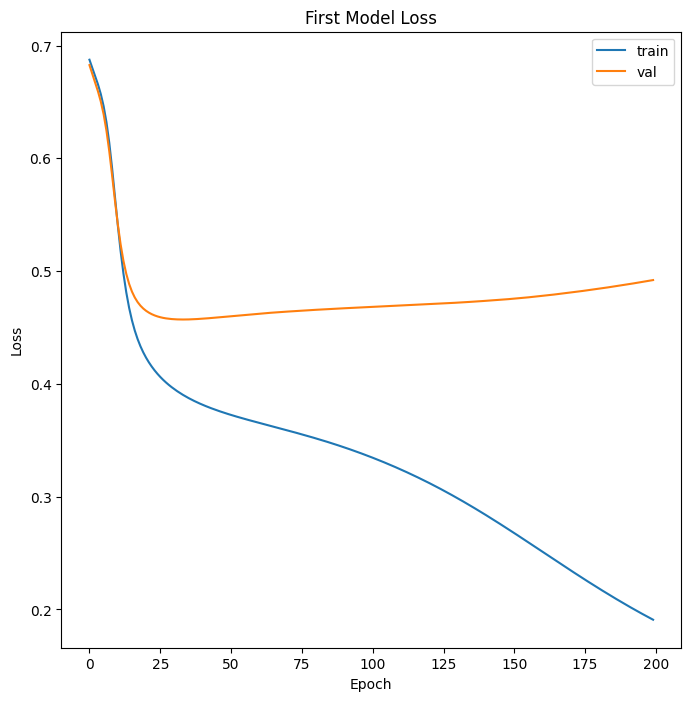

In [24]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8,8))
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('First Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
figure(figsize=(8,8))
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('First Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
model = FFNN(input_dim,hidden_dim_1,hidden_dim_2,output_dim).cuda()

In [26]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

FFNN(
  (layer_1): Linear(in_features=1000, out_features=512, bias=True)
  (relu_1): ReLU()
  (layer_2): Linear(in_features=512, out_features=512, bias=True)
  (relu_2): ReLU()
  (layer_3): Linear(in_features=512, out_features=1, bias=True)
)

In [27]:
#ลองทำนายจากชุดเทส
tfidfX_test = tfidfX_test.to(device)
Y_test = Y_test.to(device)

# Forward pass to get output
model.eval()
test_prediction = model.forward(tfidfX_test.float())
test_prediction = torch.squeeze(test_prediction)

#Calculate accuracy on test set
test_accuracy = calculate_accuracy(Y_test,test_prediction)

print("Test Accuracy:",round(test_accuracy.item(),4), "\n")

Test Accuracy: 0.7704 



In [28]:
#Show the classification report
test_prediction = test_prediction.to(device)
test_prediction = test_prediction.ge(.5).view(-1).cpu()
Y_test = Y_test.cpu()

print(classification_report(Y_test,test_prediction))

              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80      1365
         1.0       0.71      0.74      0.73       956

    accuracy                           0.77      2321
   macro avg       0.76      0.77      0.76      2321
weighted avg       0.77      0.77      0.77      2321



In [29]:
#Show the classification report2
test_prediction = test_prediction.to(device)
test_prediction = test_prediction.ge(.5).view(-1).cpu()
Y_test = Y_test.cpu()

print(classification_report(Y_test,test_prediction))

              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80      1365
         1.0       0.71      0.74      0.73       956

    accuracy                           0.77      2321
   macro avg       0.76      0.77      0.76      2321
weighted avg       0.77      0.77      0.77      2321



In [30]:
report = classification_report(Y_test,test_prediction, output_dict=True)
df = pd.DataFrame(report).transpose()

In [31]:
df

,precision,recall,f1-score,support
0.0,0.813725,0.790476,0.801932,1365.000000
1.0,0.712563,0.741632,0.726807,956.000000
accuracy,0.770358,0.770358,0.770358,0.770358
macro avg,0.763144,0.766054,0.764370,2321.000000
weighted avg,0.772057,0.770358,0.770989,2321.000000


# Thai2fit + Feed Forward Neural Network

จากตัวอย่างก็หน้านี้จะเห็นว่าเราจะให้ TF-IDF ในการแทนข้อความ ถ้าเกิดเราอยากให้การแทนข้อความแบบอื่นเราก็สามารถทำได้อย่างง่ายดาย โดยในส่วนนี้เราจะใช้งาน Pretraine-LM โมเดล Thai2fit กัน เราไม่ได้ fine-tune โมเดลนะครับเราใช้ Word Embedding vector ที่ได้จาก thai2fit มาแทนข้อความ โดยเอา word vector ที่ได้ทั้งหมดมาเฉลี่ยกัน


In [32]:
#แบ่งข้อมูลก่อน
reviews = data['review'].values
labels = data['label'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels,test_size=0.2, random_state=1234)

In [33]:
import torch
from pythainlp.word_vector import WordVector
#import dill as pickle
import pandas as pd


wv = WordVector()
model = wv.get_model()

thai2dict = {}
for word in model.index_to_key:
    thai2dict[word] = model[word]

def thai2fit_sentence_vec(words):
  #เขียนโค้ดเพิ่ม โดยตัดคำและ คำนวณ Word Vec
  #words  =  word_tokenize(text, engine="newmm")
  sum_vec = None
  cnt = 0
  #print(words)
  for w in words:

    if w in thai2dict.keys():
      vec = thai2dict[w]
      #print(vec.shape)

      if sum_vec is  None: #ถ้าเป็น None ให้ set ค่าใหม่
        sum_vec = np.copy(vec)
      else:
        sum_vec += vec   # ให้ บวกเพิ่ม

      cnt+=1

  doc_vec = sum_vec/cnt
  return doc_vec.tolist()


val_size = int(len(test_sentences)/2)
train = list(train_sentences)[:(len(train_sentences)-val_size)]
val = list(train_sentences)[(len(train_sentences)-val_size):]
test = list(test_sentences)
#STOPWORDS = set(stopwords.words('english'))

thai2fitX_train = [thai2fit_sentence_vec(sen.split(" ")) for sen in train]
thai2fitX_val = [thai2fit_sentence_vec(sen.split(" ")) for sen in val]
thai2fitX_test = [thai2fit_sentence_vec(sen.split(" ")) for sen in test]

#ใช้ชุดเทรน ทำ vectorizer
thai2fitX_train = torch.tensor(thai2fitX_train)
thai2fitX_val = torch.tensor(thai2fitX_val)
thai2fitX_test = torch.tensor(thai2fitX_test)

print("Thai2fit train shape:", thai2fitX_train.shape)
print("Thai2fit test shape:", thai2fitX_val.shape)
print("Thai2fit val shape:", thai2fitX_test.shape)

Corpus: thai2fit_wv
- Downloading: thai2fit_wv 0.1


  0%|          | 0/62452646 [00:00<?, ?it/s]

Thai2fit train shape: torch.Size([8120, 300])
Thai2fit test shape: torch.Size([1160, 300])
Thai2fit val shape: torch.Size([2321, 300])


In [34]:
import torch
Y_train = torch.squeeze(torch.tensor(list(train_labels[:(len(train_sentences)-val_size)])+list(neg_labels)*4).float())
Y_val = torch.squeeze(torch.tensor(train_labels[(len(train_sentences)-val_size):]).float())
Y_test = torch.squeeze(torch.tensor(test_labels).float())

print("Y train shape:", Y_train.shape)
print("Y test shape:", Y_val.shape)
print("Y shape:", Y_test.shape)

NameError: name 'neg_labels' is not defined

In [35]:
#สร้าง FFNN_Thai2fit ขึ้นมา
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

class FFNN_Thai2fit(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(FFNN_Thai2fit, self).__init__()

        # Linear function 1
        self.layer_1 = nn.Linear(input_dim, hidden_dim_1)
        # self.dropout = nn.Dropout(0.3)
        # self.batch1 = nn.BatchNorm1d(hidden_dim)

        # Non-linearity 1
        self.relu_1 = nn.ReLU()

        # Linear function 2
        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        # Non-linearity 2
        self.relu_2 = nn.ReLU()

        # Linear function 2
        self.layer_3 = nn.Linear(hidden_dim_1, hidden_dim_2)
        # Non-linearity 2
        self.relu_3 = nn.ReLU()

        # Linear function 4
        self.layer_4 = nn.Linear(hidden_dim_2, output_dim)

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu_1(out)

        out = self.layer_2(out)
        out = self.relu_2(out)

        out = self.layer_3(out)
        out = self.relu_3(out)

        out = self.layer_4(out)

        return torch.sigmoid(out)

In [36]:
# กำหนดจำนวนรอบที่จะเทรน
input_dim = thai2fitX_train.shape[1] #จำนวน Dim ของ input
hidden_dim_1 = 512 #จำนวนโหนด
hidden_dim_2 = 512
output_dim = 1 #จำนวน output dim ใช้ 1 ได้ คือเราอยากจะทำนายค่าออกมาค่าเดียว 0 = negative และ 1 คือ เป็น positive
num_epochs = 500

# สร้าง model จากคลาส
thai2fit_ffnn_model = FFNN_Thai2fit(input_dim,hidden_dim_1,hidden_dim_2,output_dim)

# Define loss function.
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

# Define as optimizer Adam.
optimizer = optim.Adam(thai2fit_ffnn_model.parameters(),lr=0.1e-4,weight_decay=1e-3)

# Transfer all the computation to GPU (cuda device).
thai2fit_ffnn_model.to(device)
criterion = criterion.to(device)

In [37]:
from tqdm import tqdm

# This is a function that calculate the accuracy manually
def calculate_accuracy(y_true, y_pred):
  y_pred = torch.round(y_pred)
  correct = (y_true == y_pred).float()
  acc = correct.sum() / len(correct)
  return acc

batch_size = 16

# Split train dataset to mini batches
X_train_mini_batches = torch.split(thai2fitX_train,batch_size)
Y_train_mini_batches = torch.split(Y_train,batch_size)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Start training
for epoch in range(num_epochs):
  print('epoch',epoch)
  epoch_loss = 0
  epoch_accuracy = 0
  validation_loss=0
  val_accuracy=0

  for X_train_mini_batch,Y_train_mini_batch in tqdm(zip(X_train_mini_batches,Y_train_mini_batches)):

    X_train_mini_batch = X_train_mini_batch.to(device)
    Y_train_mini_batch = Y_train_mini_batch.to(device)

    # Forward pass to get output
    train_prediction = thai2fit_ffnn_model.forward(X_train_mini_batch.float())
    train_prediction = torch.squeeze(train_prediction)

    # Calculate Loss
    train_loss = criterion(train_prediction,Y_train_mini_batch)

    # Clearing up accumulated gradients
    optimizer.zero_grad()

    # Getting gradients
    train_loss.backward()

    # Updating parameters
    optimizer.step()

    # Add each mini batch's loss
    epoch_loss += train_loss.item()

    # Add each mini batch's accuracy
    epoch_accuracy += calculate_accuracy(Y_train_mini_batch,train_prediction)

  # For some epochs print loss and accucary of train and validation set.
  if epoch % 1 == 0:

    tfidfX_val = tfidfX_val.to(device)
    Y_val = Y_val.to(device)

    # Forward pass to get output
    val_prediction = thai2fit_ffnn_model.forward(thai2fitX_val.float())
    val_prediction = torch.squeeze(val_prediction)

    # Calculate Loss
    val_loss = criterion(val_prediction,Y_val)

    # Add each mini batch's loss
    validation_loss = val_loss.item()

    # Add each mini batch's accuracy
    val_accuracy = calculate_accuracy(Y_val,val_prediction)

    epoch_loss /= len(X_train_mini_batches)
    epoch_accuracy /= len(X_train_mini_batches)
    val_losses.append(validation_loss)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    val_accuracies.append(val_accuracy)
    print("Epoch:",epoch, "\n"
           "Train_loss:",round(epoch_loss,4), "Train Accuracy:",round(epoch_accuracy.item(),4), "\n"
           "Validation_loss:  ",round(validation_loss,4), "Validation Accuracy:  ",round(val_accuracy.item(),4), "\n")

epoch 0


508it [00:01, 480.72it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [38]:
from tqdm import tqdm

# This is a function that calculate the accuracy manually
def calculate_accuracy(y_true, y_pred):
  y_pred = torch.round(y_pred)
  correct = (y_true == y_pred).float()
  acc = correct.sum() / len(correct)
  return acc

batch_size = 16

# Split train dataset to mini batches
X_train_mini_batches = torch.split(thai2fitX_train,batch_size)
Y_train_mini_batches = torch.split(Y_train,batch_size)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
min_loss = float('inf')

# Start training
for epoch in range(num_epochs):
  print('epoch',epoch)
  epoch_loss = 0
  epoch_accuracy = 0
  validation_loss=0
  val_accuracy=0

  for X_train_mini_batch,Y_train_mini_batch in tqdm(zip(X_train_mini_batches,Y_train_mini_batches)):

    X_train_mini_batch = X_train_mini_batch.to(device)
    Y_train_mini_batch = Y_train_mini_batch.to(device)

    # Forward pass to get output
    train_prediction = thai2fit_ffnn_model.forward(X_train_mini_batch.float())
    train_prediction = torch.squeeze(train_prediction)

    # Calculate Loss
    train_loss = criterion(train_prediction,Y_train_mini_batch)

    # Clearing up accumulated gradients
    optimizer.zero_grad()

    # Getting gradients
    train_loss.backward()

    # Updating parameters
    optimizer.step()

    # Add each mini batch's loss
    epoch_loss += train_loss.item()

    # Add each mini batch's accuracy
    epoch_accuracy += calculate_accuracy(Y_train_mini_batch,train_prediction)

  # For some epochs print loss and accucary of train and validation set.
  if epoch % 1 == 0:

    tfidfX_val = tfidfX_val.to(device)
    Y_val = Y_val.to(device)

    # Forward pass to get output
    val_prediction = thai2fit_ffnn_model.forward(thai2fitX_val.float().cuda())
    val_prediction = torch.squeeze(val_prediction)

    # Calculate Loss
    val_loss = criterion(val_prediction,Y_val)

    # Add each mini batch's loss
    validation_loss = val_loss.item()

    # Add each mini batch's accuracy
    val_accuracy = calculate_accuracy(Y_val,val_prediction)

    epoch_loss /= len(X_train_mini_batches)
    epoch_accuracy /= len(X_train_mini_batches)
    val_losses.append(validation_loss)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    val_accuracies.append(val_accuracy)
    if validation_loss < min_loss:
      min_loss = validation_loss
      torch.save(thai2fit_ffnn_model.state_dict(), 'best_thai2fit.pt')
      print('save best_model...')
    print("Epoch:",epoch, "\n"
           "Train_loss:",round(epoch_loss,4), "Train Accuracy:",round(epoch_accuracy.item(),4), "\n"
           "Validation_loss:  ",round(validation_loss,4), "Validation Accuracy:  ",round(val_accuracy.item(),4), "\n")

epoch 0


508it [00:01, 507.10it/s]


save best_model...
Epoch: 0 
Train_loss: 0.6157 Train Accuracy: 0.6982 
Validation_loss:   0.5931 Validation Accuracy:   0.6905 

epoch 1


508it [00:01, 430.98it/s]


save best_model...
Epoch: 1 
Train_loss: 0.5874 Train Accuracy: 0.7056 
Validation_loss:   0.5819 Validation Accuracy:   0.7026 

epoch 2


508it [00:01, 421.75it/s]


save best_model...
Epoch: 2 
Train_loss: 0.5766 Train Accuracy: 0.714 
Validation_loss:   0.5746 Validation Accuracy:   0.7026 

epoch 3


508it [00:01, 444.67it/s]


save best_model...
Epoch: 3 
Train_loss: 0.5677 Train Accuracy: 0.7169 
Validation_loss:   0.5671 Validation Accuracy:   0.706 

epoch 4


508it [00:01, 497.94it/s]


save best_model...
Epoch: 4 
Train_loss: 0.559 Train Accuracy: 0.7215 
Validation_loss:   0.5593 Validation Accuracy:   0.7034 

epoch 5


508it [00:01, 488.12it/s]


save best_model...
Epoch: 5 
Train_loss: 0.5505 Train Accuracy: 0.727 
Validation_loss:   0.552 Validation Accuracy:   0.7078 

epoch 6


508it [00:01, 493.63it/s]


save best_model...
Epoch: 6 
Train_loss: 0.5425 Train Accuracy: 0.7328 
Validation_loss:   0.5452 Validation Accuracy:   0.7224 

epoch 7


508it [00:01, 497.23it/s]


save best_model...
Epoch: 7 
Train_loss: 0.5352 Train Accuracy: 0.7345 
Validation_loss:   0.5393 Validation Accuracy:   0.7284 

epoch 8


508it [00:01, 498.81it/s]


save best_model...
Epoch: 8 
Train_loss: 0.5285 Train Accuracy: 0.7409 
Validation_loss:   0.5341 Validation Accuracy:   0.7319 

epoch 9


508it [00:01, 485.02it/s]


save best_model...
Epoch: 9 
Train_loss: 0.5224 Train Accuracy: 0.7453 
Validation_loss:   0.5296 Validation Accuracy:   0.7388 

epoch 10


508it [00:01, 483.38it/s]


save best_model...
Epoch: 10 
Train_loss: 0.5168 Train Accuracy: 0.7475 
Validation_loss:   0.5255 Validation Accuracy:   0.7431 

epoch 11


508it [00:01, 475.85it/s]


save best_model...
Epoch: 11 
Train_loss: 0.5115 Train Accuracy: 0.752 
Validation_loss:   0.5219 Validation Accuracy:   0.7474 

epoch 12


508it [00:01, 475.50it/s]


save best_model...
Epoch: 12 
Train_loss: 0.5065 Train Accuracy: 0.7571 
Validation_loss:   0.5187 Validation Accuracy:   0.7431 

epoch 13


508it [00:01, 404.35it/s]


save best_model...
Epoch: 13 
Train_loss: 0.5017 Train Accuracy: 0.7609 
Validation_loss:   0.5158 Validation Accuracy:   0.7431 

epoch 14


508it [00:01, 406.63it/s]


save best_model...
Epoch: 14 
Train_loss: 0.4972 Train Accuracy: 0.7622 
Validation_loss:   0.5132 Validation Accuracy:   0.7457 

epoch 15


508it [00:01, 470.03it/s]


save best_model...
Epoch: 15 
Train_loss: 0.4928 Train Accuracy: 0.7653 
Validation_loss:   0.5108 Validation Accuracy:   0.7483 

epoch 16


508it [00:01, 472.19it/s]


save best_model...
Epoch: 16 
Train_loss: 0.4886 Train Accuracy: 0.7683 
Validation_loss:   0.5087 Validation Accuracy:   0.75 

epoch 17


508it [00:01, 471.25it/s]


save best_model...
Epoch: 17 
Train_loss: 0.4845 Train Accuracy: 0.7709 
Validation_loss:   0.5068 Validation Accuracy:   0.7543 

epoch 18


508it [00:01, 484.41it/s]


save best_model...
Epoch: 18 
Train_loss: 0.4807 Train Accuracy: 0.7731 
Validation_loss:   0.5051 Validation Accuracy:   0.7586 

epoch 19


508it [00:01, 462.84it/s]


save best_model...
Epoch: 19 
Train_loss: 0.4769 Train Accuracy: 0.7763 
Validation_loss:   0.5035 Validation Accuracy:   0.7586 

epoch 20


508it [00:01, 483.84it/s]


save best_model...
Epoch: 20 
Train_loss: 0.4733 Train Accuracy: 0.7788 
Validation_loss:   0.502 Validation Accuracy:   0.7595 

epoch 21


508it [00:01, 474.67it/s]


save best_model...
Epoch: 21 
Train_loss: 0.4699 Train Accuracy: 0.7821 
Validation_loss:   0.5008 Validation Accuracy:   0.7603 

epoch 22


508it [00:01, 479.06it/s]


save best_model...
Epoch: 22 
Train_loss: 0.4665 Train Accuracy: 0.7837 
Validation_loss:   0.4996 Validation Accuracy:   0.7621 

epoch 23


508it [00:01, 471.61it/s]


save best_model...
Epoch: 23 
Train_loss: 0.4633 Train Accuracy: 0.7844 
Validation_loss:   0.4987 Validation Accuracy:   0.7629 

epoch 24


508it [00:01, 411.33it/s]


save best_model...
Epoch: 24 
Train_loss: 0.4602 Train Accuracy: 0.786 
Validation_loss:   0.4978 Validation Accuracy:   0.7638 

epoch 25


508it [00:01, 401.63it/s]


save best_model...
Epoch: 25 
Train_loss: 0.4571 Train Accuracy: 0.7905 
Validation_loss:   0.497 Validation Accuracy:   0.7672 

epoch 26


508it [00:01, 442.84it/s]


save best_model...
Epoch: 26 
Train_loss: 0.4541 Train Accuracy: 0.7927 
Validation_loss:   0.4963 Validation Accuracy:   0.769 

epoch 27


508it [00:01, 483.88it/s]


save best_model...
Epoch: 27 
Train_loss: 0.4512 Train Accuracy: 0.7952 
Validation_loss:   0.4956 Validation Accuracy:   0.7681 

epoch 28


508it [00:01, 479.67it/s]


save best_model...
Epoch: 28 
Train_loss: 0.4483 Train Accuracy: 0.7961 
Validation_loss:   0.4951 Validation Accuracy:   0.7681 

epoch 29


508it [00:01, 478.84it/s]


save best_model...
Epoch: 29 
Train_loss: 0.4454 Train Accuracy: 0.7981 
Validation_loss:   0.4946 Validation Accuracy:   0.7681 

epoch 30


508it [00:01, 473.87it/s]


save best_model...
Epoch: 30 
Train_loss: 0.4426 Train Accuracy: 0.8001 
Validation_loss:   0.4942 Validation Accuracy:   0.7672 

epoch 31


508it [00:01, 483.99it/s]


save best_model...
Epoch: 31 
Train_loss: 0.4399 Train Accuracy: 0.8014 
Validation_loss:   0.4938 Validation Accuracy:   0.7664 

epoch 32


508it [00:01, 482.81it/s]


save best_model...
Epoch: 32 
Train_loss: 0.4371 Train Accuracy: 0.8025 
Validation_loss:   0.4936 Validation Accuracy:   0.769 

epoch 33


508it [00:01, 483.24it/s]


save best_model...
Epoch: 33 
Train_loss: 0.4344 Train Accuracy: 0.804 
Validation_loss:   0.4933 Validation Accuracy:   0.7724 

epoch 34


508it [00:01, 486.12it/s]


save best_model...
Epoch: 34 
Train_loss: 0.4318 Train Accuracy: 0.8051 
Validation_loss:   0.4932 Validation Accuracy:   0.7741 

epoch 35


508it [00:01, 445.72it/s]


save best_model...
Epoch: 35 
Train_loss: 0.4291 Train Accuracy: 0.8063 
Validation_loss:   0.4931 Validation Accuracy:   0.7733 

epoch 36


508it [00:01, 403.59it/s]


save best_model...
Epoch: 36 
Train_loss: 0.4265 Train Accuracy: 0.8083 
Validation_loss:   0.4931 Validation Accuracy:   0.7741 

epoch 37


508it [00:01, 404.83it/s]


Epoch: 37 
Train_loss: 0.4239 Train Accuracy: 0.8103 
Validation_loss:   0.4931 Validation Accuracy:   0.7698 

epoch 38


508it [00:01, 470.49it/s]


Epoch: 38 
Train_loss: 0.4214 Train Accuracy: 0.8127 
Validation_loss:   0.4932 Validation Accuracy:   0.7681 

epoch 39


508it [00:01, 473.89it/s]


Epoch: 39 
Train_loss: 0.4188 Train Accuracy: 0.8142 
Validation_loss:   0.4933 Validation Accuracy:   0.7681 

epoch 40


508it [00:01, 475.90it/s]


Epoch: 40 
Train_loss: 0.4163 Train Accuracy: 0.8156 
Validation_loss:   0.4935 Validation Accuracy:   0.769 

epoch 41


508it [00:01, 476.02it/s]


Epoch: 41 
Train_loss: 0.4138 Train Accuracy: 0.8177 
Validation_loss:   0.4937 Validation Accuracy:   0.769 

epoch 42


508it [00:01, 475.48it/s]


Epoch: 42 
Train_loss: 0.4113 Train Accuracy: 0.8191 
Validation_loss:   0.4939 Validation Accuracy:   0.769 

epoch 43


508it [00:01, 479.45it/s]


Epoch: 43 
Train_loss: 0.4088 Train Accuracy: 0.821 
Validation_loss:   0.4942 Validation Accuracy:   0.769 

epoch 44


508it [00:01, 474.42it/s]


Epoch: 44 
Train_loss: 0.4063 Train Accuracy: 0.8232 
Validation_loss:   0.4945 Validation Accuracy:   0.7672 

epoch 45


508it [00:01, 481.51it/s]


Epoch: 45 
Train_loss: 0.4038 Train Accuracy: 0.8243 
Validation_loss:   0.4948 Validation Accuracy:   0.769 

epoch 46


508it [00:01, 475.04it/s]


Epoch: 46 
Train_loss: 0.4013 Train Accuracy: 0.8259 
Validation_loss:   0.495 Validation Accuracy:   0.7681 

epoch 47


508it [00:01, 412.67it/s]


Epoch: 47 
Train_loss: 0.3988 Train Accuracy: 0.8274 
Validation_loss:   0.4954 Validation Accuracy:   0.769 

epoch 48


508it [00:01, 395.44it/s]


Epoch: 48 
Train_loss: 0.3963 Train Accuracy: 0.8292 
Validation_loss:   0.4957 Validation Accuracy:   0.7716 

epoch 49


508it [00:01, 469.46it/s]


Epoch: 49 
Train_loss: 0.3938 Train Accuracy: 0.83 
Validation_loss:   0.4961 Validation Accuracy:   0.7716 

epoch 50


508it [00:01, 485.68it/s]


Epoch: 50 
Train_loss: 0.3912 Train Accuracy: 0.8313 
Validation_loss:   0.4965 Validation Accuracy:   0.7733 

epoch 51


508it [00:01, 484.40it/s]


Epoch: 51 
Train_loss: 0.3886 Train Accuracy: 0.8339 
Validation_loss:   0.4968 Validation Accuracy:   0.7733 

epoch 52


508it [00:01, 478.03it/s]


Epoch: 52 
Train_loss: 0.386 Train Accuracy: 0.8353 
Validation_loss:   0.4973 Validation Accuracy:   0.7741 

epoch 53


508it [00:01, 479.78it/s]


Epoch: 53 
Train_loss: 0.3834 Train Accuracy: 0.8367 
Validation_loss:   0.4977 Validation Accuracy:   0.7741 

epoch 54


508it [00:01, 480.30it/s]


Epoch: 54 
Train_loss: 0.3808 Train Accuracy: 0.8376 
Validation_loss:   0.4982 Validation Accuracy:   0.7733 

epoch 55


508it [00:01, 485.31it/s]


Epoch: 55 
Train_loss: 0.3782 Train Accuracy: 0.8391 
Validation_loss:   0.4988 Validation Accuracy:   0.7733 

epoch 56


508it [00:01, 478.69it/s]


Epoch: 56 
Train_loss: 0.3755 Train Accuracy: 0.8406 
Validation_loss:   0.4994 Validation Accuracy:   0.7724 

epoch 57


508it [00:01, 488.17it/s]


Epoch: 57 
Train_loss: 0.3729 Train Accuracy: 0.8415 
Validation_loss:   0.5 Validation Accuracy:   0.7733 

epoch 58


508it [00:01, 442.56it/s]


Epoch: 58 
Train_loss: 0.3702 Train Accuracy: 0.8434 
Validation_loss:   0.5006 Validation Accuracy:   0.7741 

epoch 59


508it [00:01, 412.55it/s]


Epoch: 59 
Train_loss: 0.3674 Train Accuracy: 0.8446 
Validation_loss:   0.5012 Validation Accuracy:   0.7741 

epoch 60


508it [00:01, 424.04it/s]


Epoch: 60 
Train_loss: 0.3647 Train Accuracy: 0.8468 
Validation_loss:   0.5019 Validation Accuracy:   0.7724 

epoch 61


508it [00:01, 489.81it/s]


Epoch: 61 
Train_loss: 0.3619 Train Accuracy: 0.8487 
Validation_loss:   0.5027 Validation Accuracy:   0.7724 

epoch 62


508it [00:01, 488.54it/s]


Epoch: 62 
Train_loss: 0.3591 Train Accuracy: 0.8499 
Validation_loss:   0.5035 Validation Accuracy:   0.7741 

epoch 63


508it [00:01, 488.25it/s]


Epoch: 63 
Train_loss: 0.3563 Train Accuracy: 0.8511 
Validation_loss:   0.5042 Validation Accuracy:   0.7759 

epoch 64


508it [00:01, 478.72it/s]


Epoch: 64 
Train_loss: 0.3535 Train Accuracy: 0.8524 
Validation_loss:   0.5049 Validation Accuracy:   0.7767 

epoch 65


508it [00:01, 486.18it/s]


Epoch: 65 
Train_loss: 0.3506 Train Accuracy: 0.8547 
Validation_loss:   0.5057 Validation Accuracy:   0.7793 

epoch 66


508it [00:01, 488.09it/s]


Epoch: 66 
Train_loss: 0.3477 Train Accuracy: 0.8559 
Validation_loss:   0.5065 Validation Accuracy:   0.7793 

epoch 67


508it [00:01, 487.65it/s]


Epoch: 67 
Train_loss: 0.3448 Train Accuracy: 0.8578 
Validation_loss:   0.5073 Validation Accuracy:   0.7784 

epoch 68


508it [00:01, 475.58it/s]


Epoch: 68 
Train_loss: 0.3418 Train Accuracy: 0.8584 
Validation_loss:   0.5082 Validation Accuracy:   0.7802 

epoch 69


508it [00:01, 476.03it/s]


Epoch: 69 
Train_loss: 0.3389 Train Accuracy: 0.86 
Validation_loss:   0.509 Validation Accuracy:   0.781 

epoch 70


508it [00:01, 408.93it/s]


Epoch: 70 
Train_loss: 0.3359 Train Accuracy: 0.8631 
Validation_loss:   0.51 Validation Accuracy:   0.7802 

epoch 71


508it [00:01, 410.52it/s]


Epoch: 71 
Train_loss: 0.3329 Train Accuracy: 0.8649 
Validation_loss:   0.5111 Validation Accuracy:   0.7784 

epoch 72


508it [00:01, 463.37it/s]


Epoch: 72 
Train_loss: 0.3298 Train Accuracy: 0.8665 
Validation_loss:   0.5122 Validation Accuracy:   0.7802 

epoch 73


508it [00:01, 483.80it/s]


Epoch: 73 
Train_loss: 0.3268 Train Accuracy: 0.8681 
Validation_loss:   0.5133 Validation Accuracy:   0.7819 

epoch 74


508it [00:01, 487.12it/s]


Epoch: 74 
Train_loss: 0.3237 Train Accuracy: 0.8692 
Validation_loss:   0.5144 Validation Accuracy:   0.7793 

epoch 75


508it [00:01, 483.75it/s]


Epoch: 75 
Train_loss: 0.3206 Train Accuracy: 0.8711 
Validation_loss:   0.5154 Validation Accuracy:   0.7793 

epoch 76


508it [00:01, 492.68it/s]


Epoch: 76 
Train_loss: 0.3175 Train Accuracy: 0.8716 
Validation_loss:   0.5166 Validation Accuracy:   0.7793 

epoch 77


508it [00:01, 483.00it/s]


Epoch: 77 
Train_loss: 0.3144 Train Accuracy: 0.8733 
Validation_loss:   0.5178 Validation Accuracy:   0.7793 

epoch 78


508it [00:01, 486.16it/s]


Epoch: 78 
Train_loss: 0.3113 Train Accuracy: 0.8755 
Validation_loss:   0.519 Validation Accuracy:   0.7802 

epoch 79


508it [00:01, 482.94it/s]


Epoch: 79 
Train_loss: 0.3081 Train Accuracy: 0.8777 
Validation_loss:   0.5201 Validation Accuracy:   0.7767 

epoch 80


508it [00:01, 482.79it/s]


Epoch: 80 
Train_loss: 0.3049 Train Accuracy: 0.8794 
Validation_loss:   0.5213 Validation Accuracy:   0.7776 

epoch 81


508it [00:01, 445.06it/s]


Epoch: 81 
Train_loss: 0.3017 Train Accuracy: 0.8807 
Validation_loss:   0.5226 Validation Accuracy:   0.7776 

epoch 82


508it [00:01, 423.12it/s]


Epoch: 82 
Train_loss: 0.2985 Train Accuracy: 0.8825 
Validation_loss:   0.5239 Validation Accuracy:   0.7784 

epoch 83


508it [00:01, 408.20it/s]


Epoch: 83 
Train_loss: 0.2952 Train Accuracy: 0.8844 
Validation_loss:   0.5253 Validation Accuracy:   0.7776 

epoch 84


508it [00:01, 481.36it/s]


Epoch: 84 
Train_loss: 0.2919 Train Accuracy: 0.8862 
Validation_loss:   0.5268 Validation Accuracy:   0.7759 

epoch 85


508it [00:01, 483.77it/s]


Epoch: 85 
Train_loss: 0.2887 Train Accuracy: 0.888 
Validation_loss:   0.5283 Validation Accuracy:   0.7776 

epoch 86


508it [00:01, 481.22it/s]


Epoch: 86 
Train_loss: 0.2854 Train Accuracy: 0.8903 
Validation_loss:   0.5299 Validation Accuracy:   0.7776 

epoch 87


508it [00:01, 482.73it/s]


Epoch: 87 
Train_loss: 0.2821 Train Accuracy: 0.8916 
Validation_loss:   0.5316 Validation Accuracy:   0.7776 

epoch 88


508it [00:01, 486.41it/s]


Epoch: 88 
Train_loss: 0.2787 Train Accuracy: 0.8936 
Validation_loss:   0.5333 Validation Accuracy:   0.7784 

epoch 89


508it [00:01, 491.91it/s]


Epoch: 89 
Train_loss: 0.2754 Train Accuracy: 0.8954 
Validation_loss:   0.5352 Validation Accuracy:   0.7793 

epoch 90


508it [00:01, 489.47it/s]


Epoch: 90 
Train_loss: 0.2722 Train Accuracy: 0.898 
Validation_loss:   0.5371 Validation Accuracy:   0.7776 

epoch 91


508it [00:01, 469.00it/s]


Epoch: 91 
Train_loss: 0.2689 Train Accuracy: 0.9006 
Validation_loss:   0.5391 Validation Accuracy:   0.7759 

epoch 92


508it [00:01, 477.26it/s]


Epoch: 92 
Train_loss: 0.2656 Train Accuracy: 0.9015 
Validation_loss:   0.5411 Validation Accuracy:   0.7759 

epoch 93


508it [00:01, 406.73it/s]


Epoch: 93 
Train_loss: 0.2623 Train Accuracy: 0.9028 
Validation_loss:   0.5433 Validation Accuracy:   0.7741 

epoch 94


508it [00:01, 393.27it/s]


Epoch: 94 
Train_loss: 0.259 Train Accuracy: 0.9039 
Validation_loss:   0.5454 Validation Accuracy:   0.7741 

epoch 95


508it [00:01, 455.11it/s]


Epoch: 95 
Train_loss: 0.2556 Train Accuracy: 0.906 
Validation_loss:   0.5475 Validation Accuracy:   0.7733 

epoch 96


508it [00:01, 482.33it/s]


Epoch: 96 
Train_loss: 0.2524 Train Accuracy: 0.9088 
Validation_loss:   0.5498 Validation Accuracy:   0.7733 

epoch 97


508it [00:01, 477.98it/s]


Epoch: 97 
Train_loss: 0.2491 Train Accuracy: 0.9101 
Validation_loss:   0.5521 Validation Accuracy:   0.7741 

epoch 98


508it [00:01, 482.54it/s]


Epoch: 98 
Train_loss: 0.2459 Train Accuracy: 0.9109 
Validation_loss:   0.5545 Validation Accuracy:   0.7733 

epoch 99


508it [00:01, 489.03it/s]


Epoch: 99 
Train_loss: 0.2426 Train Accuracy: 0.9122 
Validation_loss:   0.5568 Validation Accuracy:   0.7733 

epoch 100


508it [00:01, 486.60it/s]


Epoch: 100 
Train_loss: 0.2394 Train Accuracy: 0.9139 
Validation_loss:   0.5592 Validation Accuracy:   0.7733 

epoch 101


508it [00:01, 478.77it/s]


Epoch: 101 
Train_loss: 0.2362 Train Accuracy: 0.9158 
Validation_loss:   0.5621 Validation Accuracy:   0.7716 

epoch 102


508it [00:01, 475.11it/s]


Epoch: 102 
Train_loss: 0.2331 Train Accuracy: 0.9174 
Validation_loss:   0.5651 Validation Accuracy:   0.769 

epoch 103


508it [00:01, 485.73it/s]


Epoch: 103 
Train_loss: 0.2299 Train Accuracy: 0.9188 
Validation_loss:   0.5681 Validation Accuracy:   0.7681 

epoch 104


508it [00:01, 440.85it/s]


Epoch: 104 
Train_loss: 0.2268 Train Accuracy: 0.9204 
Validation_loss:   0.5709 Validation Accuracy:   0.7681 

epoch 105


508it [00:01, 408.37it/s]


Epoch: 105 
Train_loss: 0.2238 Train Accuracy: 0.9218 
Validation_loss:   0.5737 Validation Accuracy:   0.7655 

epoch 106


508it [00:01, 417.29it/s]


Epoch: 106 
Train_loss: 0.2207 Train Accuracy: 0.923 
Validation_loss:   0.5771 Validation Accuracy:   0.7655 

epoch 107


508it [00:01, 471.00it/s]


Epoch: 107 
Train_loss: 0.2177 Train Accuracy: 0.924 
Validation_loss:   0.5802 Validation Accuracy:   0.7664 

epoch 108


508it [00:01, 484.34it/s]


Epoch: 108 
Train_loss: 0.2148 Train Accuracy: 0.9247 
Validation_loss:   0.583 Validation Accuracy:   0.7647 

epoch 109


508it [00:01, 478.69it/s]


Epoch: 109 
Train_loss: 0.2118 Train Accuracy: 0.9258 
Validation_loss:   0.5863 Validation Accuracy:   0.7621 

epoch 110


508it [00:01, 471.55it/s]


Epoch: 110 
Train_loss: 0.2088 Train Accuracy: 0.9277 
Validation_loss:   0.5895 Validation Accuracy:   0.7638 

epoch 111


508it [00:01, 484.68it/s]


Epoch: 111 
Train_loss: 0.2059 Train Accuracy: 0.9289 
Validation_loss:   0.5929 Validation Accuracy:   0.7586 

epoch 112


508it [00:01, 474.16it/s]


Epoch: 112 
Train_loss: 0.2031 Train Accuracy: 0.9302 
Validation_loss:   0.5963 Validation Accuracy:   0.7595 

epoch 113


508it [00:01, 472.66it/s]


Epoch: 113 
Train_loss: 0.2002 Train Accuracy: 0.9316 
Validation_loss:   0.5998 Validation Accuracy:   0.7595 

epoch 114


508it [00:01, 476.49it/s]


Epoch: 114 
Train_loss: 0.1974 Train Accuracy: 0.9331 
Validation_loss:   0.6029 Validation Accuracy:   0.7612 

epoch 115


508it [00:01, 481.04it/s]


Epoch: 115 
Train_loss: 0.1947 Train Accuracy: 0.9345 
Validation_loss:   0.6062 Validation Accuracy:   0.7629 

epoch 116


508it [00:01, 394.98it/s]


Epoch: 116 
Train_loss: 0.1919 Train Accuracy: 0.935 
Validation_loss:   0.6097 Validation Accuracy:   0.7612 

epoch 117


508it [00:01, 413.94it/s]


Epoch: 117 
Train_loss: 0.1894 Train Accuracy: 0.9361 
Validation_loss:   0.6127 Validation Accuracy:   0.7569 

epoch 118


508it [00:01, 463.61it/s]


Epoch: 118 
Train_loss: 0.1867 Train Accuracy: 0.937 
Validation_loss:   0.616 Validation Accuracy:   0.7586 

epoch 119


508it [00:01, 485.68it/s]


Epoch: 119 
Train_loss: 0.1841 Train Accuracy: 0.9374 
Validation_loss:   0.6196 Validation Accuracy:   0.7578 

epoch 120


508it [00:01, 481.13it/s]


Epoch: 120 
Train_loss: 0.1816 Train Accuracy: 0.9386 
Validation_loss:   0.6226 Validation Accuracy:   0.7595 

epoch 121


508it [00:01, 466.22it/s]


Epoch: 121 
Train_loss: 0.179 Train Accuracy: 0.9392 
Validation_loss:   0.626 Validation Accuracy:   0.7586 

epoch 122


508it [00:01, 479.67it/s]


Epoch: 122 
Train_loss: 0.1765 Train Accuracy: 0.9405 
Validation_loss:   0.6296 Validation Accuracy:   0.7595 

epoch 123


508it [00:01, 482.23it/s]


Epoch: 123 
Train_loss: 0.174 Train Accuracy: 0.9417 
Validation_loss:   0.6327 Validation Accuracy:   0.7595 

epoch 124


508it [00:01, 482.95it/s]


Epoch: 124 
Train_loss: 0.1716 Train Accuracy: 0.9425 
Validation_loss:   0.6368 Validation Accuracy:   0.7586 

epoch 125


508it [00:01, 473.47it/s]


Epoch: 125 
Train_loss: 0.1693 Train Accuracy: 0.944 
Validation_loss:   0.6401 Validation Accuracy:   0.7569 

epoch 126


508it [00:01, 473.37it/s]


Epoch: 126 
Train_loss: 0.167 Train Accuracy: 0.9455 
Validation_loss:   0.6437 Validation Accuracy:   0.7578 

epoch 127


508it [00:01, 430.64it/s]


Epoch: 127 
Train_loss: 0.1647 Train Accuracy: 0.9466 
Validation_loss:   0.6472 Validation Accuracy:   0.7586 

epoch 128


508it [00:01, 399.90it/s]


Epoch: 128 
Train_loss: 0.1625 Train Accuracy: 0.9477 
Validation_loss:   0.6509 Validation Accuracy:   0.7569 

epoch 129


508it [00:01, 431.70it/s]


Epoch: 129 
Train_loss: 0.1603 Train Accuracy: 0.9478 
Validation_loss:   0.6547 Validation Accuracy:   0.7552 

epoch 130


508it [00:01, 478.29it/s]


Epoch: 130 
Train_loss: 0.1582 Train Accuracy: 0.9482 
Validation_loss:   0.6586 Validation Accuracy:   0.7543 

epoch 131


508it [00:01, 482.35it/s]


Epoch: 131 
Train_loss: 0.156 Train Accuracy: 0.9496 
Validation_loss:   0.6623 Validation Accuracy:   0.7543 

epoch 132


508it [00:01, 482.72it/s]


Epoch: 132 
Train_loss: 0.154 Train Accuracy: 0.9502 
Validation_loss:   0.666 Validation Accuracy:   0.7534 

epoch 133


508it [00:01, 483.36it/s]


Epoch: 133 
Train_loss: 0.152 Train Accuracy: 0.951 
Validation_loss:   0.6699 Validation Accuracy:   0.7534 

epoch 134


508it [00:01, 487.67it/s]


Epoch: 134 
Train_loss: 0.1501 Train Accuracy: 0.9515 
Validation_loss:   0.6735 Validation Accuracy:   0.7569 

epoch 135


508it [00:01, 480.11it/s]


Epoch: 135 
Train_loss: 0.1481 Train Accuracy: 0.9519 
Validation_loss:   0.677 Validation Accuracy:   0.7569 

epoch 136


508it [00:01, 469.93it/s]


Epoch: 136 
Train_loss: 0.1462 Train Accuracy: 0.9526 
Validation_loss:   0.6803 Validation Accuracy:   0.7552 

epoch 137


508it [00:01, 485.19it/s]


Epoch: 137 
Train_loss: 0.1444 Train Accuracy: 0.9536 
Validation_loss:   0.6843 Validation Accuracy:   0.7552 

epoch 138


508it [00:01, 454.08it/s]


Epoch: 138 
Train_loss: 0.1426 Train Accuracy: 0.9536 
Validation_loss:   0.6881 Validation Accuracy:   0.756 

epoch 139


508it [00:01, 400.03it/s]


Epoch: 139 
Train_loss: 0.1408 Train Accuracy: 0.955 
Validation_loss:   0.6915 Validation Accuracy:   0.7578 

epoch 140


508it [00:01, 387.42it/s]


Epoch: 140 
Train_loss: 0.1391 Train Accuracy: 0.9558 
Validation_loss:   0.6951 Validation Accuracy:   0.7543 

epoch 141


508it [00:01, 474.18it/s]


Epoch: 141 
Train_loss: 0.1374 Train Accuracy: 0.9571 
Validation_loss:   0.6985 Validation Accuracy:   0.7543 

epoch 142


508it [00:01, 481.44it/s]


Epoch: 142 
Train_loss: 0.1357 Train Accuracy: 0.9577 
Validation_loss:   0.7019 Validation Accuracy:   0.7569 

epoch 143


508it [00:01, 482.07it/s]


Epoch: 143 
Train_loss: 0.1341 Train Accuracy: 0.958 
Validation_loss:   0.7054 Validation Accuracy:   0.7578 

epoch 144


508it [00:01, 473.25it/s]


Epoch: 144 
Train_loss: 0.1325 Train Accuracy: 0.9589 
Validation_loss:   0.7094 Validation Accuracy:   0.7578 

epoch 145


508it [00:01, 473.65it/s]


Epoch: 145 
Train_loss: 0.131 Train Accuracy: 0.9592 
Validation_loss:   0.7124 Validation Accuracy:   0.7578 

epoch 146


508it [00:01, 469.28it/s]


Epoch: 146 
Train_loss: 0.1294 Train Accuracy: 0.96 
Validation_loss:   0.7163 Validation Accuracy:   0.7586 

epoch 147


508it [00:01, 474.91it/s]


Epoch: 147 
Train_loss: 0.128 Train Accuracy: 0.9601 
Validation_loss:   0.7192 Validation Accuracy:   0.7595 

epoch 148


508it [00:01, 446.82it/s]


Epoch: 148 
Train_loss: 0.1265 Train Accuracy: 0.9612 
Validation_loss:   0.7232 Validation Accuracy:   0.7595 

epoch 149


508it [00:01, 472.15it/s]


Epoch: 149 
Train_loss: 0.1251 Train Accuracy: 0.9617 
Validation_loss:   0.7268 Validation Accuracy:   0.7595 

epoch 150


508it [00:01, 392.69it/s]


Epoch: 150 
Train_loss: 0.1238 Train Accuracy: 0.9621 
Validation_loss:   0.7299 Validation Accuracy:   0.7603 

epoch 151


508it [00:01, 403.27it/s]


Epoch: 151 
Train_loss: 0.1224 Train Accuracy: 0.9628 
Validation_loss:   0.7331 Validation Accuracy:   0.7638 

epoch 152


508it [00:01, 446.11it/s]


Epoch: 152 
Train_loss: 0.1211 Train Accuracy: 0.963 
Validation_loss:   0.7366 Validation Accuracy:   0.7603 

epoch 153


508it [00:01, 472.58it/s]


Epoch: 153 
Train_loss: 0.1198 Train Accuracy: 0.9637 
Validation_loss:   0.7397 Validation Accuracy:   0.7595 

epoch 154


508it [00:01, 465.76it/s]


Epoch: 154 
Train_loss: 0.1186 Train Accuracy: 0.9644 
Validation_loss:   0.7425 Validation Accuracy:   0.7595 

epoch 155


508it [00:01, 475.76it/s]


Epoch: 155 
Train_loss: 0.1174 Train Accuracy: 0.9647 
Validation_loss:   0.7456 Validation Accuracy:   0.7569 

epoch 156


508it [00:01, 469.81it/s]


Epoch: 156 
Train_loss: 0.1163 Train Accuracy: 0.9648 
Validation_loss:   0.7485 Validation Accuracy:   0.7603 

epoch 157


508it [00:01, 471.78it/s]


Epoch: 157 
Train_loss: 0.1151 Train Accuracy: 0.9652 
Validation_loss:   0.7517 Validation Accuracy:   0.7621 

epoch 158


508it [00:01, 469.75it/s]


Epoch: 158 
Train_loss: 0.114 Train Accuracy: 0.9659 
Validation_loss:   0.7549 Validation Accuracy:   0.7603 

epoch 159


508it [00:01, 473.57it/s]


Epoch: 159 
Train_loss: 0.1129 Train Accuracy: 0.9664 
Validation_loss:   0.7586 Validation Accuracy:   0.7595 

epoch 160


508it [00:01, 475.81it/s]


Epoch: 160 
Train_loss: 0.1119 Train Accuracy: 0.9663 
Validation_loss:   0.7609 Validation Accuracy:   0.7586 

epoch 161


508it [00:01, 410.32it/s]


Epoch: 161 
Train_loss: 0.1109 Train Accuracy: 0.9667 
Validation_loss:   0.7639 Validation Accuracy:   0.7612 

epoch 162


508it [00:01, 395.66it/s]


Epoch: 162 
Train_loss: 0.1099 Train Accuracy: 0.9673 
Validation_loss:   0.7668 Validation Accuracy:   0.7569 

epoch 163


508it [00:01, 418.69it/s]


Epoch: 163 
Train_loss: 0.109 Train Accuracy: 0.9674 
Validation_loss:   0.7688 Validation Accuracy:   0.7612 

epoch 164


508it [00:01, 467.29it/s]


Epoch: 164 
Train_loss: 0.1081 Train Accuracy: 0.9676 
Validation_loss:   0.7717 Validation Accuracy:   0.7578 

epoch 165


508it [00:01, 467.01it/s]


Epoch: 165 
Train_loss: 0.1072 Train Accuracy: 0.9676 
Validation_loss:   0.7743 Validation Accuracy:   0.7612 

epoch 166


508it [00:01, 466.67it/s]


Epoch: 166 
Train_loss: 0.1063 Train Accuracy: 0.9676 
Validation_loss:   0.776 Validation Accuracy:   0.7612 

epoch 167


508it [00:01, 468.77it/s]


Epoch: 167 
Train_loss: 0.1054 Train Accuracy: 0.9681 
Validation_loss:   0.7792 Validation Accuracy:   0.7586 

epoch 168


508it [00:01, 472.21it/s]


Epoch: 168 
Train_loss: 0.1046 Train Accuracy: 0.9681 
Validation_loss:   0.7818 Validation Accuracy:   0.7569 

epoch 169


508it [00:01, 471.72it/s]


Epoch: 169 
Train_loss: 0.1039 Train Accuracy: 0.968 
Validation_loss:   0.784 Validation Accuracy:   0.7586 

epoch 170


508it [00:01, 471.73it/s]


Epoch: 170 
Train_loss: 0.103 Train Accuracy: 0.9685 
Validation_loss:   0.7861 Validation Accuracy:   0.7543 

epoch 171


508it [00:01, 473.60it/s]


Epoch: 171 
Train_loss: 0.1023 Train Accuracy: 0.9685 
Validation_loss:   0.7881 Validation Accuracy:   0.7578 

epoch 172


508it [00:01, 438.38it/s]


Epoch: 172 
Train_loss: 0.1015 Train Accuracy: 0.9686 
Validation_loss:   0.7903 Validation Accuracy:   0.756 

epoch 173


508it [00:01, 400.90it/s]


Epoch: 173 
Train_loss: 0.1008 Train Accuracy: 0.9689 
Validation_loss:   0.7925 Validation Accuracy:   0.7586 

epoch 174


508it [00:01, 403.57it/s]


Epoch: 174 
Train_loss: 0.1001 Train Accuracy: 0.9686 
Validation_loss:   0.7951 Validation Accuracy:   0.7595 

epoch 175


508it [00:01, 464.59it/s]


Epoch: 175 
Train_loss: 0.0995 Train Accuracy: 0.9684 
Validation_loss:   0.7965 Validation Accuracy:   0.7578 

epoch 176


508it [00:01, 464.22it/s]


Epoch: 176 
Train_loss: 0.0988 Train Accuracy: 0.9685 
Validation_loss:   0.7983 Validation Accuracy:   0.7586 

epoch 177


508it [00:01, 471.83it/s]


Epoch: 177 
Train_loss: 0.0982 Train Accuracy: 0.9688 
Validation_loss:   0.8012 Validation Accuracy:   0.7586 

epoch 178


508it [00:01, 470.91it/s]


Epoch: 178 
Train_loss: 0.0976 Train Accuracy: 0.9688 
Validation_loss:   0.8019 Validation Accuracy:   0.7612 

epoch 179


508it [00:01, 466.49it/s]


Epoch: 179 
Train_loss: 0.097 Train Accuracy: 0.9689 
Validation_loss:   0.8046 Validation Accuracy:   0.7612 

epoch 180


508it [00:01, 469.19it/s]


Epoch: 180 
Train_loss: 0.0964 Train Accuracy: 0.9688 
Validation_loss:   0.8061 Validation Accuracy:   0.7629 

epoch 181


508it [00:01, 477.65it/s]


Epoch: 181 
Train_loss: 0.0958 Train Accuracy: 0.9689 
Validation_loss:   0.8082 Validation Accuracy:   0.7629 

epoch 182


508it [00:01, 472.50it/s]


Epoch: 182 
Train_loss: 0.0953 Train Accuracy: 0.9688 
Validation_loss:   0.8109 Validation Accuracy:   0.7603 

epoch 183


508it [00:01, 455.41it/s]


Epoch: 183 
Train_loss: 0.0947 Train Accuracy: 0.9689 
Validation_loss:   0.8116 Validation Accuracy:   0.7621 

epoch 184


508it [00:01, 403.96it/s]


Epoch: 184 
Train_loss: 0.0942 Train Accuracy: 0.969 
Validation_loss:   0.8134 Validation Accuracy:   0.7586 

epoch 185


508it [00:01, 403.46it/s]


Epoch: 185 
Train_loss: 0.0937 Train Accuracy: 0.9692 
Validation_loss:   0.8145 Validation Accuracy:   0.7586 

epoch 186


508it [00:01, 469.53it/s]


Epoch: 186 
Train_loss: 0.0932 Train Accuracy: 0.9694 
Validation_loss:   0.8162 Validation Accuracy:   0.7595 

epoch 187


508it [00:01, 481.73it/s]


Epoch: 187 
Train_loss: 0.0927 Train Accuracy: 0.9692 
Validation_loss:   0.8171 Validation Accuracy:   0.7612 

epoch 188


508it [00:01, 475.07it/s]


Epoch: 188 
Train_loss: 0.0922 Train Accuracy: 0.9697 
Validation_loss:   0.8199 Validation Accuracy:   0.7552 

epoch 189


508it [00:01, 483.08it/s]


Epoch: 189 
Train_loss: 0.0918 Train Accuracy: 0.9702 
Validation_loss:   0.8198 Validation Accuracy:   0.7595 

epoch 190


508it [00:01, 477.06it/s]


Epoch: 190 
Train_loss: 0.0914 Train Accuracy: 0.9706 
Validation_loss:   0.8224 Validation Accuracy:   0.7586 

epoch 191


508it [00:01, 471.73it/s]


Epoch: 191 
Train_loss: 0.0909 Train Accuracy: 0.9707 
Validation_loss:   0.8232 Validation Accuracy:   0.7595 

epoch 192


508it [00:01, 466.23it/s]


Epoch: 192 
Train_loss: 0.0905 Train Accuracy: 0.9708 
Validation_loss:   0.8243 Validation Accuracy:   0.7586 

epoch 193


508it [00:01, 469.45it/s]


Epoch: 193 
Train_loss: 0.0901 Train Accuracy: 0.9711 
Validation_loss:   0.8255 Validation Accuracy:   0.7595 

epoch 194


508it [00:01, 476.84it/s]


Epoch: 194 
Train_loss: 0.0897 Train Accuracy: 0.9713 
Validation_loss:   0.827 Validation Accuracy:   0.7595 

epoch 195


508it [00:01, 418.81it/s]


Epoch: 195 
Train_loss: 0.0893 Train Accuracy: 0.9712 
Validation_loss:   0.8274 Validation Accuracy:   0.7595 

epoch 196


508it [00:01, 408.38it/s]


Epoch: 196 
Train_loss: 0.089 Train Accuracy: 0.971 
Validation_loss:   0.8288 Validation Accuracy:   0.7595 

epoch 197


508it [00:01, 424.94it/s]


Epoch: 197 
Train_loss: 0.0886 Train Accuracy: 0.9711 
Validation_loss:   0.8292 Validation Accuracy:   0.7603 

epoch 198


508it [00:01, 475.26it/s]


Epoch: 198 
Train_loss: 0.0882 Train Accuracy: 0.9711 
Validation_loss:   0.8308 Validation Accuracy:   0.7595 

epoch 199


508it [00:01, 468.03it/s]


Epoch: 199 
Train_loss: 0.0879 Train Accuracy: 0.9715 
Validation_loss:   0.8319 Validation Accuracy:   0.7595 

epoch 200


508it [00:01, 475.33it/s]


Epoch: 200 
Train_loss: 0.0876 Train Accuracy: 0.9715 
Validation_loss:   0.8321 Validation Accuracy:   0.7603 

epoch 201


508it [00:01, 467.93it/s]


Epoch: 201 
Train_loss: 0.0873 Train Accuracy: 0.9718 
Validation_loss:   0.8333 Validation Accuracy:   0.7603 

epoch 202


508it [00:01, 466.25it/s]


Epoch: 202 
Train_loss: 0.087 Train Accuracy: 0.9715 
Validation_loss:   0.8342 Validation Accuracy:   0.7595 

epoch 203


508it [00:01, 473.05it/s]


Epoch: 203 
Train_loss: 0.0867 Train Accuracy: 0.9715 
Validation_loss:   0.835 Validation Accuracy:   0.7595 

epoch 204


508it [00:01, 479.25it/s]


Epoch: 204 
Train_loss: 0.0865 Train Accuracy: 0.9718 
Validation_loss:   0.8366 Validation Accuracy:   0.7595 

epoch 205


508it [00:01, 479.79it/s]


Epoch: 205 
Train_loss: 0.0862 Train Accuracy: 0.9717 
Validation_loss:   0.8371 Validation Accuracy:   0.7595 

epoch 206


508it [00:01, 446.98it/s]


Epoch: 206 
Train_loss: 0.0859 Train Accuracy: 0.9718 
Validation_loss:   0.8374 Validation Accuracy:   0.7578 

epoch 207


508it [00:01, 391.15it/s]


Epoch: 207 
Train_loss: 0.0857 Train Accuracy: 0.9719 
Validation_loss:   0.8376 Validation Accuracy:   0.7595 

epoch 208


508it [00:01, 406.96it/s]


Epoch: 208 
Train_loss: 0.0854 Train Accuracy: 0.9721 
Validation_loss:   0.8394 Validation Accuracy:   0.7603 

epoch 209


508it [00:01, 479.39it/s]


Epoch: 209 
Train_loss: 0.0852 Train Accuracy: 0.9723 
Validation_loss:   0.8393 Validation Accuracy:   0.7612 

epoch 210


508it [00:01, 476.43it/s]


Epoch: 210 
Train_loss: 0.085 Train Accuracy: 0.9722 
Validation_loss:   0.8395 Validation Accuracy:   0.7629 

epoch 211


508it [00:01, 479.18it/s]


Epoch: 211 
Train_loss: 0.0848 Train Accuracy: 0.9721 
Validation_loss:   0.8412 Validation Accuracy:   0.7595 

epoch 212


508it [00:01, 472.01it/s]


Epoch: 212 
Train_loss: 0.0846 Train Accuracy: 0.9723 
Validation_loss:   0.8417 Validation Accuracy:   0.7621 

epoch 213


508it [00:01, 475.35it/s]


Epoch: 213 
Train_loss: 0.0844 Train Accuracy: 0.9721 
Validation_loss:   0.8422 Validation Accuracy:   0.7595 

epoch 214


508it [00:01, 479.32it/s]


Epoch: 214 
Train_loss: 0.0841 Train Accuracy: 0.9723 
Validation_loss:   0.842 Validation Accuracy:   0.7621 

epoch 215


508it [00:01, 472.58it/s]


Epoch: 215 
Train_loss: 0.0839 Train Accuracy: 0.9723 
Validation_loss:   0.8427 Validation Accuracy:   0.7621 

epoch 216


508it [00:01, 478.16it/s]


Epoch: 216 
Train_loss: 0.0838 Train Accuracy: 0.9722 
Validation_loss:   0.8423 Validation Accuracy:   0.7612 

epoch 217


508it [00:01, 469.78it/s]


Epoch: 217 
Train_loss: 0.0835 Train Accuracy: 0.9726 
Validation_loss:   0.8428 Validation Accuracy:   0.7629 

epoch 218


508it [00:01, 395.30it/s]


Epoch: 218 
Train_loss: 0.0834 Train Accuracy: 0.9724 
Validation_loss:   0.8431 Validation Accuracy:   0.7621 

epoch 219


508it [00:01, 405.33it/s]


Epoch: 219 
Train_loss: 0.0832 Train Accuracy: 0.9726 
Validation_loss:   0.8434 Validation Accuracy:   0.7629 

epoch 220


508it [00:01, 455.21it/s]


Epoch: 220 
Train_loss: 0.0829 Train Accuracy: 0.9724 
Validation_loss:   0.8442 Validation Accuracy:   0.7612 

epoch 221


508it [00:01, 478.72it/s]


Epoch: 221 
Train_loss: 0.0828 Train Accuracy: 0.9724 
Validation_loss:   0.8442 Validation Accuracy:   0.7603 

epoch 222


508it [00:01, 477.10it/s]


Epoch: 222 
Train_loss: 0.0826 Train Accuracy: 0.9727 
Validation_loss:   0.8443 Validation Accuracy:   0.7621 

epoch 223


508it [00:01, 480.04it/s]


Epoch: 223 
Train_loss: 0.0824 Train Accuracy: 0.9724 
Validation_loss:   0.845 Validation Accuracy:   0.7621 

epoch 224


508it [00:01, 478.19it/s]


Epoch: 224 
Train_loss: 0.0823 Train Accuracy: 0.9727 
Validation_loss:   0.8445 Validation Accuracy:   0.7629 

epoch 225


508it [00:01, 482.93it/s]


Epoch: 225 
Train_loss: 0.0821 Train Accuracy: 0.9727 
Validation_loss:   0.8454 Validation Accuracy:   0.7629 

epoch 226


508it [00:01, 472.09it/s]


Epoch: 226 
Train_loss: 0.082 Train Accuracy: 0.9727 
Validation_loss:   0.8458 Validation Accuracy:   0.7647 

epoch 227


508it [00:01, 467.14it/s]


Epoch: 227 
Train_loss: 0.0818 Train Accuracy: 0.9729 
Validation_loss:   0.8457 Validation Accuracy:   0.7629 

epoch 228


508it [00:01, 473.04it/s]


Epoch: 228 
Train_loss: 0.0817 Train Accuracy: 0.9731 
Validation_loss:   0.8461 Validation Accuracy:   0.7621 

epoch 229


508it [00:01, 413.70it/s]


Epoch: 229 
Train_loss: 0.0816 Train Accuracy: 0.9732 
Validation_loss:   0.8458 Validation Accuracy:   0.7629 

epoch 230


508it [00:01, 400.83it/s]


Epoch: 230 
Train_loss: 0.0815 Train Accuracy: 0.9737 
Validation_loss:   0.8461 Validation Accuracy:   0.7629 

epoch 231


508it [00:01, 421.81it/s]


Epoch: 231 
Train_loss: 0.0812 Train Accuracy: 0.9733 
Validation_loss:   0.8463 Validation Accuracy:   0.7621 

epoch 232


508it [00:01, 479.90it/s]


Epoch: 232 
Train_loss: 0.0811 Train Accuracy: 0.9733 
Validation_loss:   0.8478 Validation Accuracy:   0.7638 

epoch 233


508it [00:01, 479.31it/s]


Epoch: 233 
Train_loss: 0.081 Train Accuracy: 0.9733 
Validation_loss:   0.8466 Validation Accuracy:   0.7629 

epoch 234


508it [00:01, 477.22it/s]


Epoch: 234 
Train_loss: 0.0807 Train Accuracy: 0.9737 
Validation_loss:   0.8482 Validation Accuracy:   0.7621 

epoch 235


508it [00:01, 475.70it/s]


Epoch: 235 
Train_loss: 0.0806 Train Accuracy: 0.9735 
Validation_loss:   0.847 Validation Accuracy:   0.7638 

epoch 236


508it [00:01, 475.04it/s]


Epoch: 236 
Train_loss: 0.0804 Train Accuracy: 0.9738 
Validation_loss:   0.8467 Validation Accuracy:   0.7647 

epoch 237


508it [00:01, 473.34it/s]


Epoch: 237 
Train_loss: 0.0803 Train Accuracy: 0.9738 
Validation_loss:   0.8478 Validation Accuracy:   0.7629 

epoch 238


508it [00:01, 474.87it/s]


Epoch: 238 
Train_loss: 0.0802 Train Accuracy: 0.9737 
Validation_loss:   0.8482 Validation Accuracy:   0.7621 

epoch 239


508it [00:01, 474.71it/s]


Epoch: 239 
Train_loss: 0.08 Train Accuracy: 0.9738 
Validation_loss:   0.8477 Validation Accuracy:   0.7629 

epoch 240


508it [00:01, 453.83it/s]


Epoch: 240 
Train_loss: 0.0798 Train Accuracy: 0.9738 
Validation_loss:   0.8484 Validation Accuracy:   0.7629 

epoch 241


508it [00:01, 398.92it/s]


Epoch: 241 
Train_loss: 0.0797 Train Accuracy: 0.9738 
Validation_loss:   0.848 Validation Accuracy:   0.7629 

epoch 242


508it [00:01, 382.96it/s]


Epoch: 242 
Train_loss: 0.0796 Train Accuracy: 0.9738 
Validation_loss:   0.8491 Validation Accuracy:   0.7638 

epoch 243


508it [00:01, 476.01it/s]


Epoch: 243 
Train_loss: 0.0794 Train Accuracy: 0.9739 
Validation_loss:   0.8482 Validation Accuracy:   0.7638 

epoch 244


508it [00:01, 480.25it/s]


Epoch: 244 
Train_loss: 0.0794 Train Accuracy: 0.9738 
Validation_loss:   0.8478 Validation Accuracy:   0.7629 

epoch 245


508it [00:01, 474.53it/s]


Epoch: 245 
Train_loss: 0.0792 Train Accuracy: 0.9742 
Validation_loss:   0.8484 Validation Accuracy:   0.7638 

epoch 246


508it [00:01, 473.21it/s]


Epoch: 246 
Train_loss: 0.0791 Train Accuracy: 0.9738 
Validation_loss:   0.8477 Validation Accuracy:   0.7647 

epoch 247


508it [00:01, 476.90it/s]


Epoch: 247 
Train_loss: 0.079 Train Accuracy: 0.9737 
Validation_loss:   0.848 Validation Accuracy:   0.7664 

epoch 248


508it [00:01, 472.85it/s]


Epoch: 248 
Train_loss: 0.0788 Train Accuracy: 0.9738 
Validation_loss:   0.8458 Validation Accuracy:   0.7638 

epoch 249


508it [00:01, 469.46it/s]


Epoch: 249 
Train_loss: 0.0787 Train Accuracy: 0.9737 
Validation_loss:   0.8469 Validation Accuracy:   0.7638 

epoch 250


508it [00:01, 477.41it/s]


Epoch: 250 
Train_loss: 0.0785 Train Accuracy: 0.9733 
Validation_loss:   0.8462 Validation Accuracy:   0.7647 

epoch 251


508it [00:01, 478.37it/s]


Epoch: 251 
Train_loss: 0.0785 Train Accuracy: 0.9732 
Validation_loss:   0.8437 Validation Accuracy:   0.7638 

epoch 252


508it [00:01, 428.44it/s]


Epoch: 252 
Train_loss: 0.0784 Train Accuracy: 0.9735 
Validation_loss:   0.8433 Validation Accuracy:   0.7621 

epoch 253


508it [00:01, 398.27it/s]


Epoch: 253 
Train_loss: 0.0782 Train Accuracy: 0.9735 
Validation_loss:   0.844 Validation Accuracy:   0.7655 

epoch 254


508it [00:01, 438.23it/s]


Epoch: 254 
Train_loss: 0.0781 Train Accuracy: 0.9737 
Validation_loss:   0.8435 Validation Accuracy:   0.7672 

epoch 255


508it [00:01, 462.12it/s]


Epoch: 255 
Train_loss: 0.078 Train Accuracy: 0.9734 
Validation_loss:   0.841 Validation Accuracy:   0.7681 

epoch 256


508it [00:01, 469.13it/s]


Epoch: 256 
Train_loss: 0.078 Train Accuracy: 0.9735 
Validation_loss:   0.8427 Validation Accuracy:   0.7664 

epoch 257


508it [00:01, 476.84it/s]


Epoch: 257 
Train_loss: 0.0778 Train Accuracy: 0.9733 
Validation_loss:   0.8412 Validation Accuracy:   0.769 

epoch 258


508it [00:01, 473.12it/s]


Epoch: 258 
Train_loss: 0.0777 Train Accuracy: 0.9735 
Validation_loss:   0.8405 Validation Accuracy:   0.7698 

epoch 259


508it [00:01, 471.56it/s]


Epoch: 259 
Train_loss: 0.0775 Train Accuracy: 0.9737 
Validation_loss:   0.8419 Validation Accuracy:   0.7672 

epoch 260


508it [00:01, 477.95it/s]


Epoch: 260 
Train_loss: 0.0775 Train Accuracy: 0.9737 
Validation_loss:   0.8407 Validation Accuracy:   0.7672 

epoch 261


508it [00:01, 477.74it/s]


Epoch: 261 
Train_loss: 0.0775 Train Accuracy: 0.9738 
Validation_loss:   0.8399 Validation Accuracy:   0.7724 

epoch 262


508it [00:01, 474.79it/s]


Epoch: 262 
Train_loss: 0.0772 Train Accuracy: 0.9737 
Validation_loss:   0.8405 Validation Accuracy:   0.7664 

epoch 263


508it [00:01, 434.24it/s]


Epoch: 263 
Train_loss: 0.0773 Train Accuracy: 0.9738 
Validation_loss:   0.8392 Validation Accuracy:   0.7698 

epoch 264


508it [00:01, 403.44it/s]


Epoch: 264 
Train_loss: 0.077 Train Accuracy: 0.9738 
Validation_loss:   0.839 Validation Accuracy:   0.7716 

epoch 265


508it [00:01, 408.36it/s]


Epoch: 265 
Train_loss: 0.077 Train Accuracy: 0.9737 
Validation_loss:   0.8401 Validation Accuracy:   0.7698 

epoch 266


508it [00:01, 485.14it/s]


Epoch: 266 
Train_loss: 0.0768 Train Accuracy: 0.9738 
Validation_loss:   0.8399 Validation Accuracy:   0.7707 

epoch 267


508it [00:01, 482.41it/s]


Epoch: 267 
Train_loss: 0.0767 Train Accuracy: 0.9737 
Validation_loss:   0.8403 Validation Accuracy:   0.7655 

epoch 268


508it [00:01, 444.83it/s]


Epoch: 268 
Train_loss: 0.0766 Train Accuracy: 0.9737 
Validation_loss:   0.8399 Validation Accuracy:   0.7698 

epoch 269


508it [00:01, 262.03it/s]


Epoch: 269 
Train_loss: 0.0764 Train Accuracy: 0.9739 
Validation_loss:   0.8385 Validation Accuracy:   0.7672 

epoch 270


508it [00:02, 247.61it/s]


Epoch: 270 
Train_loss: 0.0765 Train Accuracy: 0.974 
Validation_loss:   0.8401 Validation Accuracy:   0.7681 

epoch 271


508it [00:01, 257.26it/s]


Epoch: 271 
Train_loss: 0.0763 Train Accuracy: 0.9739 
Validation_loss:   0.8394 Validation Accuracy:   0.7672 

epoch 272


508it [00:01, 409.51it/s]


Epoch: 272 
Train_loss: 0.0762 Train Accuracy: 0.9738 
Validation_loss:   0.8397 Validation Accuracy:   0.7698 

epoch 273


508it [00:01, 397.16it/s]


Epoch: 273 
Train_loss: 0.0762 Train Accuracy: 0.9738 
Validation_loss:   0.8382 Validation Accuracy:   0.7707 

epoch 274


508it [00:01, 431.06it/s]


Epoch: 274 
Train_loss: 0.076 Train Accuracy: 0.974 
Validation_loss:   0.8397 Validation Accuracy:   0.769 

epoch 275


508it [00:01, 479.29it/s]


Epoch: 275 
Train_loss: 0.0761 Train Accuracy: 0.9739 
Validation_loss:   0.8389 Validation Accuracy:   0.7698 

epoch 276


508it [00:01, 489.92it/s]


Epoch: 276 
Train_loss: 0.0759 Train Accuracy: 0.9739 
Validation_loss:   0.8386 Validation Accuracy:   0.7681 

epoch 277


508it [00:01, 484.04it/s]


Epoch: 277 
Train_loss: 0.0758 Train Accuracy: 0.9738 
Validation_loss:   0.8386 Validation Accuracy:   0.769 

epoch 278


508it [00:01, 471.26it/s]


Epoch: 278 
Train_loss: 0.0757 Train Accuracy: 0.9739 
Validation_loss:   0.8379 Validation Accuracy:   0.7672 

epoch 279


508it [00:01, 470.06it/s]


Epoch: 279 
Train_loss: 0.0755 Train Accuracy: 0.974 
Validation_loss:   0.8373 Validation Accuracy:   0.769 

epoch 280


508it [00:01, 469.53it/s]


Epoch: 280 
Train_loss: 0.0756 Train Accuracy: 0.974 
Validation_loss:   0.8392 Validation Accuracy:   0.7681 

epoch 281


508it [00:01, 467.10it/s]


Epoch: 281 
Train_loss: 0.0754 Train Accuracy: 0.9739 
Validation_loss:   0.8378 Validation Accuracy:   0.7672 

epoch 282


508it [00:01, 473.23it/s]


Epoch: 282 
Train_loss: 0.0754 Train Accuracy: 0.9742 
Validation_loss:   0.8372 Validation Accuracy:   0.7698 

epoch 283


508it [00:01, 423.54it/s]


Epoch: 283 
Train_loss: 0.0753 Train Accuracy: 0.9742 
Validation_loss:   0.8381 Validation Accuracy:   0.7681 

epoch 284


508it [00:01, 389.28it/s]


Epoch: 284 
Train_loss: 0.0753 Train Accuracy: 0.974 
Validation_loss:   0.8382 Validation Accuracy:   0.769 

epoch 285


508it [00:01, 403.65it/s]


Epoch: 285 
Train_loss: 0.0752 Train Accuracy: 0.9742 
Validation_loss:   0.8381 Validation Accuracy:   0.7664 

epoch 286


508it [00:01, 467.00it/s]


Epoch: 286 
Train_loss: 0.0751 Train Accuracy: 0.974 
Validation_loss:   0.8365 Validation Accuracy:   0.7698 

epoch 287


508it [00:01, 463.07it/s]


Epoch: 287 
Train_loss: 0.0749 Train Accuracy: 0.9742 
Validation_loss:   0.8366 Validation Accuracy:   0.7672 

epoch 288


508it [00:01, 471.45it/s]


Epoch: 288 
Train_loss: 0.075 Train Accuracy: 0.9743 
Validation_loss:   0.8363 Validation Accuracy:   0.7681 

epoch 289


508it [00:01, 463.50it/s]


Epoch: 289 
Train_loss: 0.0749 Train Accuracy: 0.9745 
Validation_loss:   0.8375 Validation Accuracy:   0.7707 

epoch 290


508it [00:01, 470.51it/s]


Epoch: 290 
Train_loss: 0.0747 Train Accuracy: 0.9744 
Validation_loss:   0.8371 Validation Accuracy:   0.7707 

epoch 291


508it [00:01, 468.86it/s]


Epoch: 291 
Train_loss: 0.0747 Train Accuracy: 0.9745 
Validation_loss:   0.8361 Validation Accuracy:   0.7681 

epoch 292


508it [00:01, 466.78it/s]


Epoch: 292 
Train_loss: 0.0747 Train Accuracy: 0.9745 
Validation_loss:   0.8363 Validation Accuracy:   0.7698 

epoch 293


508it [00:01, 449.67it/s]


Epoch: 293 
Train_loss: 0.0745 Train Accuracy: 0.9744 
Validation_loss:   0.8368 Validation Accuracy:   0.7681 

epoch 294


508it [00:01, 443.14it/s]


Epoch: 294 
Train_loss: 0.0745 Train Accuracy: 0.9747 
Validation_loss:   0.8365 Validation Accuracy:   0.7672 

epoch 295


508it [00:01, 387.47it/s]


Epoch: 295 
Train_loss: 0.0745 Train Accuracy: 0.9747 
Validation_loss:   0.8357 Validation Accuracy:   0.7672 

epoch 296


508it [00:01, 387.58it/s]


Epoch: 296 
Train_loss: 0.0743 Train Accuracy: 0.9747 
Validation_loss:   0.8367 Validation Accuracy:   0.7698 

epoch 297


508it [00:01, 463.71it/s]


Epoch: 297 
Train_loss: 0.0744 Train Accuracy: 0.9748 
Validation_loss:   0.8352 Validation Accuracy:   0.7681 

epoch 298


508it [00:01, 471.86it/s]


Epoch: 298 
Train_loss: 0.0743 Train Accuracy: 0.975 
Validation_loss:   0.8358 Validation Accuracy:   0.7672 

epoch 299


508it [00:01, 476.60it/s]


Epoch: 299 
Train_loss: 0.0742 Train Accuracy: 0.975 
Validation_loss:   0.8352 Validation Accuracy:   0.7681 

epoch 300


508it [00:01, 471.21it/s]


Epoch: 300 
Train_loss: 0.074 Train Accuracy: 0.9747 
Validation_loss:   0.836 Validation Accuracy:   0.769 

epoch 301


508it [00:01, 476.31it/s]


Epoch: 301 
Train_loss: 0.074 Train Accuracy: 0.975 
Validation_loss:   0.8345 Validation Accuracy:   0.7647 

epoch 302


508it [00:01, 474.02it/s]


Epoch: 302 
Train_loss: 0.074 Train Accuracy: 0.9748 
Validation_loss:   0.8335 Validation Accuracy:   0.7664 

epoch 303


508it [00:01, 467.94it/s]


Epoch: 303 
Train_loss: 0.0739 Train Accuracy: 0.975 
Validation_loss:   0.8342 Validation Accuracy:   0.7664 

epoch 304


508it [00:01, 466.36it/s]


Epoch: 304 
Train_loss: 0.0738 Train Accuracy: 0.9751 
Validation_loss:   0.8351 Validation Accuracy:   0.769 

epoch 305


508it [00:01, 471.14it/s]


Epoch: 305 
Train_loss: 0.0738 Train Accuracy: 0.9747 
Validation_loss:   0.8343 Validation Accuracy:   0.7655 

epoch 306


508it [00:01, 384.57it/s]


Epoch: 306 
Train_loss: 0.0738 Train Accuracy: 0.9749 
Validation_loss:   0.8333 Validation Accuracy:   0.7681 

epoch 307


508it [00:01, 391.77it/s]


Epoch: 307 
Train_loss: 0.0737 Train Accuracy: 0.9749 
Validation_loss:   0.8331 Validation Accuracy:   0.7664 

epoch 308


508it [00:01, 452.47it/s]


Epoch: 308 
Train_loss: 0.0736 Train Accuracy: 0.975 
Validation_loss:   0.8328 Validation Accuracy:   0.7698 

epoch 309


508it [00:01, 470.65it/s]


Epoch: 309 
Train_loss: 0.0735 Train Accuracy: 0.9749 
Validation_loss:   0.8326 Validation Accuracy:   0.7681 

epoch 310


508it [00:01, 468.51it/s]


Epoch: 310 
Train_loss: 0.0735 Train Accuracy: 0.9747 
Validation_loss:   0.8335 Validation Accuracy:   0.7664 

epoch 311


508it [00:01, 470.67it/s]


Epoch: 311 
Train_loss: 0.0734 Train Accuracy: 0.9748 
Validation_loss:   0.8332 Validation Accuracy:   0.7681 

epoch 312


508it [00:01, 470.34it/s]


Epoch: 312 
Train_loss: 0.0734 Train Accuracy: 0.975 
Validation_loss:   0.8319 Validation Accuracy:   0.7681 

epoch 313


508it [00:01, 469.71it/s]


Epoch: 313 
Train_loss: 0.0733 Train Accuracy: 0.975 
Validation_loss:   0.8319 Validation Accuracy:   0.769 

epoch 314


508it [00:01, 471.42it/s]


Epoch: 314 
Train_loss: 0.0733 Train Accuracy: 0.9748 
Validation_loss:   0.8319 Validation Accuracy:   0.7707 

epoch 315


508it [00:01, 474.74it/s]


Epoch: 315 
Train_loss: 0.0733 Train Accuracy: 0.9748 
Validation_loss:   0.8319 Validation Accuracy:   0.7672 

epoch 316


508it [00:01, 469.18it/s]


Epoch: 316 
Train_loss: 0.073 Train Accuracy: 0.9747 
Validation_loss:   0.8311 Validation Accuracy:   0.769 

epoch 317


508it [00:01, 411.82it/s]


Epoch: 317 
Train_loss: 0.0731 Train Accuracy: 0.9749 
Validation_loss:   0.8328 Validation Accuracy:   0.7672 

epoch 318


508it [00:01, 413.80it/s]


Epoch: 318 
Train_loss: 0.073 Train Accuracy: 0.9748 
Validation_loss:   0.8309 Validation Accuracy:   0.7681 

epoch 319


508it [00:01, 436.52it/s]


Epoch: 319 
Train_loss: 0.073 Train Accuracy: 0.9747 
Validation_loss:   0.8311 Validation Accuracy:   0.7707 

epoch 320


508it [00:01, 472.66it/s]


Epoch: 320 
Train_loss: 0.073 Train Accuracy: 0.9749 
Validation_loss:   0.8315 Validation Accuracy:   0.7681 

epoch 321


508it [00:01, 467.64it/s]


Epoch: 321 
Train_loss: 0.0729 Train Accuracy: 0.9747 
Validation_loss:   0.8304 Validation Accuracy:   0.7707 

epoch 322


508it [00:01, 466.35it/s]


Epoch: 322 
Train_loss: 0.0728 Train Accuracy: 0.9751 
Validation_loss:   0.8302 Validation Accuracy:   0.7698 

epoch 323


508it [00:01, 468.65it/s]


Epoch: 323 
Train_loss: 0.0728 Train Accuracy: 0.9747 
Validation_loss:   0.83 Validation Accuracy:   0.7681 

epoch 324


508it [00:01, 474.41it/s]


Epoch: 324 
Train_loss: 0.0727 Train Accuracy: 0.9749 
Validation_loss:   0.8298 Validation Accuracy:   0.7681 

epoch 325


508it [00:01, 469.08it/s]


Epoch: 325 
Train_loss: 0.0727 Train Accuracy: 0.9747 
Validation_loss:   0.8299 Validation Accuracy:   0.769 

epoch 326


508it [00:01, 474.69it/s]


Epoch: 326 
Train_loss: 0.0727 Train Accuracy: 0.9749 
Validation_loss:   0.8294 Validation Accuracy:   0.7707 

epoch 327


508it [00:01, 472.53it/s]


Epoch: 327 
Train_loss: 0.0725 Train Accuracy: 0.975 
Validation_loss:   0.8285 Validation Accuracy:   0.7681 

epoch 328


508it [00:01, 432.92it/s]


Epoch: 328 
Train_loss: 0.0726 Train Accuracy: 0.9748 
Validation_loss:   0.8286 Validation Accuracy:   0.7698 

epoch 329


508it [00:01, 403.21it/s]


Epoch: 329 
Train_loss: 0.0724 Train Accuracy: 0.9751 
Validation_loss:   0.8288 Validation Accuracy:   0.769 

epoch 330


508it [00:01, 398.02it/s]


Epoch: 330 
Train_loss: 0.0724 Train Accuracy: 0.975 
Validation_loss:   0.8287 Validation Accuracy:   0.769 

epoch 331


508it [00:01, 468.73it/s]


Epoch: 331 
Train_loss: 0.0724 Train Accuracy: 0.975 
Validation_loss:   0.8281 Validation Accuracy:   0.769 

epoch 332


508it [00:01, 469.28it/s]


Epoch: 332 
Train_loss: 0.0722 Train Accuracy: 0.975 
Validation_loss:   0.8276 Validation Accuracy:   0.769 

epoch 333


508it [00:01, 464.89it/s]


Epoch: 333 
Train_loss: 0.0723 Train Accuracy: 0.9751 
Validation_loss:   0.828 Validation Accuracy:   0.769 

epoch 334


508it [00:01, 469.95it/s]


Epoch: 334 
Train_loss: 0.0722 Train Accuracy: 0.9749 
Validation_loss:   0.8278 Validation Accuracy:   0.7698 

epoch 335


508it [00:01, 457.83it/s]


Epoch: 335 
Train_loss: 0.0721 Train Accuracy: 0.9751 
Validation_loss:   0.8269 Validation Accuracy:   0.7672 

epoch 336


508it [00:01, 466.01it/s]


Epoch: 336 
Train_loss: 0.0721 Train Accuracy: 0.975 
Validation_loss:   0.827 Validation Accuracy:   0.7698 

epoch 337


508it [00:01, 471.10it/s]


Epoch: 337 
Train_loss: 0.0721 Train Accuracy: 0.9748 
Validation_loss:   0.8267 Validation Accuracy:   0.769 

epoch 338


508it [00:01, 479.34it/s]


Epoch: 338 
Train_loss: 0.072 Train Accuracy: 0.975 
Validation_loss:   0.8267 Validation Accuracy:   0.769 

epoch 339


508it [00:01, 452.71it/s]


Epoch: 339 
Train_loss: 0.072 Train Accuracy: 0.975 
Validation_loss:   0.8266 Validation Accuracy:   0.769 

epoch 340


508it [00:01, 392.38it/s]


Epoch: 340 
Train_loss: 0.0719 Train Accuracy: 0.975 
Validation_loss:   0.8258 Validation Accuracy:   0.769 

epoch 341


508it [00:01, 399.12it/s]


Epoch: 341 
Train_loss: 0.0718 Train Accuracy: 0.9751 
Validation_loss:   0.8255 Validation Accuracy:   0.769 

epoch 342


508it [00:01, 468.25it/s]


Epoch: 342 
Train_loss: 0.0718 Train Accuracy: 0.9751 
Validation_loss:   0.8258 Validation Accuracy:   0.7672 

epoch 343


508it [00:01, 472.13it/s]


Epoch: 343 
Train_loss: 0.0717 Train Accuracy: 0.9749 
Validation_loss:   0.8252 Validation Accuracy:   0.7681 

epoch 344


508it [00:01, 477.90it/s]


Epoch: 344 
Train_loss: 0.0717 Train Accuracy: 0.9751 
Validation_loss:   0.8253 Validation Accuracy:   0.7698 

epoch 345


508it [00:01, 476.88it/s]


Epoch: 345 
Train_loss: 0.0717 Train Accuracy: 0.9749 
Validation_loss:   0.8245 Validation Accuracy:   0.7672 

epoch 346


508it [00:01, 478.92it/s]


Epoch: 346 
Train_loss: 0.0716 Train Accuracy: 0.9751 
Validation_loss:   0.8245 Validation Accuracy:   0.7681 

epoch 347


508it [00:01, 476.75it/s]


Epoch: 347 
Train_loss: 0.0716 Train Accuracy: 0.975 
Validation_loss:   0.8238 Validation Accuracy:   0.769 

epoch 348


508it [00:01, 480.08it/s]


Epoch: 348 
Train_loss: 0.0715 Train Accuracy: 0.975 
Validation_loss:   0.8243 Validation Accuracy:   0.769 

epoch 349


508it [00:01, 470.67it/s]


Epoch: 349 
Train_loss: 0.0715 Train Accuracy: 0.975 
Validation_loss:   0.8232 Validation Accuracy:   0.7664 

epoch 350


508it [00:01, 474.31it/s]


Epoch: 350 
Train_loss: 0.0715 Train Accuracy: 0.975 
Validation_loss:   0.8233 Validation Accuracy:   0.7655 

epoch 351


508it [00:01, 416.72it/s]


Epoch: 351 
Train_loss: 0.0714 Train Accuracy: 0.9751 
Validation_loss:   0.8226 Validation Accuracy:   0.7664 

epoch 352


508it [00:01, 403.61it/s]


Epoch: 352 
Train_loss: 0.0713 Train Accuracy: 0.9753 
Validation_loss:   0.8225 Validation Accuracy:   0.7672 

epoch 353


508it [00:01, 425.00it/s]


Epoch: 353 
Train_loss: 0.0713 Train Accuracy: 0.9751 
Validation_loss:   0.8219 Validation Accuracy:   0.7664 

epoch 354


508it [00:01, 478.05it/s]


Epoch: 354 
Train_loss: 0.0712 Train Accuracy: 0.9751 
Validation_loss:   0.8221 Validation Accuracy:   0.7672 

epoch 355


508it [00:01, 475.46it/s]


Epoch: 355 
Train_loss: 0.0712 Train Accuracy: 0.975 
Validation_loss:   0.8211 Validation Accuracy:   0.7672 

epoch 356


508it [00:01, 472.29it/s]


Epoch: 356 
Train_loss: 0.0712 Train Accuracy: 0.9751 
Validation_loss:   0.8218 Validation Accuracy:   0.7672 

epoch 357


508it [00:01, 363.76it/s]


Epoch: 357 
Train_loss: 0.0711 Train Accuracy: 0.975 
Validation_loss:   0.821 Validation Accuracy:   0.7672 

epoch 358


508it [00:01, 302.10it/s]


Epoch: 358 
Train_loss: 0.0711 Train Accuracy: 0.975 
Validation_loss:   0.8206 Validation Accuracy:   0.7664 

epoch 359


508it [00:01, 467.41it/s]


Epoch: 359 
Train_loss: 0.071 Train Accuracy: 0.9753 
Validation_loss:   0.8216 Validation Accuracy:   0.7664 

epoch 360


508it [00:01, 464.84it/s]


Epoch: 360 
Train_loss: 0.071 Train Accuracy: 0.9749 
Validation_loss:   0.8209 Validation Accuracy:   0.7664 

epoch 361


508it [00:01, 443.20it/s]


Epoch: 361 
Train_loss: 0.071 Train Accuracy: 0.9754 
Validation_loss:   0.8209 Validation Accuracy:   0.7672 

epoch 362


508it [00:01, 402.32it/s]


Epoch: 362 
Train_loss: 0.0709 Train Accuracy: 0.9754 
Validation_loss:   0.8202 Validation Accuracy:   0.7681 

epoch 363


508it [00:01, 393.20it/s]


Epoch: 363 
Train_loss: 0.0709 Train Accuracy: 0.9751 
Validation_loss:   0.8193 Validation Accuracy:   0.769 

epoch 364


508it [00:01, 471.98it/s]


Epoch: 364 
Train_loss: 0.0709 Train Accuracy: 0.9753 
Validation_loss:   0.82 Validation Accuracy:   0.7681 

epoch 365


508it [00:01, 468.07it/s]


Epoch: 365 
Train_loss: 0.0709 Train Accuracy: 0.9753 
Validation_loss:   0.8201 Validation Accuracy:   0.769 

epoch 366


508it [00:01, 468.58it/s]


Epoch: 366 
Train_loss: 0.0708 Train Accuracy: 0.9753 
Validation_loss:   0.8192 Validation Accuracy:   0.7681 

epoch 367


508it [00:01, 467.64it/s]


Epoch: 367 
Train_loss: 0.0708 Train Accuracy: 0.9753 
Validation_loss:   0.8189 Validation Accuracy:   0.769 

epoch 368


508it [00:01, 472.56it/s]


Epoch: 368 
Train_loss: 0.0707 Train Accuracy: 0.9753 
Validation_loss:   0.8198 Validation Accuracy:   0.7681 

epoch 369


508it [00:01, 473.12it/s]


Epoch: 369 
Train_loss: 0.0707 Train Accuracy: 0.9751 
Validation_loss:   0.8184 Validation Accuracy:   0.769 

epoch 370


508it [00:01, 472.67it/s]


Epoch: 370 
Train_loss: 0.0706 Train Accuracy: 0.9753 
Validation_loss:   0.8192 Validation Accuracy:   0.7672 

epoch 371


508it [00:01, 471.89it/s]


Epoch: 371 
Train_loss: 0.0706 Train Accuracy: 0.975 
Validation_loss:   0.8187 Validation Accuracy:   0.769 

epoch 372


508it [00:01, 472.22it/s]


Epoch: 372 
Train_loss: 0.0706 Train Accuracy: 0.9753 
Validation_loss:   0.8188 Validation Accuracy:   0.7681 

epoch 373


508it [00:01, 407.68it/s]


Epoch: 373 
Train_loss: 0.0706 Train Accuracy: 0.9755 
Validation_loss:   0.8185 Validation Accuracy:   0.7681 

epoch 374


508it [00:01, 404.88it/s]


Epoch: 374 
Train_loss: 0.0705 Train Accuracy: 0.9754 
Validation_loss:   0.8185 Validation Accuracy:   0.7672 

epoch 375


508it [00:01, 427.82it/s]


Epoch: 375 
Train_loss: 0.0705 Train Accuracy: 0.9753 
Validation_loss:   0.8182 Validation Accuracy:   0.769 

epoch 376


508it [00:01, 472.16it/s]


Epoch: 376 
Train_loss: 0.0704 Train Accuracy: 0.9753 
Validation_loss:   0.8177 Validation Accuracy:   0.7681 

epoch 377


508it [00:01, 477.61it/s]


Epoch: 377 
Train_loss: 0.0704 Train Accuracy: 0.9754 
Validation_loss:   0.8173 Validation Accuracy:   0.769 

epoch 378


508it [00:01, 473.83it/s]


Epoch: 378 
Train_loss: 0.0704 Train Accuracy: 0.9755 
Validation_loss:   0.8182 Validation Accuracy:   0.7681 

epoch 379


508it [00:01, 465.90it/s]


Epoch: 379 
Train_loss: 0.0703 Train Accuracy: 0.9756 
Validation_loss:   0.8178 Validation Accuracy:   0.7672 

epoch 380


508it [00:01, 471.57it/s]


Epoch: 380 
Train_loss: 0.0702 Train Accuracy: 0.9756 
Validation_loss:   0.8169 Validation Accuracy:   0.7698 

epoch 381


508it [00:01, 473.63it/s]


Epoch: 381 
Train_loss: 0.0702 Train Accuracy: 0.9755 
Validation_loss:   0.8172 Validation Accuracy:   0.7672 

epoch 382


508it [00:01, 476.59it/s]


Epoch: 382 
Train_loss: 0.0702 Train Accuracy: 0.9756 
Validation_loss:   0.8171 Validation Accuracy:   0.7681 

epoch 383


508it [00:01, 471.10it/s]


Epoch: 383 
Train_loss: 0.0702 Train Accuracy: 0.9756 
Validation_loss:   0.8168 Validation Accuracy:   0.7681 

epoch 384


508it [00:01, 432.35it/s]


Epoch: 384 
Train_loss: 0.0701 Train Accuracy: 0.9758 
Validation_loss:   0.8169 Validation Accuracy:   0.7681 

epoch 385


508it [00:01, 397.10it/s]


Epoch: 385 
Train_loss: 0.0701 Train Accuracy: 0.9758 
Validation_loss:   0.8165 Validation Accuracy:   0.7681 

epoch 386


508it [00:01, 399.45it/s]


Epoch: 386 
Train_loss: 0.0701 Train Accuracy: 0.9758 
Validation_loss:   0.8174 Validation Accuracy:   0.7672 

epoch 387


508it [00:01, 460.97it/s]


Epoch: 387 
Train_loss: 0.0701 Train Accuracy: 0.9758 
Validation_loss:   0.8161 Validation Accuracy:   0.7672 

epoch 388


508it [00:01, 470.93it/s]


Epoch: 388 
Train_loss: 0.07 Train Accuracy: 0.9758 
Validation_loss:   0.816 Validation Accuracy:   0.7681 

epoch 389


508it [00:01, 469.29it/s]


Epoch: 389 
Train_loss: 0.0699 Train Accuracy: 0.9758 
Validation_loss:   0.8161 Validation Accuracy:   0.7664 

epoch 390


508it [00:01, 475.29it/s]


Epoch: 390 
Train_loss: 0.0699 Train Accuracy: 0.976 
Validation_loss:   0.8169 Validation Accuracy:   0.7681 

epoch 391


508it [00:01, 469.44it/s]


Epoch: 391 
Train_loss: 0.0698 Train Accuracy: 0.9759 
Validation_loss:   0.8162 Validation Accuracy:   0.769 

epoch 392


508it [00:01, 471.19it/s]


Epoch: 392 
Train_loss: 0.0698 Train Accuracy: 0.9758 
Validation_loss:   0.8165 Validation Accuracy:   0.7681 

epoch 393


508it [00:01, 478.70it/s]


Epoch: 393 
Train_loss: 0.0698 Train Accuracy: 0.9758 
Validation_loss:   0.8155 Validation Accuracy:   0.7681 

epoch 394


508it [00:01, 468.21it/s]


Epoch: 394 
Train_loss: 0.0698 Train Accuracy: 0.9759 
Validation_loss:   0.8162 Validation Accuracy:   0.7681 

epoch 395


508it [00:01, 455.03it/s]


Epoch: 395 
Train_loss: 0.0697 Train Accuracy: 0.976 
Validation_loss:   0.8157 Validation Accuracy:   0.7681 

epoch 396


508it [00:01, 383.12it/s]


Epoch: 396 
Train_loss: 0.0697 Train Accuracy: 0.9758 
Validation_loss:   0.815 Validation Accuracy:   0.7681 

epoch 397


508it [00:01, 367.24it/s]


Epoch: 397 
Train_loss: 0.0697 Train Accuracy: 0.9759 
Validation_loss:   0.8156 Validation Accuracy:   0.7681 

epoch 398


508it [00:01, 433.21it/s]


Epoch: 398 
Train_loss: 0.0696 Train Accuracy: 0.9759 
Validation_loss:   0.8158 Validation Accuracy:   0.7681 

epoch 399


508it [00:01, 464.61it/s]


Epoch: 399 
Train_loss: 0.0696 Train Accuracy: 0.976 
Validation_loss:   0.8145 Validation Accuracy:   0.7681 

epoch 400


508it [00:01, 467.77it/s]


Epoch: 400 
Train_loss: 0.0696 Train Accuracy: 0.9759 
Validation_loss:   0.8153 Validation Accuracy:   0.7681 

epoch 401


508it [00:01, 467.78it/s]


Epoch: 401 
Train_loss: 0.0696 Train Accuracy: 0.9756 
Validation_loss:   0.8151 Validation Accuracy:   0.7681 

epoch 402


508it [00:01, 458.53it/s]


Epoch: 402 
Train_loss: 0.0695 Train Accuracy: 0.9759 
Validation_loss:   0.8148 Validation Accuracy:   0.7672 

epoch 403


508it [00:01, 465.93it/s]


Epoch: 403 
Train_loss: 0.0695 Train Accuracy: 0.9759 
Validation_loss:   0.8146 Validation Accuracy:   0.7672 

epoch 404


508it [00:01, 464.58it/s]


Epoch: 404 
Train_loss: 0.0694 Train Accuracy: 0.9759 
Validation_loss:   0.8142 Validation Accuracy:   0.7681 

epoch 405


508it [00:01, 468.34it/s]


Epoch: 405 
Train_loss: 0.0693 Train Accuracy: 0.9759 
Validation_loss:   0.8139 Validation Accuracy:   0.7672 

epoch 406


508it [00:01, 466.72it/s]


Epoch: 406 
Train_loss: 0.0693 Train Accuracy: 0.9759 
Validation_loss:   0.8145 Validation Accuracy:   0.7655 

epoch 407


508it [00:01, 421.63it/s]


Epoch: 407 
Train_loss: 0.0693 Train Accuracy: 0.976 
Validation_loss:   0.814 Validation Accuracy:   0.7664 

epoch 408


508it [00:01, 395.20it/s]


Epoch: 408 
Train_loss: 0.0693 Train Accuracy: 0.9758 
Validation_loss:   0.8141 Validation Accuracy:   0.7655 

epoch 409


508it [00:01, 406.19it/s]


Epoch: 409 
Train_loss: 0.0692 Train Accuracy: 0.9759 
Validation_loss:   0.8138 Validation Accuracy:   0.7681 

epoch 410


508it [00:01, 469.09it/s]


Epoch: 410 
Train_loss: 0.0691 Train Accuracy: 0.9759 
Validation_loss:   0.8143 Validation Accuracy:   0.7638 

epoch 411


508it [00:01, 466.72it/s]


Epoch: 411 
Train_loss: 0.0691 Train Accuracy: 0.976 
Validation_loss:   0.8134 Validation Accuracy:   0.7672 

epoch 412


508it [00:01, 458.95it/s]


Epoch: 412 
Train_loss: 0.0691 Train Accuracy: 0.9759 
Validation_loss:   0.8128 Validation Accuracy:   0.7647 

epoch 413


508it [00:01, 467.56it/s]


Epoch: 413 
Train_loss: 0.0691 Train Accuracy: 0.976 
Validation_loss:   0.8136 Validation Accuracy:   0.7647 

epoch 414


508it [00:01, 464.81it/s]


Epoch: 414 
Train_loss: 0.0691 Train Accuracy: 0.976 
Validation_loss:   0.8129 Validation Accuracy:   0.7638 

epoch 415


508it [00:01, 467.02it/s]


Epoch: 415 
Train_loss: 0.069 Train Accuracy: 0.9763 
Validation_loss:   0.8125 Validation Accuracy:   0.7664 

epoch 416


508it [00:01, 468.18it/s]


Epoch: 416 
Train_loss: 0.069 Train Accuracy: 0.976 
Validation_loss:   0.8123 Validation Accuracy:   0.7647 

epoch 417


508it [00:01, 470.85it/s]


Epoch: 417 
Train_loss: 0.0688 Train Accuracy: 0.976 
Validation_loss:   0.8127 Validation Accuracy:   0.7647 

epoch 418


508it [00:01, 451.48it/s]


Epoch: 418 
Train_loss: 0.0689 Train Accuracy: 0.9763 
Validation_loss:   0.8124 Validation Accuracy:   0.7655 

epoch 419


508it [00:01, 396.42it/s]


Epoch: 419 
Train_loss: 0.0687 Train Accuracy: 0.9763 
Validation_loss:   0.8124 Validation Accuracy:   0.7655 

epoch 420


508it [00:01, 397.36it/s]


Epoch: 420 
Train_loss: 0.0688 Train Accuracy: 0.9763 
Validation_loss:   0.8123 Validation Accuracy:   0.7647 

epoch 421


508it [00:01, 475.42it/s]


Epoch: 421 
Train_loss: 0.0687 Train Accuracy: 0.9763 
Validation_loss:   0.8121 Validation Accuracy:   0.7647 

epoch 422


508it [00:01, 468.48it/s]


Epoch: 422 
Train_loss: 0.0688 Train Accuracy: 0.9763 
Validation_loss:   0.8116 Validation Accuracy:   0.7664 

epoch 423


508it [00:01, 465.18it/s]


Epoch: 423 
Train_loss: 0.0686 Train Accuracy: 0.9764 
Validation_loss:   0.812 Validation Accuracy:   0.7664 

epoch 424


508it [00:01, 467.94it/s]


Epoch: 424 
Train_loss: 0.0686 Train Accuracy: 0.9763 
Validation_loss:   0.8125 Validation Accuracy:   0.7647 

epoch 425


508it [00:01, 467.19it/s]


Epoch: 425 
Train_loss: 0.0686 Train Accuracy: 0.9763 
Validation_loss:   0.8119 Validation Accuracy:   0.7638 

epoch 426


508it [00:01, 472.76it/s]


Epoch: 426 
Train_loss: 0.0685 Train Accuracy: 0.9763 
Validation_loss:   0.8114 Validation Accuracy:   0.7638 

epoch 427


508it [00:01, 467.64it/s]


Epoch: 427 
Train_loss: 0.0685 Train Accuracy: 0.9763 
Validation_loss:   0.8112 Validation Accuracy:   0.7647 

epoch 428


508it [00:01, 461.01it/s]


Epoch: 428 
Train_loss: 0.0685 Train Accuracy: 0.9763 
Validation_loss:   0.8115 Validation Accuracy:   0.7638 

epoch 429


508it [00:01, 462.47it/s]


Epoch: 429 
Train_loss: 0.0684 Train Accuracy: 0.9761 
Validation_loss:   0.8119 Validation Accuracy:   0.7655 

epoch 430


508it [00:01, 390.51it/s]


Epoch: 430 
Train_loss: 0.0683 Train Accuracy: 0.9765 
Validation_loss:   0.8107 Validation Accuracy:   0.7638 

epoch 431


508it [00:01, 393.76it/s]


Epoch: 431 
Train_loss: 0.0684 Train Accuracy: 0.9761 
Validation_loss:   0.811 Validation Accuracy:   0.7655 

epoch 432


508it [00:01, 441.62it/s]


Epoch: 432 
Train_loss: 0.0683 Train Accuracy: 0.9764 
Validation_loss:   0.8109 Validation Accuracy:   0.7638 

epoch 433


508it [00:01, 467.71it/s]


Epoch: 433 
Train_loss: 0.0683 Train Accuracy: 0.9761 
Validation_loss:   0.8108 Validation Accuracy:   0.7629 

epoch 434


508it [00:01, 470.36it/s]


Epoch: 434 
Train_loss: 0.0682 Train Accuracy: 0.9765 
Validation_loss:   0.8104 Validation Accuracy:   0.7647 

epoch 435


508it [00:01, 475.24it/s]


Epoch: 435 
Train_loss: 0.0682 Train Accuracy: 0.9763 
Validation_loss:   0.8105 Validation Accuracy:   0.7638 

epoch 436


508it [00:01, 467.82it/s]


Epoch: 436 
Train_loss: 0.0681 Train Accuracy: 0.9767 
Validation_loss:   0.8109 Validation Accuracy:   0.7655 

epoch 437


508it [00:01, 474.29it/s]


Epoch: 437 
Train_loss: 0.0682 Train Accuracy: 0.9763 
Validation_loss:   0.8111 Validation Accuracy:   0.7647 

epoch 438


508it [00:01, 467.12it/s]


Epoch: 438 
Train_loss: 0.0681 Train Accuracy: 0.9764 
Validation_loss:   0.8109 Validation Accuracy:   0.7647 

epoch 439


508it [00:01, 460.73it/s]


Epoch: 439 
Train_loss: 0.0681 Train Accuracy: 0.9764 
Validation_loss:   0.8101 Validation Accuracy:   0.7638 

epoch 440


508it [00:01, 461.29it/s]


Epoch: 440 
Train_loss: 0.068 Train Accuracy: 0.9765 
Validation_loss:   0.8104 Validation Accuracy:   0.7621 

epoch 441


508it [00:01, 416.85it/s]


Epoch: 441 
Train_loss: 0.068 Train Accuracy: 0.9766 
Validation_loss:   0.8102 Validation Accuracy:   0.7621 

epoch 442


508it [00:01, 396.67it/s]


Epoch: 442 
Train_loss: 0.0679 Train Accuracy: 0.9763 
Validation_loss:   0.8103 Validation Accuracy:   0.7647 

epoch 443


508it [00:01, 412.86it/s]


Epoch: 443 
Train_loss: 0.0679 Train Accuracy: 0.9766 
Validation_loss:   0.8098 Validation Accuracy:   0.7655 

epoch 444


508it [00:01, 458.98it/s]


Epoch: 444 
Train_loss: 0.0678 Train Accuracy: 0.9765 
Validation_loss:   0.8104 Validation Accuracy:   0.7612 

epoch 445


508it [00:01, 464.84it/s]


Epoch: 445 
Train_loss: 0.0678 Train Accuracy: 0.9764 
Validation_loss:   0.8107 Validation Accuracy:   0.7647 

epoch 446


508it [00:01, 466.27it/s]


Epoch: 446 
Train_loss: 0.0678 Train Accuracy: 0.9766 
Validation_loss:   0.81 Validation Accuracy:   0.7647 

epoch 447


508it [00:01, 465.25it/s]


Epoch: 447 
Train_loss: 0.0677 Train Accuracy: 0.9765 
Validation_loss:   0.8099 Validation Accuracy:   0.7647 

epoch 448


508it [00:01, 470.29it/s]


Epoch: 448 
Train_loss: 0.0678 Train Accuracy: 0.9765 
Validation_loss:   0.8091 Validation Accuracy:   0.7638 

epoch 449


508it [00:01, 469.13it/s]


Epoch: 449 
Train_loss: 0.0676 Train Accuracy: 0.9767 
Validation_loss:   0.81 Validation Accuracy:   0.7638 

epoch 450


508it [00:01, 470.02it/s]


Epoch: 450 
Train_loss: 0.0677 Train Accuracy: 0.9761 
Validation_loss:   0.8091 Validation Accuracy:   0.7655 

epoch 451


508it [00:01, 457.87it/s]


Epoch: 451 
Train_loss: 0.0675 Train Accuracy: 0.9765 
Validation_loss:   0.8095 Validation Accuracy:   0.7629 

epoch 452


508it [00:01, 430.08it/s]


Epoch: 452 
Train_loss: 0.0677 Train Accuracy: 0.9764 
Validation_loss:   0.8097 Validation Accuracy:   0.7629 

epoch 453


508it [00:01, 398.73it/s]


Epoch: 453 
Train_loss: 0.0675 Train Accuracy: 0.9767 
Validation_loss:   0.8098 Validation Accuracy:   0.7621 

epoch 454


508it [00:01, 387.34it/s]


Epoch: 454 
Train_loss: 0.0675 Train Accuracy: 0.9765 
Validation_loss:   0.809 Validation Accuracy:   0.7647 

epoch 455


508it [00:01, 467.85it/s]


Epoch: 455 
Train_loss: 0.0674 Train Accuracy: 0.9767 
Validation_loss:   0.8095 Validation Accuracy:   0.7621 

epoch 456


508it [00:01, 469.59it/s]


Epoch: 456 
Train_loss: 0.0674 Train Accuracy: 0.9769 
Validation_loss:   0.8092 Validation Accuracy:   0.7621 

epoch 457


508it [00:01, 464.21it/s]


Epoch: 457 
Train_loss: 0.0674 Train Accuracy: 0.9767 
Validation_loss:   0.8098 Validation Accuracy:   0.7638 

epoch 458


508it [00:01, 462.48it/s]


Epoch: 458 
Train_loss: 0.0673 Train Accuracy: 0.9769 
Validation_loss:   0.81 Validation Accuracy:   0.7612 

epoch 459


508it [00:01, 478.03it/s]


Epoch: 459 
Train_loss: 0.0672 Train Accuracy: 0.9769 
Validation_loss:   0.8107 Validation Accuracy:   0.7621 

epoch 460


508it [00:01, 464.13it/s]


Epoch: 460 
Train_loss: 0.0672 Train Accuracy: 0.977 
Validation_loss:   0.8107 Validation Accuracy:   0.7647 

epoch 461


508it [00:01, 466.36it/s]


Epoch: 461 
Train_loss: 0.0672 Train Accuracy: 0.9769 
Validation_loss:   0.8104 Validation Accuracy:   0.7638 

epoch 462


508it [00:01, 458.68it/s]


Epoch: 462 
Train_loss: 0.0671 Train Accuracy: 0.9769 
Validation_loss:   0.8096 Validation Accuracy:   0.7638 

epoch 463


508it [00:01, 443.81it/s]


Epoch: 463 
Train_loss: 0.0671 Train Accuracy: 0.9769 
Validation_loss:   0.8104 Validation Accuracy:   0.7638 

epoch 464


508it [00:01, 397.95it/s]


Epoch: 464 
Train_loss: 0.067 Train Accuracy: 0.977 
Validation_loss:   0.8101 Validation Accuracy:   0.7629 

epoch 465


508it [00:01, 375.15it/s]


Epoch: 465 
Train_loss: 0.067 Train Accuracy: 0.9771 
Validation_loss:   0.8108 Validation Accuracy:   0.7638 

epoch 466


508it [00:01, 458.10it/s]


Epoch: 466 
Train_loss: 0.067 Train Accuracy: 0.9769 
Validation_loss:   0.8109 Validation Accuracy:   0.7647 

epoch 467


508it [00:01, 465.42it/s]


Epoch: 467 
Train_loss: 0.0669 Train Accuracy: 0.9772 
Validation_loss:   0.8103 Validation Accuracy:   0.7629 

epoch 468


508it [00:01, 461.01it/s]


Epoch: 468 
Train_loss: 0.0669 Train Accuracy: 0.977 
Validation_loss:   0.8104 Validation Accuracy:   0.7638 

epoch 469


508it [00:01, 460.32it/s]


Epoch: 469 
Train_loss: 0.0668 Train Accuracy: 0.9772 
Validation_loss:   0.8111 Validation Accuracy:   0.7621 

epoch 470


508it [00:01, 457.99it/s]


Epoch: 470 
Train_loss: 0.0668 Train Accuracy: 0.9771 
Validation_loss:   0.8105 Validation Accuracy:   0.7638 

epoch 471


508it [00:01, 459.58it/s]


Epoch: 471 
Train_loss: 0.0667 Train Accuracy: 0.977 
Validation_loss:   0.8111 Validation Accuracy:   0.7621 

epoch 472


508it [00:01, 459.40it/s]


Epoch: 472 
Train_loss: 0.0667 Train Accuracy: 0.977 
Validation_loss:   0.8108 Validation Accuracy:   0.7612 

epoch 473


508it [00:01, 461.84it/s]


Epoch: 473 
Train_loss: 0.0667 Train Accuracy: 0.9771 
Validation_loss:   0.8104 Validation Accuracy:   0.7629 

epoch 474


508it [00:01, 465.53it/s]


Epoch: 474 
Train_loss: 0.0666 Train Accuracy: 0.977 
Validation_loss:   0.8104 Validation Accuracy:   0.7629 

epoch 475


508it [00:01, 393.44it/s]


Epoch: 475 
Train_loss: 0.0665 Train Accuracy: 0.9771 
Validation_loss:   0.8102 Validation Accuracy:   0.7629 

epoch 476


508it [00:01, 384.39it/s]


Epoch: 476 
Train_loss: 0.0665 Train Accuracy: 0.9771 
Validation_loss:   0.8109 Validation Accuracy:   0.7629 

epoch 477


508it [00:01, 442.73it/s]


Epoch: 477 
Train_loss: 0.0665 Train Accuracy: 0.9769 
Validation_loss:   0.8106 Validation Accuracy:   0.7629 

epoch 478


508it [00:01, 464.77it/s]


Epoch: 478 
Train_loss: 0.0664 Train Accuracy: 0.9772 
Validation_loss:   0.8105 Validation Accuracy:   0.7629 

epoch 479


508it [00:01, 467.23it/s]


Epoch: 479 
Train_loss: 0.0664 Train Accuracy: 0.977 
Validation_loss:   0.8106 Validation Accuracy:   0.7629 

epoch 480


508it [00:01, 467.32it/s]


Epoch: 480 
Train_loss: 0.0665 Train Accuracy: 0.9771 
Validation_loss:   0.8103 Validation Accuracy:   0.7612 

epoch 481


508it [00:01, 460.89it/s]


Epoch: 481 
Train_loss: 0.0663 Train Accuracy: 0.9772 
Validation_loss:   0.8111 Validation Accuracy:   0.7612 

epoch 482


508it [00:01, 466.26it/s]


Epoch: 482 
Train_loss: 0.0663 Train Accuracy: 0.977 
Validation_loss:   0.8102 Validation Accuracy:   0.7621 

epoch 483


508it [00:01, 468.12it/s]


Epoch: 483 
Train_loss: 0.0663 Train Accuracy: 0.9772 
Validation_loss:   0.811 Validation Accuracy:   0.7621 

epoch 484


508it [00:01, 466.24it/s]


Epoch: 484 
Train_loss: 0.0662 Train Accuracy: 0.977 
Validation_loss:   0.8106 Validation Accuracy:   0.7612 

epoch 485


508it [00:01, 469.74it/s]


Epoch: 485 
Train_loss: 0.0662 Train Accuracy: 0.9771 
Validation_loss:   0.8104 Validation Accuracy:   0.7621 

epoch 486


508it [00:01, 409.00it/s]


Epoch: 486 
Train_loss: 0.0662 Train Accuracy: 0.9771 
Validation_loss:   0.8108 Validation Accuracy:   0.7612 

epoch 487


508it [00:01, 389.55it/s]


Epoch: 487 
Train_loss: 0.0662 Train Accuracy: 0.9772 
Validation_loss:   0.8106 Validation Accuracy:   0.7612 

epoch 488


508it [00:01, 415.26it/s]


Epoch: 488 
Train_loss: 0.0661 Train Accuracy: 0.9772 
Validation_loss:   0.81 Validation Accuracy:   0.7629 

epoch 489


508it [00:01, 474.67it/s]


Epoch: 489 
Train_loss: 0.0661 Train Accuracy: 0.9771 
Validation_loss:   0.811 Validation Accuracy:   0.7629 

epoch 490


508it [00:01, 469.77it/s]


Epoch: 490 
Train_loss: 0.066 Train Accuracy: 0.9772 
Validation_loss:   0.8104 Validation Accuracy:   0.7612 

epoch 491


508it [00:01, 473.70it/s]


Epoch: 491 
Train_loss: 0.066 Train Accuracy: 0.9771 
Validation_loss:   0.8101 Validation Accuracy:   0.7638 

epoch 492


508it [00:01, 452.15it/s]


Epoch: 492 
Train_loss: 0.066 Train Accuracy: 0.9771 
Validation_loss:   0.8109 Validation Accuracy:   0.7629 

epoch 493


508it [00:01, 467.94it/s]


Epoch: 493 
Train_loss: 0.0659 Train Accuracy: 0.9774 
Validation_loss:   0.8102 Validation Accuracy:   0.7629 

epoch 494


508it [00:01, 464.09it/s]


Epoch: 494 
Train_loss: 0.0659 Train Accuracy: 0.9771 
Validation_loss:   0.8107 Validation Accuracy:   0.7629 

epoch 495


508it [00:01, 466.94it/s]


Epoch: 495 
Train_loss: 0.0659 Train Accuracy: 0.9774 
Validation_loss:   0.8103 Validation Accuracy:   0.7621 

epoch 496


508it [00:01, 469.37it/s]


Epoch: 496 
Train_loss: 0.0658 Train Accuracy: 0.9771 
Validation_loss:   0.811 Validation Accuracy:   0.7629 

epoch 497


508it [00:01, 416.27it/s]


Epoch: 497 
Train_loss: 0.0659 Train Accuracy: 0.9771 
Validation_loss:   0.8105 Validation Accuracy:   0.7647 

epoch 498


508it [00:01, 390.94it/s]


Epoch: 498 
Train_loss: 0.0657 Train Accuracy: 0.9771 
Validation_loss:   0.81 Validation Accuracy:   0.7629 

epoch 499


508it [00:01, 404.76it/s]

Epoch: 499 
Train_loss: 0.0658 Train Accuracy: 0.9772 
Validation_loss:   0.811 Validation Accuracy:   0.7629 



In [39]:
#ลองทำนายจากชุดเทส
thai2fitX_test = thai2fitX_test.to(device)
Y_test = Y_test.to(device)

# Forward pass to get output
thai2fit_ffnn_model.eval()
test_prediction = thai2fit_ffnn_model.forward(thai2fitX_test.float())
test_prediction = torch.squeeze(test_prediction)

#Calculate accuracy on test set
test_accuracy = calculate_accuracy(Y_test,test_prediction)

print("Test Accuracy:",round(test_accuracy.item(),4), "\n")

Test Accuracy: 0.7626 



In [40]:
test_prediction = test_prediction.to(device)
test_prediction = test_prediction.ge(.5).view(-1).cpu()
Y_test = Y_test.cpu()

print(classification_report(Y_test,test_prediction))

              precision    recall  f1-score   support

         0.0       0.83      0.76      0.79      1365
         1.0       0.69      0.77      0.73       956

    accuracy                           0.76      2321
   macro avg       0.76      0.76      0.76      2321
weighted avg       0.77      0.76      0.76      2321



# BERT fine-tuning for Text classification

เราจะใช้ตัวอย่างโค้ดจาก ตรงนี้นะครับ https://github.com/RahulBhalley/sentiment-analysis-bert.pytorch

In [41]:
!pip install transformers thai2transformers
!pip install torch
!pip install torchtext==0.6.0
!pip install sentencepiece

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.5/500.5 kB 22.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.8 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled tor

In [42]:
!pip install transformers

In [43]:
#copy data because we need to used module name data
reviews = data['review'].values
labels = data['label'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels,test_size=0.2, random_state=1234)

In [44]:
# Training configurations
SEED = 1234
TRAIN = False
BATCH_SIZE = 4



In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
# Bert model and its tokenizer
from transformers import BertModel,AutoTokenizer
# Text data
from torchtext import data as torchtext_data, datasets
# Numerical computation
import numpy as np
# standard library
import random
import time
# Configuration
#from config import *

# Set random seed for reproducible experiments
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [46]:
# Get tokens for BERT
from transformers import BertTokenizer, BertModel,AutoTokenizer
import numpy as np

import time
import random
import functools
import math


bert_pretrained="airesearch/wangchanberta-base-att-spm-uncased"
#tokenizer = ThaiWordsSyllableTokenizer.from_pretrained(bert_pretrained)
tokenizer = AutoTokenizer.from_pretrained(bert_pretrained)

init_token_id = tokenizer.cls_token_id
eos_token_id  = tokenizer.sep_token_id
pad_token_id  = tokenizer.pad_token_id
unk_token_id  = tokenizer.unk_token_id

max_input_len = tokenizer.max_model_input_sizes

try:
    max_input_len = tokenizer.max_model_input_sizes['camembert-base']
except:
    max_input_len = 512

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/282 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/905k [00:00<?, ?B/s]

ValueError: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 
(2) a slow tokenizer instance to convert or 
(3) an equivalent slow tokenizer class to instantiate and convert. 
You need to have sentencepiece installed to convert a slow tokenizer to a fast one.

In [47]:
from torchtext.data import Field, Dataset, Example
#from torchtext.legacy import data
#from torchtext.data import Field, Dataset, Example
import torchtext.data as tdata
import pandas as pd

class DataFrameDataset(Dataset):
    """Class for using pandas DataFrames as a datasource"""
    def __init__(self, examples, fields, filter_pred=None):
        """
        Create a dataset from a pandas dataframe of examples and Fields
        Arguments:
            examples pd.DataFrame: DataFrame of examples
            fields {str: Field}: The Fields to use in this tuple. The
                string is a field name, and the Field is the associated field.
            filter_pred (callable or None): use only exanples for which
                filter_pred(example) is true, or use all examples if None.
                Default is None
        """
        self.examples = examples.apply(SeriesExample.fromSeries, args=(fields,), axis=1).tolist()
        if filter_pred is not None:
            self.examples = filter(filter_pred, self.examples)
        self.fields = dict(fields)
        # Unpack field tuples
        for n, f in list(self.fields.items()):
            if isinstance(n, tuple):
                self.fields.update(zip(n, f))
                del self.fields[n]

class SeriesExample(Example):
    """Class to convert a pandas Series to an Example"""

    @classmethod
    def fromSeries(cls, data, fields):
        return cls.fromdict(data.to_dict(), fields)

    @classmethod
    def fromdict(cls, data, fields):
        ex = cls()

        for key, field in fields.items():
            if key not in data:
                raise ValueError("Specified key {} was not found in "
                "the input data".format(key))
            if field is not None:
                setattr(ex, key, field.preprocess(data[key]))
            else:
                setattr(ex, key, data[key])
        return ex

In [48]:
import torchtext

# Tokensize and crop sentence to 510 (for 1st and last token) instead of 512 (i.e. `max_input_len`)
def tokenize_and_crop(sentence):
  #print(sentence)
  tokens = tokenizer.tokenize(sentence)
  tokens = tokens[:max_input_len - 2]
  return tokens

# Load the IMDB dataset and
# return (train_iter, valid_iter, test_iter) tuple
def load_data():
  text = torchtext.data.Field(
    batch_first=True,
    use_vocab=False,
    tokenize=tokenize_and_crop,
    preprocessing=tokenizer.convert_tokens_to_ids,
    init_token=init_token_id,
    pad_token=pad_token_id,
    unk_token=unk_token_id
  )

  label = torchtext.data.LabelField(dtype=torch.float)

  #reviews = data['review'].values
  #labels = data['sentiment'].values
  #encoder = LabelEncoder()
  #encoded_labels = encoder.fit_transform(labels)

  #train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels,test_size=0.2, random_state=1234)



  #train_data, test_data  = datasets.IMDB.splits(text, label)
  #train_data, valid_data = train_data.split(random_state=random.seed(SEED))
  fields = { 'review' : text, 'label' : label }

  #print(wn_data.head(3))

  train_ds = DataFrameDataset(data, fields)
  train_data, valid_data = train_ds.split(random_state=random.seed(1234))

  test_data = valid_data

  print(f"training examples count: {len(train_data)}")
  print(f"test examples count: {len(test_data)}")
  print(f"validation examples count: {len(valid_data)}")

  label.build_vocab(train_data)

  train_iter, valid_iter, test_iter = torchtext.data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=lambda x: len(x.review), #
  sort_within_batch=False,
  )

  return train_iter, valid_iter, test_iter

In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
load_data()

In [51]:
#
# Build model
#

bert_model = BertModel.from_pretrained(bert_pretrained)

You are using a model of type camembert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/423M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['encoder.layer.1.attention.output.LayerNorm.bias', 'encoder.layer.4.output.dense.bias', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.6.attention.self.query.bias', 'encoder.layer.7.attention.output.LayerNorm.bias', 'encoder.layer.4.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.3.attention.self.value.weight', 'encoder.layer.2.output.dense.weight', 'encoder.layer.6.attention.self.key.bias', 'encoder.layer.9.output.dense.bias', 'encoder.layer.3.attention.self.value.bias', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.11.attention.self.query.bias', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.11.attention.output.LayerNorm.bias', 'encoder.layer.9.output.LayerNorm.weight', 'encoder.layer.4.attention.self.value.bias', 'encoder.layer.9.intermediate.dense.weight', 'encoder.

In [52]:
#
# Freezing BERT
#
for param in bert_model.parameters():
    param.requires_grad = False

In [53]:
# Sentiment model containing pretrained BERT as backbone
# and two-GRU layers for analyzing the BERT hidden representation
# and a linear layer for classfification (the sigmoid is applied by the criterion during training).
import torch.nn as nn

class SentimentModel(nn.Module):
  def __init__(
    self,
    bert,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout
  ):

    super(SentimentModel, self).__init__()

    self.bert = bert
    embedding_dim = bert.config.to_dict()['hidden_size']
    self.rnn = nn.GRU(
      embedding_dim,
      hidden_dim,
      num_layers=n_layers,
      bidirectional=bidirectional,
      batch_first=True,
      dropout=0 if n_layers < 2 else dropout
    )
    self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, text):
    with torch.no_grad():
      embedded = self.bert(text)[0]

    _, hidden = self.rnn(embedded)

    if self.rnn.bidirectional:
      hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
    else:
      hidden = self.dropout(hidden[-1,:,:])

    output = self.out(hidden)
    return output

In [54]:
# Architecture
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

N_EPOCHS = 5
TEXT = "ไม่อร่อยเลย"

In [55]:
model = SentimentModel(
  bert_model,
  HIDDEN_DIM,
  OUTPUT_DIM,
  N_LAYERS,
  BIDIRECTIONAL,
  DROPOUT
)
print(model)

SentimentModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(25005, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [56]:
from tqdm import tqdm
# time taken for single epoch
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

# computes accuracy
def binary_accuracy(preds, y):
  rounded_preds = torch.round(torch.sigmoid(preds))
  correct = (rounded_preds == y).float()
  acc = correct.sum() / len(correct)
  return acc

# training step
def train(model, iterator, optimizer, criterion):
  # stats
  epoch_loss = 0
  epoch_acc = 0
  # train mode
  model.train()

  for batch in tqdm(iterator):
    # train step
    optimizer.zero_grad()
    #print(batch.review)
    predictions = model(batch.review).squeeze(1)
    loss = criterion(predictions, batch.label)
    acc = binary_accuracy(predictions, batch.label)
    loss.backward()
    optimizer.step()
    # stats
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

# evaluates the model on given iterator (either
# train_iter, valid_iter, or test_iter)
def evaluate(model, iterator, criterion):

  epoch_loss = 0
  epoch_acc = 0
  # evaluation mode
  model.eval()

  with torch.no_grad():
    for batch in iterator:
      predictions = model(batch.review).squeeze(1)
      loss = criterion(predictions, batch.label)
      acc = binary_accuracy(predictions, batch.label)
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

# function to make sentiment prediction during inference
def predict_sentiment(model, tokenizer, sentence):
  model.eval()
  tokens = tokenizer.tokenize(sentence)
  tokens = tokens[:max_input_len - 2]
  indexed = [init_token_id] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_id]
  tensor = torch.LongTensor(indexed).to(device)
  tensor = tensor.unsqueeze(0)
  prediction = torch.sigmoid(model(tensor))
  return prediction.item()

In [57]:
train_iter, valid_iter, test_iter = load_data()

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss().to(device)
model = model.to(device)

best_val_loss = float('inf')

for epoch in range(N_EPOCHS):
  # start time
  start_time = time.time()
  # train for an epoch
  train_loss, train_acc = train(model, train_iter, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, valid_iter, criterion)
  # end time
  end_time = time.time()
  # stats
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  # save model if has validation loss
  # better than last one
  if valid_loss < best_val_loss:
    best_val_loss = valid_loss
    torch.save(model.state_dict(), 'bert_model.pt')
  # stats
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

NameError: name 'tokenizer' is not defined

In [ ]:
model.load_state_dict(torch.load('model.pt', map_location=device))
model.eval() #ต้องเรียก .eval() เมื่อต้องการทดสอบโมเดลเพื่อไม่ให้เอาข้อมูลเราทดสอบไปเทรน

In [ ]:
TEXT = "ของมันโหลห่วยกาก"
sentiment = predict_sentiment(model, tokenizer, TEXT)
print(sentiment)

## Assignment
ให้สร้างแบบจำลองดังต่อไปนี้ โดยใช้ข้อมูลตามที่กำหนด

1. **Model 1:** จากข้อ 1 ให้ใช้ข้อมูลชุดเทรนจาก cpkku_sentiment แล้วทำนายข้อมูลที่เรารวบรวมเอง (cpkku_sentiment)

2. **Model 2:** จากข้อ 1 ให้ใช้ข้อมูลชุดเทรนจาก wisesight-sentiment และ cpkku_sentiment แล้วทำนายข้อมูลที่เรารวบรวมเอง (cpkku_sentiment)

3. **Model 3:** สร้างโมเดล  Fine-tuning BERT จากข้อมูลจากข้อมูลที่เรารวบรวมเอง (cpkku_sentiment)

4. ทำการเปรียบเทียบและอธิบายประสิทธิภาพของโมเดลโดยแสดงค่า Precision Recall และ F1-score



In [60]:
!pip install -U gdown

In [61]:
#https://drive.google.com/file/d/1dgeHKeFRgoKcIHBah0w69kCUj2lP7-jn/view?usp=sharing
#https://drive.google.com/file/d/1--5sVO6Q_5GTWGILmp16YIu3kTJtXmNi/view?usp=sharing
!gdown "1dgeHKeFRgoKcIHBah0w69kCUj2lP7-jn"
!gdown "1--5sVO6Q_5GTWGILmp16YIu3kTJtXmNi"

Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/gdown/cli.py", line 156, in main
    filename = download(
  File "/usr/local/lib/python3.10/dist-packages/gdown/download.py", line 259, in download
    filename_from_url = m.groups()[0]
AttributeError: 'NoneType' object has no attribute 'groups'
Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/gdown/cli.py", line 156, in main
    filename = download(
  File "/usr/local/lib/python3.10/dist-packages/gdown/download.py", line 259, in download
    filename_from_url = m.groups()[0]
AttributeError: 'NoneType' object has no attribute 'groups'


In [66]:
import pandas as pd
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict

In [67]:
#load data form files: asp_pos.txt, asp_neg.txt
from math import floor

def split_train_test_sets(file_list,train_num=0.8,val_num=0.1,test_num=0.1):

    split_train_index = floor(len(file_list) * train_num)
    split_val_index = floor(len(file_list) * (train_num+val_num))
    train = file_list[:split_train_index]
    val = file_list[split_train_index:split_val_index]
    test = file_list[split_val_index:]
    return train, val, test

def file2list(fname):
  with open(fname) as fp:
    lines = fp.readlines()
    return [line.strip() for line in lines]
def list2file(items,fname):
  file = open(fname,'w')
  for item in items:
    file.write(item.strip()+"\n")
  file.close()
#add your code for preparing data

In [68]:
#split data using this command

reviews = data['review'].values
labels = data['label'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels,test_size=0.2, random_state=1234)

In [ ]:
# Add your code for training the model

In [69]:
pos_text = file2list("asp_pos.txt")
neg_text = file2list("asp_neg.txt")


In [70]:
pos_df = pd.DataFrame(pos_text,columns=['review'])
pos_df['label'] = "positive"

neg_df = pd.DataFrame(neg_text,columns=['review'])
neg_df['label'] = "negative"
neg_df
################################

cp_data = pd.concat([pos_df, neg_df])

cp_data.sample(10)


,review,label
602,จัดเป็นอันที่ 2 ละ แต่ราคานี้เพิ่มขึ้นมาเยอะเล...,positive
328,สินค้าสวยมาก คุณภาพวัสดุดี คุ้มค่าคุ้มราคา ประ...,positive
21,สวยงาม สีสันโดนใจ คุณภาพสุดยอด คุ้มราคา,positive
215,เล็กไปหน่อย เคยใส่ของเพื่อนเบอร์เดียวกัน ใส่พอ...,negative
139,ได้รับสินค้าเรียบร้อยค่ะ ดีมากกกกกกกกกกกชอบมาก...,negative
23,ส่งไวดี ตรงปก,negative
30,ของไม่ตรงปกค่ะ สั่งชั้นวางรองเท้าได้ตู้เสื้อผ้...,negative
240,สินค้าตัดส่งได้ตามกำหนด สินค้าพรีออเดอร์สำหรับ...,positive
199,สินค้าได้ไวมาก ผ้าไม่หนาเกิน เหมาะกับอากาศประเ...,positive
543,สินค้าตรงตามที่สั่ง ราคาไม่แพง จัดส่งรวดเร็วไม...,positive


In [71]:
cp_data.sample(10)

,review,label
174,พังไวมากใช้ไปแค่3วันพัง1ข้าง แบตชาจไม่ยอมเต็มข...,negative
581,ดีส่งไวคุณภาพดีเยี่ยมส่งเรวจากต่างประเทศคุณภาพ...,positive
208,การจัดส่งธรรมดา แต่ว่าอุส่าชาทเต็มแล้วมาชาทไอโ...,negative
39,เปิดกล่องมาตกใจมาก สายหูฟังงอแบบแทบจะขาดอยู่แล...,negative
90,สินค้าคุณภาพดีในราคาเบาๆ วัสดุที่ใช้โอเค ประกอ...,positive
258,สินค้าดี คุณภาพ ได้มาตอนโปร ราคาดีมาก ขนส่งไวก...,positive
334,ซื้อช่วง flash sale คุ้มมาก,positive
14,ขนส่งไวพอตัวค่ะ สองวัน คีย์บอร์ดสวยมาก น้ำหนัก...,positive
193,ผ้าไม่ค่อยดีเท่าไรค่ะ จะหนาๆ สำลีๆ ไม่นุ่มละมุ...,negative
194,กล่องบุบทั้งด้านหน้า ด้านหลัง ดีที่สินค้าเปิดใ...,negative


In [75]:
category_counts = cp_data['label'].value_counts()

category_counts

positive    630
negative    235
Name: label, dtype: int64

In [74]:
!pip install pythainlp

In [76]:
from pythainlp.tokenize import word_tokenize
import re

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def thai_clean_text(text):
    st = ""

    #สามารถเพิ่มโค้ด สำหรับคลีน ข้อความ เช่น ลบ emoji ออก เป็นต้น
    #text = deEmojify(text)
    text = text.replace("\n"," ")
    for w in word_tokenize(text):
        st = st + w + " "

    return  re.sub(' +', ' ', st)

cp_data['review'] = cp_data.review.apply(thai_clean_text)
cp_data.sample(5)

,review,label
275,ได้รับ สินค้า แล้ว นะคะ ทาง ร้าน แพ็ค สินค้า ม...,positive
374,ได้รับ สินค้า เรียบร้อย ครบถ้วน ตรง กับ ที่ ลง...,positive
368,สินค้า ออกแบบ น่ารัก ดี ตั้ง โชว์ ก็ น่ารัก ติ...,positive
42,การจัดส่ง สินค้า ประมาณ 10 วัน ค่ะ สำหรับ คน ท...,negative
17,The reason it has no Bluetooth is that this is...,negative


In [91]:
from pythainlp.tokenize import word_tokenize
import re

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def thai_clean_text(text):
    st = ""

    #สามารถเพิ่มโค้ด สำหรับคลีน ข้อความ เช่น ลบ emoji ออก เป็นต้น
    #text = deEmojify(text)
    text = text.replace("\n"," ")
    for w in word_tokenize(text):
        st = st + w + " "

    return  re.sub(' +', ' ', st)

cp_data['review'] = cp_data.review.apply(thai_clean_text)
cp_data.sample(5)

,review,label
399,ร้าน ทาง การจัดส่ง ของ ให้ ไว กล่อง มี รอย บุบ...,positive
368,สินค้า ออกแบบ น่ารัก ดี ตั้ง โชว์ ก็ น่ารัก ติ...,positive
50,ส่งสินค้า ผิด แต่ ให้ ลูกค้า ผู้รับ สินค้า สลั...,negative
70,ทดลองใช้ ฟังเพลง ลอง เปิด โหมด หลาย ๆ โหมด ดู ...,positive
123,จัดส่ง รวดเร็ว เป็น ลูกค้า ใหม่ ได้มา ใน ราคา ...,positive


In [92]:
import pythainlp
thai_stopwords = pythainlp.corpus.common.thai_stopwords()

print(thai_stopwords)

frozenset({'กลุ่มๆ', 'ใหม่ๆ', 'ตลอดมา', 'แต่', 'ตรง', 'ข้างบน', 'กำลังจะ', 'ให้มา', 'จัง', 'จากนั้น', 'เรา', 'วันนี้', 'เหล่า', 'คราวโน้น', 'พวกนี้', 'เพิ่ม', 'ล่าสุด', 'วันนั้น', 'น่ะ', 'ตลอดจน', 'กว่า', 'แค่นั้น', 'มิได้', 'ถึงบัดนี้', 'คือ', 'อื่น', 'ค่อย', 'เหตุ', 'ได้แต่', 'ค่อยไปทาง', 'ที่ได้', 'ไฉน', 'ขณะใดๆ', 'ภาย', 'นี้แหล่', 'นำ', 'อย่างมาก', 'ครบ', 'ข้างเคียง', 'กันเอง', 'พอเพียง', 'ที่สุด', 'ยังงี้', 'หน่อย', 'อย่างโน้น', 'กำหนด', 'เป็นเพื่อ', 'กระผม', 'อย่างใด', 'อันๆ', 'กว้างๆ', 'จรดกับ', 'เช่นไร', 'ส่วนด้อย', 'เชื่อถือ', 'นานๆ', 'ประการหนึ่ง', 'อย่าง', 'ซึ่งกันและกัน', 'ครบครัน', 'เช่นเมื่อ', 'เช่นดัง', 'วัน', 'ช่วงท้าย', 'เผื่อ', 'เสร็จแล้ว', 'ได้', 'อย่างเช่น', 'นั่นแหละ', 'ดัง', 'สู่', 'จัดการ', 'เป็นแต่เพียง', 'ดังเคย', 'เพิ่มเติม', 'ดั่งกับว่า', 'เป็นแต่', 'ช่วย', 'ตามที่', 'ด้วยกัน', 'เพิ่งจะ', 'เปิดเผย', 'ทั่ว', 'ค่อน', 'พอตัว', 'มอง', 'จาก', 'บัดเดี๋ยวนี้', 'ช่วง', 'ทีไร', 'ทุกๆ', 'ครั้งใด', 'พร้อมที่', 'เรียบ', 'เหตุนี้', 'ยิ่งใหญ่', 'เมื่อเย็น', 'คุณๆ', 'คราใด'

In [93]:
cp_data.sample(5)

,review,label
61,ไม่ ผ่าน ไม่ โอเค ไม่ เหมือน หน้าปก ตัวเล็ก คว...,negative
486,สวยงาม ตาม ท้องเรื่อง เชื่อมต่อ ง่าย เสียง เบา...,positive
39,นาฬิกาข้อมือ สแตนเลส สวย และ ดี มา กก กก ใช้ ม...,positive
52,ได้ ของ แล้ว ครับ ตรง ปก ส่ง เร็ว เสียง ใช้ได้...,positive
84,ขอ หัก 3 ดาว สั่ง ขาว ได้ ครีม ต้อง เสียเงิน ซ...,negative


In [94]:
#split data using this command

reviews = cp_data['review'].values
labels = cp_data['label'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels,test_size=0.2, random_state=1234)

In [95]:
train_labels[:20]

array([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
val_size = int(len(test_sentences)/2)
train = list(train_sentences)[:(len(train_sentences)-val_size)]
val = list(train_sentences)[(len(train_sentences)-val_size):]
test = list(test_sentences)

tfidf_vectorizer = TfidfVectorizer(max_features=1000, dtype=np.float32)

#ใช้ชุดเทรน ทำ vectorizer
tfidfX_train = tfidf_vectorizer.fit_transform(train)
tfidfX_train = torch.tensor(tfidfX_train.toarray())

tfidfX_val = tfidf_vectorizer.transform(val)
tfidfX_val = torch.tensor(tfidfX_val.toarray())

tfidfX_test = tfidf_vectorizer.transform(test)
tfidfX_test = torch.tensor(tfidfX_test.toarray())

print("TF-IDF train shape:", tfidfX_train.shape)
print("TF-IDF test shape:", tfidfX_test.shape)
print("TF-IDF val shape:", tfidfX_val.shape)

TF-IDF train shape: torch.Size([606, 1000])
TF-IDF test shape: torch.Size([173, 1000])
TF-IDF val shape: torch.Size([86, 1000])


In [97]:
print(train[0:2])

['สินค้า จะ มีตำหนิ ที่ ตัว บอดี้ เหมือน รอยไหม้ เสร็จ แล้ว ใช้ได้ ทุก จุด ใน การ ชาร์จ และ มีหัว type c ให้ ด้วย USB ก็ ให้ มา เยอะ ตอบ โจทย์ ข้อเสีย คือ งาน จัดส่ง ช้า จริง สั่ง ตั้ง แต่วัน ศุกร์ ส่ง จันทร์ แต่ ยัง ดี ได้ วัน อังคาร ทัน ใช้ อีก หนึ่ง จุด ที่ ต้อง พิจารณา ก็ คือ ไม่ รู้ มี สายดิน ต่อ ถูกต้อง ไหม ด้านใน ', 'กระเป๋า สวย ตรง ปก ขนาด กำลัง พอดี สาย ปรับ ได้ มี ถุง กัน ฝุ่น มา พร้อม กระเป๋า ร้าน จัดส่ง ให้ รวดเร็ว แพ็ค สิ ค้า มา ดี มี ของแถม ให้ ด้วย ขนส่ง บริการ ดี ']


In [98]:
print(tfidfX_train[100])

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [99]:
import torch
Y_train = torch.squeeze(torch.tensor(list(train_labels[:(len(train_sentences)-val_size)])).float())
Y_val = torch.squeeze(torch.tensor(train_labels[(len(train_sentences)-val_size):]).float())
Y_test = torch.squeeze(torch.tensor(test_labels).float())

print("Y train shape:", Y_train.shape)
print("Y test shape:", Y_val.shape)
print("Y shape:", Y_test.shape)

Y train shape: torch.Size([606])
Y test shape: torch.Size([86])
Y shape: torch.Size([173])


In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [101]:
#สร้าง FFNN ขึ้นมา
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(FFNN, self).__init__()

        # Linear function 1
        self.layer_1 = nn.Linear(input_dim, hidden_dim_1)

        # Non-linearity 1
        self.relu_1 = nn.ReLU()

        # Linear function 2
        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        # Non-linearity 2
        self.relu_2 = nn.ReLU()

        # Linear function 3
        self.layer_3 = nn.Linear(hidden_dim_2, output_dim)

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu_1(out)

        out = self.layer_2(out)
        out = self.relu_2(out)

        out = self.layer_3(out)

        return torch.sigmoid(out)

In [102]:
# กำหนดจำนวนรอบที่จะเทรน
input_dim = tfidfX_train.shape[1]
hidden_dim_1 = 512 #จำนวนโหนด
hidden_dim_2 = 512
output_dim = 1 #จำนวน output dim ใช้ 1 ได้ คือเราอยากจะทำนายค่าออกมาค่าเดียว 0 = negative และ 1 คือ เป็น positive
num_epochs = 100
import random
random.seed(12345)

# สร้าง model จากคลาส
first_model = FFNN(input_dim,hidden_dim_1,hidden_dim_2,output_dim)

# Define loss function.
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

# Define as optimizer Adam.
optimizer = optim.Adam(first_model.parameters(),lr=0.1e-4,weight_decay=1e-3)

# Transfer all the computation to GPU (cuda device).
first_model.to(device)
criterion = criterion.to(device)

In [103]:
from tqdm import tqdm

# This is a function that calculate the accuracy manually
def calculate_accuracy(y_true, y_pred):
  y_pred = torch.round(y_pred)
  correct = (y_true == y_pred).float()
  acc = correct.sum() / len(correct)
  return acc

batch_size = 32

# Split train dataset to mini batches
X_train_mini_batches = torch.split(tfidfX_train,batch_size)
Y_train_mini_batches = torch.split(Y_train,batch_size)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
min_loss = float('inf')

# Start training
for epoch in range(num_epochs):
  print('epoch',epoch)
  epoch_loss = 0
  epoch_accuracy = 0
  validation_loss=0
  val_accuracy=0

  for X_train_mini_batch,Y_train_mini_batch in tqdm(zip(X_train_mini_batches,Y_train_mini_batches)):

    X_train_mini_batch = X_train_mini_batch.to(device)
    Y_train_mini_batch = Y_train_mini_batch.to(device)

    # Forward pass to get output
    train_prediction = first_model.forward(X_train_mini_batch.float())
    train_prediction = torch.squeeze(train_prediction)

    # Calculate Loss
    train_loss = criterion(train_prediction,Y_train_mini_batch)

    # Clearing up accumulated gradients
    optimizer.zero_grad()

    # Getting gradients
    train_loss.backward()

    # Updating parameters
    optimizer.step()

    # Add each mini batch's loss
    epoch_loss += train_loss.item()

    # Add each mini batch's accuracy
    epoch_accuracy += calculate_accuracy(Y_train_mini_batch,train_prediction)

  # For some epochs print loss and accucary of train and validation set.
  if epoch % 1 == 0:

    tfidfX_val = tfidfX_val.to(device)
    Y_val = Y_val.to(device)

    # Forward pass to get output
    val_prediction = first_model.forward(tfidfX_val.float())
    val_prediction = torch.squeeze(val_prediction)

    # Calculate Loss
    val_loss = criterion(val_prediction,Y_val)

    # Add each mini batch's loss
    validation_loss = val_loss.item()

    # Add each mini batch's accuracy
    val_accuracy = calculate_accuracy(Y_val,val_prediction)

    epoch_loss /= len(X_train_mini_batches)
    epoch_accuracy /= len(X_train_mini_batches)
    val_losses.append(validation_loss)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    val_accuracies.append(val_accuracy)
    if validation_loss < min_loss:
      min_loss = validation_loss
      torch.save(first_model.state_dict(), 'best_model.pt')
      print('save best_model...')
    print("Epoch:",epoch, "\n"
           "Train_loss:",round(epoch_loss,4), "Train Accuracy:",round(epoch_accuracy.item(),4), "\n"
           "Validation_loss:  ",round(validation_loss,4), "Validation Accuracy:  ",round(val_accuracy.item(),4), "\n")

epoch 0


19it [00:00, 504.15it/s]


save best_model...
Epoch: 0 
Train_loss: 0.6948 Train Accuracy: 0.274 
Validation_loss:   0.6938 Validation Accuracy:   0.314 

epoch 1


19it [00:00, 496.92it/s]


save best_model...
Epoch: 1 
Train_loss: 0.6931 Train Accuracy: 0.5171 
Validation_loss:   0.6919 Validation Accuracy:   0.7674 

epoch 2


19it [00:00, 516.82it/s]


save best_model...
Epoch: 2 
Train_loss: 0.6914 Train Accuracy: 0.7226 
Validation_loss:   0.69 Validation Accuracy:   0.7558 

epoch 3


19it [00:00, 505.91it/s]


save best_model...
Epoch: 3 
Train_loss: 0.6897 Train Accuracy: 0.7242 
Validation_loss:   0.6881 Validation Accuracy:   0.7558 

epoch 4


19it [00:00, 491.35it/s]


save best_model...
Epoch: 4 
Train_loss: 0.688 Train Accuracy: 0.7242 
Validation_loss:   0.6861 Validation Accuracy:   0.7558 

epoch 5


19it [00:00, 510.71it/s]


save best_model...
Epoch: 5 
Train_loss: 0.6862 Train Accuracy: 0.7242 
Validation_loss:   0.6841 Validation Accuracy:   0.7558 

epoch 6


19it [00:00, 531.91it/s]


save best_model...
Epoch: 6 
Train_loss: 0.6844 Train Accuracy: 0.7242 
Validation_loss:   0.6821 Validation Accuracy:   0.7558 

epoch 7


19it [00:00, 518.81it/s]


save best_model...
Epoch: 7 
Train_loss: 0.6826 Train Accuracy: 0.7242 
Validation_loss:   0.68 Validation Accuracy:   0.7558 

epoch 8


19it [00:00, 511.26it/s]


save best_model...
Epoch: 8 
Train_loss: 0.6806 Train Accuracy: 0.7242 
Validation_loss:   0.6777 Validation Accuracy:   0.7558 

epoch 9


19it [00:00, 508.89it/s]


save best_model...
Epoch: 9 
Train_loss: 0.6786 Train Accuracy: 0.7242 
Validation_loss:   0.6754 Validation Accuracy:   0.7558 

epoch 10


19it [00:00, 502.06it/s]


save best_model...
Epoch: 10 
Train_loss: 0.6765 Train Accuracy: 0.7242 
Validation_loss:   0.673 Validation Accuracy:   0.7558 

epoch 11


19it [00:00, 512.61it/s]


save best_model...
Epoch: 11 
Train_loss: 0.6742 Train Accuracy: 0.7242 
Validation_loss:   0.6705 Validation Accuracy:   0.7558 

epoch 12


19it [00:00, 522.91it/s]


save best_model...
Epoch: 12 
Train_loss: 0.6719 Train Accuracy: 0.7242 
Validation_loss:   0.6678 Validation Accuracy:   0.7558 

epoch 13


19it [00:00, 516.31it/s]


save best_model...
Epoch: 13 
Train_loss: 0.6694 Train Accuracy: 0.7242 
Validation_loss:   0.6649 Validation Accuracy:   0.7558 

epoch 14


19it [00:00, 526.17it/s]


save best_model...
Epoch: 14 
Train_loss: 0.6668 Train Accuracy: 0.7242 
Validation_loss:   0.662 Validation Accuracy:   0.7558 

epoch 15


19it [00:00, 481.75it/s]


save best_model...
Epoch: 15 
Train_loss: 0.664 Train Accuracy: 0.7242 
Validation_loss:   0.6589 Validation Accuracy:   0.7558 

epoch 16


19it [00:00, 391.15it/s]


save best_model...
Epoch: 16 
Train_loss: 0.6611 Train Accuracy: 0.7242 
Validation_loss:   0.6557 Validation Accuracy:   0.7558 

epoch 17


19it [00:00, 416.58it/s]


save best_model...
Epoch: 17 
Train_loss: 0.6581 Train Accuracy: 0.7242 
Validation_loss:   0.6523 Validation Accuracy:   0.7558 

epoch 18


19it [00:00, 415.63it/s]


save best_model...
Epoch: 18 
Train_loss: 0.655 Train Accuracy: 0.7242 
Validation_loss:   0.6488 Validation Accuracy:   0.7558 

epoch 19


19it [00:00, 376.00it/s]


save best_model...
Epoch: 19 
Train_loss: 0.6518 Train Accuracy: 0.7242 
Validation_loss:   0.6452 Validation Accuracy:   0.7558 

epoch 20


19it [00:00, 450.72it/s]


save best_model...
Epoch: 20 
Train_loss: 0.6484 Train Accuracy: 0.7242 
Validation_loss:   0.6415 Validation Accuracy:   0.7558 

epoch 21


19it [00:00, 444.12it/s]

save best_model...


Epoch: 21 
Train_loss: 0.6449 Train Accuracy: 0.7242 
Validation_loss:   0.6376 Validation Accuracy:   0.7558 

epoch 22


19it [00:00, 392.10it/s]


save best_model...
Epoch: 22 
Train_loss: 0.6414 Train Accuracy: 0.7242 
Validation_loss:   0.6337 Validation Accuracy:   0.7558 

epoch 23


19it [00:00, 468.55it/s]


save best_model...
Epoch: 23 
Train_loss: 0.6377 Train Accuracy: 0.7242 
Validation_loss:   0.6297 Validation Accuracy:   0.7558 

epoch 24


19it [00:00, 428.08it/s]


save best_model...
Epoch: 24 
Train_loss: 0.634 Train Accuracy: 0.7242 
Validation_loss:   0.6256 Validation Accuracy:   0.7558 

epoch 25


19it [00:00, 463.24it/s]


save best_model...
Epoch: 25 
Train_loss: 0.6302 Train Accuracy: 0.7242 
Validation_loss:   0.6214 Validation Accuracy:   0.7558 

epoch 26


19it [00:00, 391.23it/s]


save best_model...
Epoch: 26 
Train_loss: 0.6263 Train Accuracy: 0.7242 
Validation_loss:   0.6172 Validation Accuracy:   0.7558 

epoch 27


19it [00:00, 459.69it/s]


save best_model...
Epoch: 27 
Train_loss: 0.6223 Train Accuracy: 0.7242 
Validation_loss:   0.6128 Validation Accuracy:   0.7558 

epoch 28


19it [00:00, 456.90it/s]


save best_model...
Epoch: 28 
Train_loss: 0.6182 Train Accuracy: 0.7242 
Validation_loss:   0.6084 Validation Accuracy:   0.7558 

epoch 29


19it [00:00, 460.64it/s]


save best_model...
Epoch: 29 
Train_loss: 0.6141 Train Accuracy: 0.7242 
Validation_loss:   0.604 Validation Accuracy:   0.7558 

epoch 30


19it [00:00, 464.60it/s]

save best_model...


Epoch: 30 
Train_loss: 0.6099 Train Accuracy: 0.7242 
Validation_loss:   0.5994 Validation Accuracy:   0.7558 

epoch 31


19it [00:00, 435.86it/s]


save best_model...
Epoch: 31 
Train_loss: 0.6056 Train Accuracy: 0.7242 
Validation_loss:   0.5949 Validation Accuracy:   0.7558 

epoch 32


19it [00:00, 452.20it/s]


save best_model...
Epoch: 32 
Train_loss: 0.6013 Train Accuracy: 0.7242 
Validation_loss:   0.5903 Validation Accuracy:   0.7558 

epoch 33


19it [00:00, 462.24it/s]


save best_model...
Epoch: 33 
Train_loss: 0.597 Train Accuracy: 0.7242 
Validation_loss:   0.5858 Validation Accuracy:   0.7558 

epoch 34


19it [00:00, 420.71it/s]


save best_model...
Epoch: 34 
Train_loss: 0.5927 Train Accuracy: 0.7242 
Validation_loss:   0.5813 Validation Accuracy:   0.7558 

epoch 35


19it [00:00, 438.76it/s]


save best_model...
Epoch: 35 
Train_loss: 0.5885 Train Accuracy: 0.7242 
Validation_loss:   0.5768 Validation Accuracy:   0.7558 

epoch 36


19it [00:00, 474.80it/s]


save best_model...
Epoch: 36 
Train_loss: 0.5842 Train Accuracy: 0.7242 
Validation_loss:   0.5724 Validation Accuracy:   0.7558 

epoch 37


19it [00:00, 414.77it/s]


save best_model...
Epoch: 37 
Train_loss: 0.58 Train Accuracy: 0.7242 
Validation_loss:   0.5681 Validation Accuracy:   0.7558 

epoch 38


19it [00:00, 434.70it/s]


save best_model...
Epoch: 38 
Train_loss: 0.5759 Train Accuracy: 0.7242 
Validation_loss:   0.5638 Validation Accuracy:   0.7558 

epoch 39


19it [00:00, 449.23it/s]


save best_model...
Epoch: 39 
Train_loss: 0.5717 Train Accuracy: 0.7242 
Validation_loss:   0.5596 Validation Accuracy:   0.7558 

epoch 40


19it [00:00, 396.68it/s]


save best_model...
Epoch: 40 
Train_loss: 0.5677 Train Accuracy: 0.7242 
Validation_loss:   0.5556 Validation Accuracy:   0.7558 

epoch 41


19it [00:00, 474.56it/s]


save best_model...
Epoch: 41 
Train_loss: 0.5638 Train Accuracy: 0.7242 
Validation_loss:   0.5516 Validation Accuracy:   0.7558 

epoch 42


19it [00:00, 433.55it/s]


save best_model...
Epoch: 42 
Train_loss: 0.5599 Train Accuracy: 0.7242 
Validation_loss:   0.5479 Validation Accuracy:   0.7558 

epoch 43


19it [00:00, 420.77it/s]


save best_model...
Epoch: 43 
Train_loss: 0.5562 Train Accuracy: 0.7242 
Validation_loss:   0.5442 Validation Accuracy:   0.7558 

epoch 44


19it [00:00, 399.19it/s]


save best_model...
Epoch: 44 
Train_loss: 0.5526 Train Accuracy: 0.7242 
Validation_loss:   0.5407 Validation Accuracy:   0.7558 

epoch 45


19it [00:00, 408.50it/s]


save best_model...
Epoch: 45 
Train_loss: 0.549 Train Accuracy: 0.7242 
Validation_loss:   0.5373 Validation Accuracy:   0.7558 

epoch 46


19it [00:00, 376.72it/s]


save best_model...
Epoch: 46 
Train_loss: 0.5456 Train Accuracy: 0.7242 
Validation_loss:   0.5341 Validation Accuracy:   0.7558 

epoch 47


19it [00:00, 350.61it/s]


save best_model...
Epoch: 47 
Train_loss: 0.5423 Train Accuracy: 0.7242 
Validation_loss:   0.531 Validation Accuracy:   0.7558 

epoch 48


19it [00:00, 418.10it/s]


save best_model...
Epoch: 48 
Train_loss: 0.5391 Train Accuracy: 0.7242 
Validation_loss:   0.5281 Validation Accuracy:   0.7558 

epoch 49


19it [00:00, 436.85it/s]


save best_model...
Epoch: 49 
Train_loss: 0.5361 Train Accuracy: 0.7242 
Validation_loss:   0.5253 Validation Accuracy:   0.7558 

epoch 50


19it [00:00, 444.61it/s]


save best_model...
Epoch: 50 
Train_loss: 0.5331 Train Accuracy: 0.7242 
Validation_loss:   0.5226 Validation Accuracy:   0.7558 

epoch 51


19it [00:00, 439.64it/s]


save best_model...
Epoch: 51 
Train_loss: 0.5301 Train Accuracy: 0.7242 
Validation_loss:   0.5201 Validation Accuracy:   0.7558 

epoch 52


19it [00:00, 379.30it/s]


save best_model...
Epoch: 52 
Train_loss: 0.5273 Train Accuracy: 0.7242 
Validation_loss:   0.5176 Validation Accuracy:   0.7558 

epoch 53


19it [00:00, 380.82it/s]


save best_model...
Epoch: 53 
Train_loss: 0.5245 Train Accuracy: 0.7242 
Validation_loss:   0.5153 Validation Accuracy:   0.7558 

epoch 54


19it [00:00, 342.38it/s]


save best_model...
Epoch: 54 
Train_loss: 0.5218 Train Accuracy: 0.7242 
Validation_loss:   0.513 Validation Accuracy:   0.7558 

epoch 55


19it [00:00, 414.75it/s]


save best_model...
Epoch: 55 
Train_loss: 0.5192 Train Accuracy: 0.7242 
Validation_loss:   0.5109 Validation Accuracy:   0.7558 

epoch 56


19it [00:00, 434.29it/s]


save best_model...
Epoch: 56 
Train_loss: 0.5167 Train Accuracy: 0.7242 
Validation_loss:   0.5089 Validation Accuracy:   0.7558 

epoch 57


19it [00:00, 413.29it/s]


save best_model...
Epoch: 57 
Train_loss: 0.5142 Train Accuracy: 0.7242 
Validation_loss:   0.5069 Validation Accuracy:   0.7558 

epoch 58


19it [00:00, 431.12it/s]


save best_model...
Epoch: 58 
Train_loss: 0.5117 Train Accuracy: 0.7242 
Validation_loss:   0.5051 Validation Accuracy:   0.7558 

epoch 59


19it [00:00, 346.93it/s]


save best_model...
Epoch: 59 
Train_loss: 0.5092 Train Accuracy: 0.7242 
Validation_loss:   0.5032 Validation Accuracy:   0.7558 

epoch 60


19it [00:00, 374.41it/s]


save best_model...
Epoch: 60 
Train_loss: 0.5068 Train Accuracy: 0.7242 
Validation_loss:   0.5015 Validation Accuracy:   0.7558 

epoch 61


19it [00:00, 512.34it/s]


save best_model...
Epoch: 61 
Train_loss: 0.5045 Train Accuracy: 0.7242 
Validation_loss:   0.4998 Validation Accuracy:   0.7558 

epoch 62


19it [00:00, 506.08it/s]


save best_model...
Epoch: 62 
Train_loss: 0.5022 Train Accuracy: 0.7242 
Validation_loss:   0.4982 Validation Accuracy:   0.7558 

epoch 63


19it [00:00, 477.69it/s]


save best_model...
Epoch: 63 
Train_loss: 0.4999 Train Accuracy: 0.7242 
Validation_loss:   0.4966 Validation Accuracy:   0.7558 

epoch 64


19it [00:00, 440.26it/s]


save best_model...
Epoch: 64 
Train_loss: 0.4976 Train Accuracy: 0.7242 
Validation_loss:   0.4951 Validation Accuracy:   0.7558 

epoch 65


19it [00:00, 509.38it/s]


save best_model...
Epoch: 65 
Train_loss: 0.4954 Train Accuracy: 0.7242 
Validation_loss:   0.4936 Validation Accuracy:   0.7558 

epoch 66


19it [00:00, 498.47it/s]


save best_model...
Epoch: 66 
Train_loss: 0.4931 Train Accuracy: 0.7242 
Validation_loss:   0.4921 Validation Accuracy:   0.7558 

epoch 67


19it [00:00, 463.04it/s]


save best_model...
Epoch: 67 
Train_loss: 0.4909 Train Accuracy: 0.7242 
Validation_loss:   0.4907 Validation Accuracy:   0.7558 

epoch 68


19it [00:00, 481.14it/s]


save best_model...
Epoch: 68 
Train_loss: 0.4886 Train Accuracy: 0.7242 
Validation_loss:   0.4892 Validation Accuracy:   0.7558 

epoch 69


19it [00:00, 502.01it/s]


save best_model...
Epoch: 69 
Train_loss: 0.4863 Train Accuracy: 0.7242 
Validation_loss:   0.4878 Validation Accuracy:   0.7558 

epoch 70


19it [00:00, 462.73it/s]


save best_model...
Epoch: 70 
Train_loss: 0.4841 Train Accuracy: 0.7242 
Validation_loss:   0.4864 Validation Accuracy:   0.7558 

epoch 71


19it [00:00, 493.63it/s]


save best_model...
Epoch: 71 
Train_loss: 0.4818 Train Accuracy: 0.7242 
Validation_loss:   0.4851 Validation Accuracy:   0.7558 

epoch 72


19it [00:00, 485.13it/s]


save best_model...
Epoch: 72 
Train_loss: 0.4795 Train Accuracy: 0.7242 
Validation_loss:   0.4837 Validation Accuracy:   0.7558 

epoch 73


19it [00:00, 515.62it/s]


save best_model...
Epoch: 73 
Train_loss: 0.4772 Train Accuracy: 0.7242 
Validation_loss:   0.4823 Validation Accuracy:   0.7558 

epoch 74


19it [00:00, 508.53it/s]


save best_model...
Epoch: 74 
Train_loss: 0.4749 Train Accuracy: 0.7242 
Validation_loss:   0.481 Validation Accuracy:   0.7558 

epoch 75


19it [00:00, 447.79it/s]


save best_model...
Epoch: 75 
Train_loss: 0.4726 Train Accuracy: 0.7242 
Validation_loss:   0.4796 Validation Accuracy:   0.7558 

epoch 76


19it [00:00, 493.57it/s]


save best_model...
Epoch: 76 
Train_loss: 0.4702 Train Accuracy: 0.7242 
Validation_loss:   0.4782 Validation Accuracy:   0.7558 

epoch 77


19it [00:00, 483.50it/s]


save best_model...
Epoch: 77 
Train_loss: 0.4678 Train Accuracy: 0.7242 
Validation_loss:   0.4769 Validation Accuracy:   0.7558 

epoch 78


19it [00:00, 504.92it/s]


save best_model...
Epoch: 78 
Train_loss: 0.4654 Train Accuracy: 0.7242 
Validation_loss:   0.4755 Validation Accuracy:   0.7558 

epoch 79


19it [00:00, 473.00it/s]


save best_model...
Epoch: 79 
Train_loss: 0.463 Train Accuracy: 0.7242 
Validation_loss:   0.4742 Validation Accuracy:   0.7558 

epoch 80


19it [00:00, 482.75it/s]


save best_model...
Epoch: 80 
Train_loss: 0.4605 Train Accuracy: 0.7242 
Validation_loss:   0.4728 Validation Accuracy:   0.7558 

epoch 81


19it [00:00, 463.46it/s]


save best_model...
Epoch: 81 
Train_loss: 0.4581 Train Accuracy: 0.7242 
Validation_loss:   0.4714 Validation Accuracy:   0.7558 

epoch 82


19it [00:00, 483.24it/s]


save best_model...
Epoch: 82 
Train_loss: 0.4556 Train Accuracy: 0.7242 
Validation_loss:   0.47 Validation Accuracy:   0.7558 

epoch 83


19it [00:00, 478.63it/s]


save best_model...
Epoch: 83 
Train_loss: 0.453 Train Accuracy: 0.7242 
Validation_loss:   0.4686 Validation Accuracy:   0.7558 

epoch 84


19it [00:00, 481.00it/s]


save best_model...
Epoch: 84 
Train_loss: 0.4505 Train Accuracy: 0.7242 
Validation_loss:   0.4672 Validation Accuracy:   0.7558 

epoch 85


19it [00:00, 475.80it/s]


save best_model...
Epoch: 85 
Train_loss: 0.4478 Train Accuracy: 0.7242 
Validation_loss:   0.4658 Validation Accuracy:   0.7558 

epoch 86


19it [00:00, 507.16it/s]


save best_model...
Epoch: 86 
Train_loss: 0.4452 Train Accuracy: 0.7242 
Validation_loss:   0.4644 Validation Accuracy:   0.7558 

epoch 87


19it [00:00, 504.88it/s]


save best_model...
Epoch: 87 
Train_loss: 0.4425 Train Accuracy: 0.7242 
Validation_loss:   0.463 Validation Accuracy:   0.7558 

epoch 88


19it [00:00, 513.68it/s]


save best_model...
Epoch: 88 
Train_loss: 0.4398 Train Accuracy: 0.7242 
Validation_loss:   0.4615 Validation Accuracy:   0.7558 

epoch 89


19it [00:00, 491.86it/s]


save best_model...
Epoch: 89 
Train_loss: 0.4371 Train Accuracy: 0.7242 
Validation_loss:   0.4601 Validation Accuracy:   0.7558 

epoch 90


19it [00:00, 508.06it/s]


save best_model...
Epoch: 90 
Train_loss: 0.4343 Train Accuracy: 0.7242 
Validation_loss:   0.4586 Validation Accuracy:   0.7558 

epoch 91


19it [00:00, 456.56it/s]


save best_model...
Epoch: 91 
Train_loss: 0.4315 Train Accuracy: 0.7242 
Validation_loss:   0.4571 Validation Accuracy:   0.7558 

epoch 92


19it [00:00, 516.87it/s]


save best_model...
Epoch: 92 
Train_loss: 0.4287 Train Accuracy: 0.7242 
Validation_loss:   0.4556 Validation Accuracy:   0.7558 

epoch 93


19it [00:00, 514.77it/s]


save best_model...
Epoch: 93 
Train_loss: 0.4258 Train Accuracy: 0.7242 
Validation_loss:   0.4541 Validation Accuracy:   0.7558 

epoch 94


19it [00:00, 504.69it/s]


save best_model...
Epoch: 94 
Train_loss: 0.4229 Train Accuracy: 0.7242 
Validation_loss:   0.4526 Validation Accuracy:   0.7558 

epoch 95


19it [00:00, 481.91it/s]


save best_model...
Epoch: 95 
Train_loss: 0.4199 Train Accuracy: 0.7242 
Validation_loss:   0.4511 Validation Accuracy:   0.7558 

epoch 96


19it [00:00, 489.91it/s]


save best_model...
Epoch: 96 
Train_loss: 0.4169 Train Accuracy: 0.7242 
Validation_loss:   0.4496 Validation Accuracy:   0.7558 

epoch 97


19it [00:00, 491.18it/s]


save best_model...
Epoch: 97 
Train_loss: 0.4139 Train Accuracy: 0.7242 
Validation_loss:   0.448 Validation Accuracy:   0.7558 

epoch 98


19it [00:00, 451.53it/s]


save best_model...
Epoch: 98 
Train_loss: 0.4109 Train Accuracy: 0.7242 
Validation_loss:   0.4465 Validation Accuracy:   0.7558 

epoch 99


19it [00:00, 474.68it/s]

save best_model...
Epoch: 99 
Train_loss: 0.4078 Train Accuracy: 0.7259 
Validation_loss:   0.4449 Validation Accuracy:   0.7558 



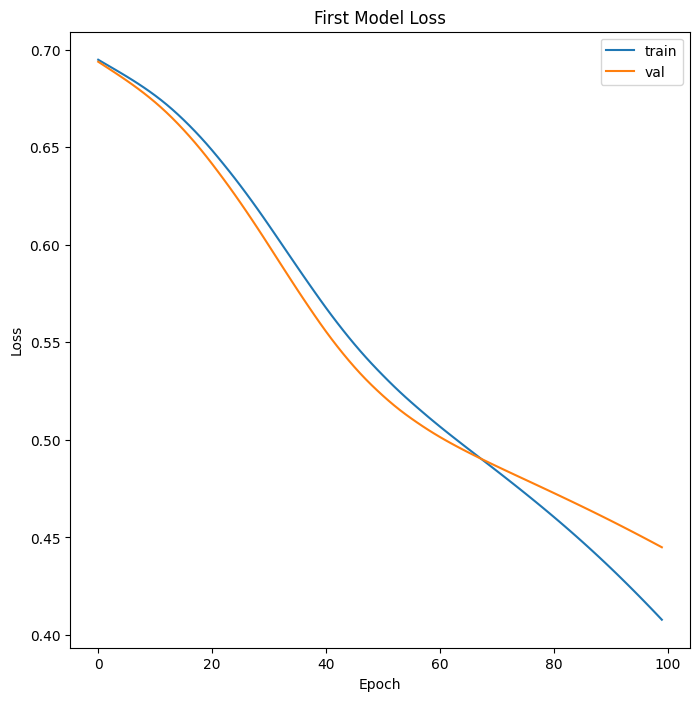

In [104]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8,8))
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('First Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [105]:
model_inf = FFNN(input_dim,hidden_dim_1,hidden_dim_2,output_dim).cuda()

In [106]:
model_inf.load_state_dict(torch.load('best_model.pt'))
model_inf.eval()

FFNN(
  (layer_1): Linear(in_features=1000, out_features=512, bias=True)
  (relu_1): ReLU()
  (layer_2): Linear(in_features=512, out_features=512, bias=True)
  (relu_2): ReLU()
  (layer_3): Linear(in_features=512, out_features=1, bias=True)
)

In [107]:
#ลองทำนายจากชุดเทส
tfidfX_test = tfidfX_test.to(device)
Y_test = Y_test.to(device)

# Forward pass to get output
model_inf.eval()
test_prediction = model_inf.forward(tfidfX_test.float())
test_prediction = torch.squeeze(test_prediction)

#Calculate accuracy on test set
test_accuracy = calculate_accuracy(Y_test,test_prediction)

print("Test Accuracy:",round(test_accuracy.item(),4), "\n")

Test Accuracy: 0.7283 



In [108]:
#Show the classification report
test_prediction = test_prediction.to(device)
test_prediction = test_prediction.ge(.5).view(-1).cpu()
Y_test = Y_test.cpu()

print(classification_report(Y_test,test_prediction))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        47
         1.0       0.73      1.00      0.84       126

    accuracy                           0.73       173
   macro avg       0.36      0.50      0.42       173
weighted avg       0.53      0.73      0.61       173



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [109]:
!wget https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/pos.txt
!wget https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/neg.txt

--2024-01-15 14:42:49--  https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/pos.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 761195 (743K) [text/plain]
Saving to: ‘pos.txt.1’

pos.txt.1           100%[===================>] 743.35K  --.-KB/s    in 0.02s   

2024-01-15 14:42:49 (41.9 MB/s) - ‘pos.txt.1’ saved [761195/761195]

--2024-01-15 14:42:49--  https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/neg.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1676577 (1.6M) [text/plain]
Sav

In [110]:
pos_text = file2list("asp_pos.txt")
neg_text = file2list("asp_neg.txt")

pos_text_ws = file2list("pos.txt")
neg_text_ws = file2list("neg.txt")

In [111]:
pos_df = pd.DataFrame(pos_text,columns=['review'])
pos_df['label'] = "positive"

neg_df = pd.DataFrame(neg_text,columns=['review'])
neg_df['label'] = "negative"
neg_df
################################

pos_df_ws = pd.DataFrame(pos_text_ws,columns=['review'])
pos_df_ws['label'] = "positive"

neg_df_ws = pd.DataFrame(neg_text_ws,columns=['review'])
neg_df_ws['label'] = "negative"
neg_df

cp_data = pd.concat([pos_df, neg_df])
ws_data = pd.concat([pos_df_ws, neg_df_ws])

cp_data.sample(10)
ws_data.sample(10)

,review,label
3240,ความเพลียวันนี้ UBeer แค่ครึ่งขวดก็ทำให้ง่วงได...,negative
6374,#ยุบพรรค #ไทยรักษาชาติ คดีคืบหน้าไวมากเลยนะครั...,negative
2434,เพิ่งเคยกินอาชา อร่อยกว่าช้างอีก 55555555,negative
3261,จะถือ Pantone ไปตรวจปรู๊ฟด้วยว่าสีตรงมั้ย 😆,positive
2261,ชวนก้อไม่มีคัยไป. แถมวันนี้ไม่ว่างด้วย,negative
6767,ผมว่าบริการหลายด้านแย่ลงอย่างเห็นได้ชัดเลย เช่...,negative
3388,ชอบ toyotabuzz จัดกิจกรรมตลอด คืนกำไรให้กับลูกค้า,positive
390,งั้นไม่กินละ 555,negative
385,คงใกล้จบแล้วแน่ๆ,negative
4210,#เมอา สั่นๆง่ายได้ใจความ ภาษาติ่งเค้าบอกให้ผมเ...,positive


In [112]:
#split data using this command

reviews = ws_data['review'].values
labels = ws_data['label'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

train_sentences_ws, test_sentences, train_labels_ws, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels,test_size=0.2, random_state=1234)

In [113]:
from pythainlp.tokenize import word_tokenize
import re

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def thai_clean_text(text):
    st = ""

    #สามารถเพิ่มโค้ด สำหรับคลีน ข้อความ เช่น ลบ emoji ออก เป็นต้น
    #text = deEmojify(text)
    text = text.replace("\n"," ")
    for w in word_tokenize(text):
        st = st + w + " "

    return  re.sub(' +', ' ', st).strip()

cp_data['review'] = cp_data.review.apply(thai_clean_text)
ws_data['review'] = ws_data.review.apply(thai_clean_text)
cp_data.sample(5)
ws_data.sample(5)

,review,label
1375,เลี้ยง หน่อย ยยย,positive
1619,ดีกว่า โจ มา โลน ละ กัน น้ำตา เล็ด อะ,negative
1444,วัน ศุกร์ ไป รับ เด็ก จ้า ไม่ ว่าง,negative
2613,นี้ มัน All new max ถ้า แค่นี้ ไปหา ดี แมก ดีกว่า,negative
2935,เอา โลโก้ นิสสัน ออก แล้ว เอา gtr มา แปะ จะ ดู...,negative


In [114]:
import pythainlp
thai_stopwords = pythainlp.corpus.common.thai_stopwords()

print(thai_stopwords)

frozenset({'กลุ่มๆ', 'ใหม่ๆ', 'ตลอดมา', 'แต่', 'ตรง', 'ข้างบน', 'กำลังจะ', 'ให้มา', 'จัง', 'จากนั้น', 'เรา', 'วันนี้', 'เหล่า', 'คราวโน้น', 'พวกนี้', 'เพิ่ม', 'ล่าสุด', 'วันนั้น', 'น่ะ', 'ตลอดจน', 'กว่า', 'แค่นั้น', 'มิได้', 'ถึงบัดนี้', 'คือ', 'อื่น', 'ค่อย', 'เหตุ', 'ได้แต่', 'ค่อยไปทาง', 'ที่ได้', 'ไฉน', 'ขณะใดๆ', 'ภาย', 'นี้แหล่', 'นำ', 'อย่างมาก', 'ครบ', 'ข้างเคียง', 'กันเอง', 'พอเพียง', 'ที่สุด', 'ยังงี้', 'หน่อย', 'อย่างโน้น', 'กำหนด', 'เป็นเพื่อ', 'กระผม', 'อย่างใด', 'อันๆ', 'กว้างๆ', 'จรดกับ', 'เช่นไร', 'ส่วนด้อย', 'เชื่อถือ', 'นานๆ', 'ประการหนึ่ง', 'อย่าง', 'ซึ่งกันและกัน', 'ครบครัน', 'เช่นเมื่อ', 'เช่นดัง', 'วัน', 'ช่วงท้าย', 'เผื่อ', 'เสร็จแล้ว', 'ได้', 'อย่างเช่น', 'นั่นแหละ', 'ดัง', 'สู่', 'จัดการ', 'เป็นแต่เพียง', 'ดังเคย', 'เพิ่มเติม', 'ดั่งกับว่า', 'เป็นแต่', 'ช่วย', 'ตามที่', 'ด้วยกัน', 'เพิ่งจะ', 'เปิดเผย', 'ทั่ว', 'ค่อน', 'พอตัว', 'มอง', 'จาก', 'บัดเดี๋ยวนี้', 'ช่วง', 'ทีไร', 'ทุกๆ', 'ครั้งใด', 'พร้อมที่', 'เรียบ', 'เหตุนี้', 'ยิ่งใหญ่', 'เมื่อเย็น', 'คุณๆ', 'คราใด'

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
val_size = int(len(test_sentences)/2)
train = list(train_sentences)[:(len(train_sentences)-val_size)]
val = list(train_sentences)[(len(train_sentences)-val_size):]
test = list(test_sentences)

tfidf_vectorizer = TfidfVectorizer(max_features=1000, dtype=np.float32)

#ใช้ชุดเทรน ทำ vectorizer
tfidfX_train = tfidf_vectorizer.fit_transform(train)
tfidfX_train = torch.tensor(tfidfX_train.toarray())

tfidfX_val = tfidf_vectorizer.transform(val)
tfidfX_val = torch.tensor(tfidfX_val.toarray())

tfidfX_test = tfidf_vectorizer.transform(test)
tfidfX_test = torch.tensor(tfidfX_test.toarray())

print("TF-IDF train shape:", tfidfX_train.shape)
print("TF-IDF test shape:", tfidfX_test.shape)
print("TF-IDF val shape:", tfidfX_val.shape)

TF-IDF train shape: torch.Size([224, 953])
TF-IDF test shape: torch.Size([2321, 953])
TF-IDF val shape: torch.Size([468, 953])


In [116]:
train_sentences[:2]

array(['สินค้า จะ มีตำหนิ ที่ ตัว บอดี้ เหมือน รอยไหม้ เสร็จ แล้ว ใช้ได้ ทุก จุด ใน การ ชาร์จ และ มีหัว type c ให้ ด้วย USB ก็ ให้ มา เยอะ ตอบ โจทย์ ข้อเสีย คือ งาน จัดส่ง ช้า จริง สั่ง ตั้ง แต่วัน ศุกร์ ส่ง จันทร์ แต่ ยัง ดี ได้ วัน อังคาร ทัน ใช้ อีก หนึ่ง จุด ที่ ต้อง พิจารณา ก็ คือ ไม่ รู้ มี สายดิน ต่อ ถูกต้อง ไหม ด้านใน ',
       'กระเป๋า สวย ตรง ปก ขนาด กำลัง พอดี สาย ปรับ ได้ มี ถุง กัน ฝุ่น มา พร้อม กระเป๋า ร้าน จัดส่ง ให้ รวดเร็ว แพ็ค สิ ค้า มา ดี มี ของแถม ให้ ด้วย ขนส่ง บริการ ดี '],
      dtype=object)

In [117]:
train_labels[:20]

array([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [118]:
print(train[0:3])

['สินค้า จะ มีตำหนิ ที่ ตัว บอดี้ เหมือน รอยไหม้ เสร็จ แล้ว ใช้ได้ ทุก จุด ใน การ ชาร์จ และ มีหัว type c ให้ ด้วย USB ก็ ให้ มา เยอะ ตอบ โจทย์ ข้อเสีย คือ งาน จัดส่ง ช้า จริง สั่ง ตั้ง แต่วัน ศุกร์ ส่ง จันทร์ แต่ ยัง ดี ได้ วัน อังคาร ทัน ใช้ อีก หนึ่ง จุด ที่ ต้อง พิจารณา ก็ คือ ไม่ รู้ มี สายดิน ต่อ ถูกต้อง ไหม ด้านใน ', 'กระเป๋า สวย ตรง ปก ขนาด กำลัง พอดี สาย ปรับ ได้ มี ถุง กัน ฝุ่น มา พร้อม กระเป๋า ร้าน จัดส่ง ให้ รวดเร็ว แพ็ค สิ ค้า มา ดี มี ของแถม ให้ ด้วย ขนส่ง บริการ ดี ', 'ดี ส่ง ไว คุณภาพ ดีเยี่ยม ส่ง เร วจา ก ต่างประเทศ คุณภาพดี เยี่ยมยอด สวยงาม ราคา ไม่ แพง ดีงาม สมราคา ไม่ แพง รอ ของ ไม่ นาน ']


In [119]:
print(tfidfX_train[100])

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [120]:
import torch
Y_train = torch.squeeze(torch.tensor(list(train_labels[:(len(train_sentences)-val_size)])).float())
Y_val = torch.squeeze(torch.tensor(train_labels[(len(train_sentences)-val_size):]).float())
Y_test = torch.squeeze(torch.tensor(test_labels).float())

print("Y train shape:", Y_train.shape)
print("Y test shape:", Y_val.shape)
print("Y shape:", Y_test.shape)

Y train shape: torch.Size([224])
Y test shape: torch.Size([468])
Y shape: torch.Size([2321])


In [121]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [122]:
#สร้าง FFNN ขึ้นมา
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(FFNN, self).__init__()

        # Linear function 1
        self.layer_1 = nn.Linear(input_dim, hidden_dim_1)

        # Non-linearity 1
        self.relu_1 = nn.ReLU()

        # Linear function 2
        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        # Non-linearity 2
        self.relu_2 = nn.ReLU()

        # Linear function 3
        self.layer_3 = nn.Linear(hidden_dim_2, output_dim)

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu_1(out)

        out = self.layer_2(out)
        out = self.relu_2(out)

        out = self.layer_3(out)

        return torch.sigmoid(out)

In [123]:
# กำหนดจำนวนรอบที่จะเทรน
input_dim = tfidfX_train.shape[1]
hidden_dim_1 = 512 #จำนวนโหนด
hidden_dim_2 = 512
output_dim = 1 #จำนวน output dim ใช้ 1 ได้ คือเราอยากจะทำนายค่าออกมาค่าเดียว 0 = negative และ 1 คือ เป็น positive
num_epochs = 100
import random
random.seed(12345)

# สร้าง model จากคลาส
first_model = FFNN(input_dim,hidden_dim_1,hidden_dim_2,output_dim)

# Define loss function.
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

# Define as optimizer Adam.
optimizer = optim.Adam(first_model.parameters(),lr=0.1e-4,weight_decay=1e-3)

# Transfer all the computation to GPU (cuda device).
first_model.to(device)
criterion = criterion.to(device)

In [124]:
from tqdm import tqdm

# This is a function that calculate the accuracy manually
def calculate_accuracy(y_true, y_pred):
  y_pred = torch.round(y_pred)
  correct = (y_true == y_pred).float()
  acc = correct.sum() / len(correct)
  return acc

batch_size = 32

# Split train dataset to mini batches
X_train_mini_batches = torch.split(tfidfX_train,batch_size)
Y_train_mini_batches = torch.split(Y_train,batch_size)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
min_loss = float('inf')

# Start training
for epoch in range(num_epochs):
  print('epoch',epoch)
  epoch_loss = 0
  epoch_accuracy = 0
  validation_loss=0
  val_accuracy=0

  for X_train_mini_batch,Y_train_mini_batch in tqdm(zip(X_train_mini_batches,Y_train_mini_batches)):

    X_train_mini_batch = X_train_mini_batch.to(device)
    Y_train_mini_batch = Y_train_mini_batch.to(device)

    # Forward pass to get output
    train_prediction = first_model.forward(X_train_mini_batch.float())
    train_prediction = torch.squeeze(train_prediction)

    # Calculate Loss
    train_loss = criterion(train_prediction,Y_train_mini_batch)

    # Clearing up accumulated gradients
    optimizer.zero_grad()

    # Getting gradients
    train_loss.backward()

    # Updating parameters
    optimizer.step()

    # Add each mini batch's loss
    epoch_loss += train_loss.item()

    # Add each mini batch's accuracy
    epoch_accuracy += calculate_accuracy(Y_train_mini_batch,train_prediction)

  # For some epochs print loss and accucary of train and validation set.
  if epoch % 1 == 0:

    tfidfX_val = tfidfX_val.to(device)
    Y_val = Y_val.to(device)

    # Forward pass to get output
    val_prediction = first_model.forward(tfidfX_val.float())
    val_prediction = torch.squeeze(val_prediction)

    # Calculate Loss
    val_loss = criterion(val_prediction,Y_val)

    # Add each mini batch's loss
    validation_loss = val_loss.item()

    # Add each mini batch's accuracy
    val_accuracy = calculate_accuracy(Y_val,val_prediction)

    epoch_loss /= len(X_train_mini_batches)
    epoch_accuracy /= len(X_train_mini_batches)
    val_losses.append(validation_loss)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    val_accuracies.append(val_accuracy)
    if validation_loss < min_loss:
      min_loss = validation_loss
      torch.save(first_model.state_dict(), 'best_model.pt')
      print('save best_model...')
    print("Epoch:",epoch, "\n"
           "Train_loss:",round(epoch_loss,4), "Train Accuracy:",round(epoch_accuracy.item(),4), "\n"
           "Validation_loss:  ",round(validation_loss,4), "Validation Accuracy:  ",round(val_accuracy.item(),4), "\n")

epoch 0


7it [00:00, 420.48it/s]


save best_model...
Epoch: 0 
Train_loss: 0.7035 Train Accuracy: 0.2589 
Validation_loss:   0.7022 Validation Accuracy:   0.2778 

epoch 1


7it [00:00, 467.06it/s]


save best_model...
Epoch: 1 
Train_loss: 0.7027 Train Accuracy: 0.2589 
Validation_loss:   0.7015 Validation Accuracy:   0.2778 

epoch 2


7it [00:00, 484.91it/s]


save best_model...
Epoch: 2 
Train_loss: 0.7019 Train Accuracy: 0.2589 
Validation_loss:   0.7008 Validation Accuracy:   0.2778 

epoch 3


7it [00:00, 419.84it/s]


save best_model...
Epoch: 3 
Train_loss: 0.7011 Train Accuracy: 0.2589 
Validation_loss:   0.7001 Validation Accuracy:   0.2778 

epoch 4


7it [00:00, 471.91it/s]


save best_model...
Epoch: 4 
Train_loss: 0.7003 Train Accuracy: 0.2589 
Validation_loss:   0.6994 Validation Accuracy:   0.2778 

epoch 5


7it [00:00, 452.34it/s]


save best_model...
Epoch: 5 
Train_loss: 0.6996 Train Accuracy: 0.2589 
Validation_loss:   0.6987 Validation Accuracy:   0.2778 

epoch 6


7it [00:00, 436.80it/s]


save best_model...
Epoch: 6 
Train_loss: 0.6988 Train Accuracy: 0.2589 
Validation_loss:   0.698 Validation Accuracy:   0.2778 

epoch 7


7it [00:00, 427.60it/s]


save best_model...
Epoch: 7 
Train_loss: 0.698 Train Accuracy: 0.2589 
Validation_loss:   0.6973 Validation Accuracy:   0.2778 

epoch 8


7it [00:00, 483.17it/s]


save best_model...
Epoch: 8 
Train_loss: 0.6972 Train Accuracy: 0.2589 
Validation_loss:   0.6966 Validation Accuracy:   0.2778 

epoch 9


7it [00:00, 478.98it/s]


save best_model...
Epoch: 9 
Train_loss: 0.6964 Train Accuracy: 0.2589 
Validation_loss:   0.6959 Validation Accuracy:   0.2778 

epoch 10


7it [00:00, 381.65it/s]


save best_model...
Epoch: 10 
Train_loss: 0.6957 Train Accuracy: 0.2589 
Validation_loss:   0.6952 Validation Accuracy:   0.2778 

epoch 11


7it [00:00, 455.95it/s]


save best_model...
Epoch: 11 
Train_loss: 0.6949 Train Accuracy: 0.2589 
Validation_loss:   0.6945 Validation Accuracy:   0.2799 

epoch 12


7it [00:00, 380.97it/s]


save best_model...
Epoch: 12 
Train_loss: 0.6941 Train Accuracy: 0.2723 
Validation_loss:   0.6938 Validation Accuracy:   0.3376 

epoch 13


7it [00:00, 363.20it/s]


save best_model...
Epoch: 13 
Train_loss: 0.6933 Train Accuracy: 0.433 
Validation_loss:   0.6931 Validation Accuracy:   0.5235 

epoch 14


7it [00:00, 468.79it/s]


save best_model...
Epoch: 14 
Train_loss: 0.6925 Train Accuracy: 0.6205 
Validation_loss:   0.6924 Validation Accuracy:   0.6795 

epoch 15


7it [00:00, 445.48it/s]


save best_model...
Epoch: 15 
Train_loss: 0.6917 Train Accuracy: 0.7857 
Validation_loss:   0.6917 Validation Accuracy:   0.7179 

epoch 16


7it [00:00, 381.24it/s]


save best_model...
Epoch: 16 
Train_loss: 0.6909 Train Accuracy: 0.7991 
Validation_loss:   0.6909 Validation Accuracy:   0.7201 

epoch 17


7it [00:00, 469.13it/s]


save best_model...
Epoch: 17 
Train_loss: 0.6901 Train Accuracy: 0.7455 
Validation_loss:   0.6902 Validation Accuracy:   0.7222 

epoch 18


7it [00:00, 469.64it/s]


save best_model...
Epoch: 18 
Train_loss: 0.6892 Train Accuracy: 0.7411 
Validation_loss:   0.6895 Validation Accuracy:   0.7222 

epoch 19


7it [00:00, 447.94it/s]


save best_model...
Epoch: 19 
Train_loss: 0.6884 Train Accuracy: 0.7411 
Validation_loss:   0.6887 Validation Accuracy:   0.7222 

epoch 20


7it [00:00, 455.64it/s]


save best_model...
Epoch: 20 
Train_loss: 0.6876 Train Accuracy: 0.7411 
Validation_loss:   0.688 Validation Accuracy:   0.7222 

epoch 21


7it [00:00, 359.53it/s]


save best_model...
Epoch: 21 
Train_loss: 0.6867 Train Accuracy: 0.7411 
Validation_loss:   0.6872 Validation Accuracy:   0.7222 

epoch 22


7it [00:00, 448.72it/s]


save best_model...
Epoch: 22 
Train_loss: 0.6858 Train Accuracy: 0.7411 
Validation_loss:   0.6865 Validation Accuracy:   0.7222 

epoch 23


7it [00:00, 466.77it/s]


save best_model...
Epoch: 23 
Train_loss: 0.685 Train Accuracy: 0.7411 
Validation_loss:   0.6857 Validation Accuracy:   0.7222 

epoch 24


7it [00:00, 450.95it/s]


save best_model...
Epoch: 24 
Train_loss: 0.6841 Train Accuracy: 0.7411 
Validation_loss:   0.6849 Validation Accuracy:   0.7222 

epoch 25


7it [00:00, 282.90it/s]


save best_model...
Epoch: 25 
Train_loss: 0.6832 Train Accuracy: 0.7411 
Validation_loss:   0.6841 Validation Accuracy:   0.7222 

epoch 26


7it [00:00, 380.29it/s]


save best_model...
Epoch: 26 
Train_loss: 0.6823 Train Accuracy: 0.7411 
Validation_loss:   0.6833 Validation Accuracy:   0.7222 

epoch 27


7it [00:00, 471.92it/s]


save best_model...
Epoch: 27 
Train_loss: 0.6813 Train Accuracy: 0.7411 
Validation_loss:   0.6825 Validation Accuracy:   0.7222 

epoch 28


7it [00:00, 461.91it/s]


save best_model...
Epoch: 28 
Train_loss: 0.6804 Train Accuracy: 0.7411 
Validation_loss:   0.6817 Validation Accuracy:   0.7222 

epoch 29


7it [00:00, 332.03it/s]


save best_model...
Epoch: 29 
Train_loss: 0.6794 Train Accuracy: 0.7411 
Validation_loss:   0.6808 Validation Accuracy:   0.7222 

epoch 30


7it [00:00, 435.33it/s]


save best_model...
Epoch: 30 
Train_loss: 0.6785 Train Accuracy: 0.7411 
Validation_loss:   0.68 Validation Accuracy:   0.7222 

epoch 31


7it [00:00, 459.69it/s]


save best_model...
Epoch: 31 
Train_loss: 0.6775 Train Accuracy: 0.7411 
Validation_loss:   0.6791 Validation Accuracy:   0.7222 

epoch 32


7it [00:00, 508.63it/s]


save best_model...
Epoch: 32 
Train_loss: 0.6765 Train Accuracy: 0.7411 
Validation_loss:   0.6783 Validation Accuracy:   0.7222 

epoch 33


7it [00:00, 441.41it/s]


save best_model...
Epoch: 33 
Train_loss: 0.6755 Train Accuracy: 0.7411 
Validation_loss:   0.6774 Validation Accuracy:   0.7222 

epoch 34


7it [00:00, 441.11it/s]


save best_model...
Epoch: 34 
Train_loss: 0.6745 Train Accuracy: 0.7411 
Validation_loss:   0.6765 Validation Accuracy:   0.7222 

epoch 35


7it [00:00, 419.42it/s]


save best_model...
Epoch: 35 
Train_loss: 0.6735 Train Accuracy: 0.7411 
Validation_loss:   0.6756 Validation Accuracy:   0.7222 

epoch 36


7it [00:00, 485.46it/s]


save best_model...
Epoch: 36 
Train_loss: 0.6724 Train Accuracy: 0.7411 
Validation_loss:   0.6747 Validation Accuracy:   0.7222 

epoch 37


7it [00:00, 358.85it/s]


save best_model...
Epoch: 37 
Train_loss: 0.6714 Train Accuracy: 0.7411 
Validation_loss:   0.6738 Validation Accuracy:   0.7222 

epoch 38


7it [00:00, 377.18it/s]


save best_model...
Epoch: 38 
Train_loss: 0.6703 Train Accuracy: 0.7411 
Validation_loss:   0.6729 Validation Accuracy:   0.7222 

epoch 39


7it [00:00, 446.92it/s]


save best_model...
Epoch: 39 
Train_loss: 0.6692 Train Accuracy: 0.7411 
Validation_loss:   0.672 Validation Accuracy:   0.7222 

epoch 40


7it [00:00, 310.71it/s]


save best_model...
Epoch: 40 
Train_loss: 0.6681 Train Accuracy: 0.7411 
Validation_loss:   0.671 Validation Accuracy:   0.7222 

epoch 41


7it [00:00, 446.51it/s]


save best_model...
Epoch: 41 
Train_loss: 0.667 Train Accuracy: 0.7411 
Validation_loss:   0.6701 Validation Accuracy:   0.7222 

epoch 42


7it [00:00, 488.17it/s]


save best_model...
Epoch: 42 
Train_loss: 0.6658 Train Accuracy: 0.7411 
Validation_loss:   0.6691 Validation Accuracy:   0.7222 

epoch 43


7it [00:00, 397.86it/s]


save best_model...
Epoch: 43 
Train_loss: 0.6646 Train Accuracy: 0.7411 
Validation_loss:   0.6681 Validation Accuracy:   0.7222 

epoch 44


7it [00:00, 452.31it/s]

save best_model...


Epoch: 44 
Train_loss: 0.6634 Train Accuracy: 0.7411 
Validation_loss:   0.6671 Validation Accuracy:   0.7222 

epoch 45


7it [00:00, 460.93it/s]


save best_model...
Epoch: 45 
Train_loss: 0.6622 Train Accuracy: 0.7411 
Validation_loss:   0.6661 Validation Accuracy:   0.7222 

epoch 46


7it [00:00, 456.69it/s]


save best_model...
Epoch: 46 
Train_loss: 0.661 Train Accuracy: 0.7411 
Validation_loss:   0.665 Validation Accuracy:   0.7222 

epoch 47


7it [00:00, 461.48it/s]


save best_model...
Epoch: 47 
Train_loss: 0.6598 Train Accuracy: 0.7411 
Validation_loss:   0.664 Validation Accuracy:   0.7222 

epoch 48


7it [00:00, 444.24it/s]


save best_model...
Epoch: 48 
Train_loss: 0.6585 Train Accuracy: 0.7411 
Validation_loss:   0.6629 Validation Accuracy:   0.7222 

epoch 49


7it [00:00, 345.71it/s]


save best_model...
Epoch: 49 
Train_loss: 0.6572 Train Accuracy: 0.7411 
Validation_loss:   0.6619 Validation Accuracy:   0.7222 

epoch 50


7it [00:00, 408.64it/s]


save best_model...
Epoch: 50 
Train_loss: 0.656 Train Accuracy: 0.7411 
Validation_loss:   0.6608 Validation Accuracy:   0.7222 

epoch 51


7it [00:00, 389.14it/s]


save best_model...
Epoch: 51 
Train_loss: 0.6547 Train Accuracy: 0.7411 
Validation_loss:   0.6597 Validation Accuracy:   0.7222 

epoch 52


7it [00:00, 449.91it/s]

save best_model...


Epoch: 52 
Train_loss: 0.6533 Train Accuracy: 0.7411 
Validation_loss:   0.6587 Validation Accuracy:   0.7222 

epoch 53


7it [00:00, 448.99it/s]


save best_model...
Epoch: 53 
Train_loss: 0.652 Train Accuracy: 0.7411 
Validation_loss:   0.6576 Validation Accuracy:   0.7222 

epoch 54


7it [00:00, 373.11it/s]


save best_model...
Epoch: 54 
Train_loss: 0.6507 Train Accuracy: 0.7411 
Validation_loss:   0.6564 Validation Accuracy:   0.7222 

epoch 55


7it [00:00, 420.18it/s]


save best_model...
Epoch: 55 
Train_loss: 0.6493 Train Accuracy: 0.7411 
Validation_loss:   0.6553 Validation Accuracy:   0.7222 

epoch 56


7it [00:00, 428.49it/s]


save best_model...
Epoch: 56 
Train_loss: 0.6479 Train Accuracy: 0.7411 
Validation_loss:   0.6542 Validation Accuracy:   0.7222 

epoch 57


7it [00:00, 411.70it/s]


save best_model...
Epoch: 57 
Train_loss: 0.6465 Train Accuracy: 0.7411 
Validation_loss:   0.6531 Validation Accuracy:   0.7222 

epoch 58


7it [00:00, 301.94it/s]


save best_model...
Epoch: 58 
Train_loss: 0.6451 Train Accuracy: 0.7411 
Validation_loss:   0.6519 Validation Accuracy:   0.7222 

epoch 59


7it [00:00, 307.00it/s]


save best_model...
Epoch: 59 
Train_loss: 0.6437 Train Accuracy: 0.7411 
Validation_loss:   0.6507 Validation Accuracy:   0.7222 

epoch 60


7it [00:00, 401.31it/s]


save best_model...
Epoch: 60 
Train_loss: 0.6423 Train Accuracy: 0.7411 
Validation_loss:   0.6496 Validation Accuracy:   0.7222 

epoch 61


7it [00:00, 340.30it/s]


save best_model...
Epoch: 61 
Train_loss: 0.6408 Train Accuracy: 0.7411 
Validation_loss:   0.6484 Validation Accuracy:   0.7222 

epoch 62


7it [00:00, 369.51it/s]


save best_model...
Epoch: 62 
Train_loss: 0.6393 Train Accuracy: 0.7411 
Validation_loss:   0.6472 Validation Accuracy:   0.7222 

epoch 63


7it [00:00, 449.45it/s]


save best_model...
Epoch: 63 
Train_loss: 0.6378 Train Accuracy: 0.7411 
Validation_loss:   0.646 Validation Accuracy:   0.7222 

epoch 64


7it [00:00, 445.50it/s]


save best_model...
Epoch: 64 
Train_loss: 0.6363 Train Accuracy: 0.7411 
Validation_loss:   0.6448 Validation Accuracy:   0.7222 

epoch 65


7it [00:00, 484.79it/s]


save best_model...
Epoch: 65 
Train_loss: 0.6347 Train Accuracy: 0.7411 
Validation_loss:   0.6435 Validation Accuracy:   0.7222 

epoch 66


7it [00:00, 421.21it/s]


save best_model...
Epoch: 66 
Train_loss: 0.6332 Train Accuracy: 0.7411 
Validation_loss:   0.6423 Validation Accuracy:   0.7222 

epoch 67


7it [00:00, 423.06it/s]


save best_model...
Epoch: 67 
Train_loss: 0.6316 Train Accuracy: 0.7411 
Validation_loss:   0.641 Validation Accuracy:   0.7222 

epoch 68


7it [00:00, 434.37it/s]


save best_model...
Epoch: 68 
Train_loss: 0.63 Train Accuracy: 0.7411 
Validation_loss:   0.6397 Validation Accuracy:   0.7222 

epoch 69


7it [00:00, 439.86it/s]


save best_model...
Epoch: 69 
Train_loss: 0.6283 Train Accuracy: 0.7411 
Validation_loss:   0.6384 Validation Accuracy:   0.7222 

epoch 70


7it [00:00, 469.64it/s]


save best_model...
Epoch: 70 
Train_loss: 0.6267 Train Accuracy: 0.7411 
Validation_loss:   0.6371 Validation Accuracy:   0.7222 

epoch 71


7it [00:00, 482.37it/s]


save best_model...
Epoch: 71 
Train_loss: 0.625 Train Accuracy: 0.7411 
Validation_loss:   0.6358 Validation Accuracy:   0.7222 

epoch 72


7it [00:00, 474.95it/s]


save best_model...
Epoch: 72 
Train_loss: 0.6232 Train Accuracy: 0.7411 
Validation_loss:   0.6345 Validation Accuracy:   0.7222 

epoch 73


7it [00:00, 488.73it/s]


save best_model...
Epoch: 73 
Train_loss: 0.6215 Train Accuracy: 0.7411 
Validation_loss:   0.6331 Validation Accuracy:   0.7222 

epoch 74


7it [00:00, 454.73it/s]


save best_model...
Epoch: 74 
Train_loss: 0.6197 Train Accuracy: 0.7411 
Validation_loss:   0.6317 Validation Accuracy:   0.7222 

epoch 75


7it [00:00, 453.48it/s]


save best_model...
Epoch: 75 
Train_loss: 0.6179 Train Accuracy: 0.7411 
Validation_loss:   0.6304 Validation Accuracy:   0.7222 

epoch 76


7it [00:00, 371.19it/s]


save best_model...
Epoch: 76 
Train_loss: 0.6161 Train Accuracy: 0.7411 
Validation_loss:   0.629 Validation Accuracy:   0.7222 

epoch 77


7it [00:00, 494.37it/s]


save best_model...
Epoch: 77 
Train_loss: 0.6143 Train Accuracy: 0.7411 
Validation_loss:   0.6276 Validation Accuracy:   0.7222 

epoch 78


7it [00:00, 411.10it/s]


save best_model...
Epoch: 78 
Train_loss: 0.6125 Train Accuracy: 0.7411 
Validation_loss:   0.6262 Validation Accuracy:   0.7222 

epoch 79


7it [00:00, 344.59it/s]


save best_model...
Epoch: 79 
Train_loss: 0.6106 Train Accuracy: 0.7411 
Validation_loss:   0.6248 Validation Accuracy:   0.7222 

epoch 80


7it [00:00, 454.20it/s]


save best_model...
Epoch: 80 
Train_loss: 0.6087 Train Accuracy: 0.7411 
Validation_loss:   0.6234 Validation Accuracy:   0.7222 

epoch 81


7it [00:00, 446.39it/s]


save best_model...
Epoch: 81 
Train_loss: 0.6069 Train Accuracy: 0.7411 
Validation_loss:   0.622 Validation Accuracy:   0.7222 

epoch 82


7it [00:00, 445.78it/s]


save best_model...
Epoch: 82 
Train_loss: 0.605 Train Accuracy: 0.7411 
Validation_loss:   0.6206 Validation Accuracy:   0.7222 

epoch 83


7it [00:00, 465.54it/s]


save best_model...
Epoch: 83 
Train_loss: 0.603 Train Accuracy: 0.7411 
Validation_loss:   0.6192 Validation Accuracy:   0.7222 

epoch 84


7it [00:00, 438.24it/s]


save best_model...
Epoch: 84 
Train_loss: 0.6011 Train Accuracy: 0.7411 
Validation_loss:   0.6177 Validation Accuracy:   0.7222 

epoch 85


7it [00:00, 416.36it/s]


save best_model...
Epoch: 85 
Train_loss: 0.5992 Train Accuracy: 0.7411 
Validation_loss:   0.6163 Validation Accuracy:   0.7222 

epoch 86


7it [00:00, 355.17it/s]


save best_model...
Epoch: 86 
Train_loss: 0.5972 Train Accuracy: 0.7411 
Validation_loss:   0.6149 Validation Accuracy:   0.7222 

epoch 87


7it [00:00, 473.11it/s]


save best_model...
Epoch: 87 
Train_loss: 0.5952 Train Accuracy: 0.7411 
Validation_loss:   0.6134 Validation Accuracy:   0.7222 

epoch 88


7it [00:00, 454.01it/s]


save best_model...
Epoch: 88 
Train_loss: 0.5932 Train Accuracy: 0.7411 
Validation_loss:   0.612 Validation Accuracy:   0.7222 

epoch 89


7it [00:00, 428.73it/s]


save best_model...
Epoch: 89 
Train_loss: 0.5912 Train Accuracy: 0.7411 
Validation_loss:   0.6105 Validation Accuracy:   0.7222 

epoch 90


7it [00:00, 472.64it/s]


save best_model...
Epoch: 90 
Train_loss: 0.5892 Train Accuracy: 0.7411 
Validation_loss:   0.6091 Validation Accuracy:   0.7222 

epoch 91


7it [00:00, 407.90it/s]


save best_model...
Epoch: 91 
Train_loss: 0.5871 Train Accuracy: 0.7411 
Validation_loss:   0.6076 Validation Accuracy:   0.7222 

epoch 92


7it [00:00, 429.32it/s]


save best_model...
Epoch: 92 
Train_loss: 0.5851 Train Accuracy: 0.7411 
Validation_loss:   0.6062 Validation Accuracy:   0.7222 

epoch 93


7it [00:00, 414.91it/s]


save best_model...
Epoch: 93 
Train_loss: 0.583 Train Accuracy: 0.7411 
Validation_loss:   0.6048 Validation Accuracy:   0.7222 

epoch 94


7it [00:00, 324.90it/s]


save best_model...
Epoch: 94 
Train_loss: 0.581 Train Accuracy: 0.7411 
Validation_loss:   0.6033 Validation Accuracy:   0.7222 

epoch 95


7it [00:00, 429.73it/s]


save best_model...
Epoch: 95 
Train_loss: 0.5789 Train Accuracy: 0.7411 
Validation_loss:   0.6019 Validation Accuracy:   0.7222 

epoch 96


7it [00:00, 464.72it/s]


save best_model...
Epoch: 96 
Train_loss: 0.5768 Train Accuracy: 0.7411 
Validation_loss:   0.6004 Validation Accuracy:   0.7222 

epoch 97


7it [00:00, 455.07it/s]


save best_model...
Epoch: 97 
Train_loss: 0.5747 Train Accuracy: 0.7411 
Validation_loss:   0.599 Validation Accuracy:   0.7222 

epoch 98


7it [00:00, 442.87it/s]


save best_model...
Epoch: 98 
Train_loss: 0.5726 Train Accuracy: 0.7411 
Validation_loss:   0.5976 Validation Accuracy:   0.7222 

epoch 99


7it [00:00, 410.89it/s]

save best_model...
Epoch: 99 
Train_loss: 0.5705 Train Accuracy: 0.7411 
Validation_loss:   0.5961 Validation Accuracy:   0.7222 



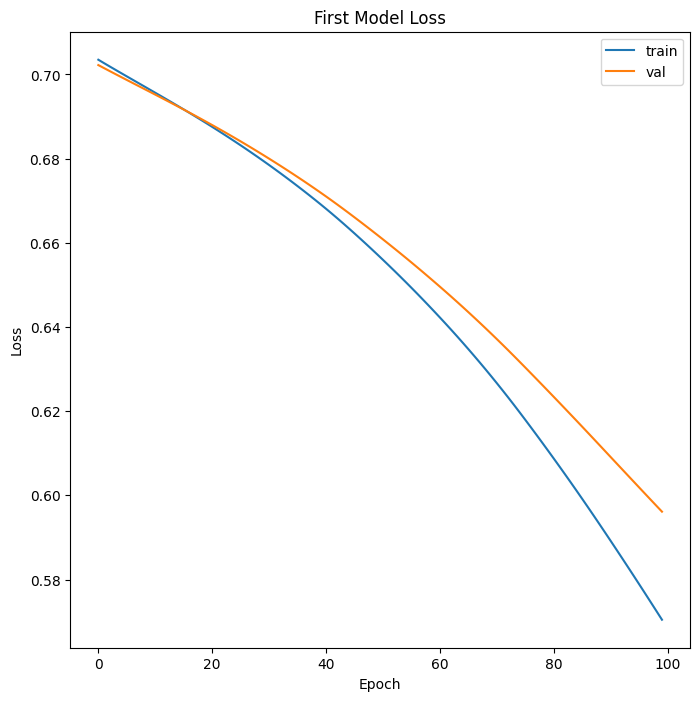

In [125]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8,8))
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('First Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [131]:
model_inf = FFNN(input_dim,hidden_dim_1,hidden_dim_2,output_dim).cuda()

In [132]:
model_inf.load_state_dict(torch.load('best_model.pt'))
model_inf.eval()

FFNN(
  (layer_1): Linear(in_features=953, out_features=512, bias=True)
  (relu_1): ReLU()
  (layer_2): Linear(in_features=512, out_features=512, bias=True)
  (relu_2): ReLU()
  (layer_3): Linear(in_features=512, out_features=1, bias=True)
)

In [133]:
#ลองทำนายจากชุดเทส
tfidfX_test = tfidfX_test.to(device)
Y_test = Y_test.to(device)

# Forward pass to get output
model_inf.eval()
test_prediction = model_inf.forward(tfidfX_test.float())
test_prediction = torch.squeeze(test_prediction)

#Calculate accuracy on test set
test_accuracy = calculate_accuracy(Y_test,test_prediction)

print("Test Accuracy:",round(test_accuracy.item(),4), "\n")

Test Accuracy: 0.4119 



In [134]:
#Show the classification report
test_prediction = test_prediction.to(device)
test_prediction = test_prediction.ge(.5).view(-1).cpu()
Y_test = Y_test.cpu()

print(classification_report(Y_test,test_prediction))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1365
         1.0       0.41      1.00      0.58       956

    accuracy                           0.41      2321
   macro avg       0.21      0.50      0.29      2321
weighted avg       0.17      0.41      0.24      2321



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [135]:
report = classification_report(Y_test,test_prediction, output_dict=True)
df = pd.DataFrame(report).transpose()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [136]:
df

,precision,recall,f1-score,support
0.0,0.000000,0.000000,0.000000,1365.000000
1.0,0.411891,1.000000,0.583460,956.000000
accuracy,0.411891,0.411891,0.411891,0.411891
macro avg,0.205946,0.500000,0.291730,2321.000000
weighted avg,0.169655,0.411891,0.240322,2321.000000
